# DESCRIPTIVE STATISTICS:

### This code will begin similar to the one for the main model, but will not feature a train test split or a model building; wrangling will continue until one step before model building and then will focus on the database's descriptive statistics
### These steps as they are here present would induce data leakage if they were to feed a model

Data ingestion<br>

Data wrangling and feature engineering
- Outlier removal<br>
- Tokenization and cleanup of job titles<br>
- Creation of dummies for all categorical variables<br>

Train test split<br>

Post split wrangling<br>
- Feature selection and database cleanup<br>
- Target variable normalization<br>

### Data description
- Categorical volumes<br>
- Dummies' impacts charts and tables<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, shapiro, normaltest, kstest, pearsonr
from scipy.special import inv_boxcox
from itertools import combinations

In [2]:
sns.set() # makes all charts look better by default

In [3]:
aijobs = pd.read_csv(r'https://ai-jobs.net/salaries/download/salaries.csv')
# Last accessed at 2024-03-16

In [4]:
aijobs # first look at the data

work_year experience_level employment_type                 job_title  \
0           2024               MI              FT            Data Scientist   
1           2024               MI              FT            Data Scientist   
2           2024               SE              FT              AI Architect   
3           2024               SE              FT              AI Architect   
4           2024               SE              FT            Data Scientist   
...          ...              ...             ...                       ...   
14486       2020               SE              FT            Data Scientist   
14487       2021               MI              FT  Principal Data Scientist   
14488       2020               EN              FT            Data Scientist   
14489       2020               EN              CT     Business Data Analyst   
14490       2021               SE              FT      Data Science Manager   

        salary salary_currency  salary_in_usd employee_residence  \
0        86218             USD          86218                 CA   
1        68975             USD          68975                 CA   
2       285000             USD         285000                 US   
3       153400             USD         153400                 US   
4       101763             USD         101763                 CA   
...        ...             ...            ...                ...   
14486   412000             USD         412000                 US   
14487   151000             USD         151000                 US   
14488   105000             USD         105000                 US   
14489   100000             USD         100000                 US   
14490  7000000             INR          94665                 IN   

       remote_ratio company_location company_size  
0                 0               CA            M  
1                 0               CA            M  
2                 0               US            M  
3                 0               US            M  
4                 0               CA            M  
...             ...              ...          ...  
14486           100               US            L  
14487           100               US            L  
14488           100               US            S  
14489           100               US            L  
14490            50               IN            L  

[14491 rows x 11 columns]

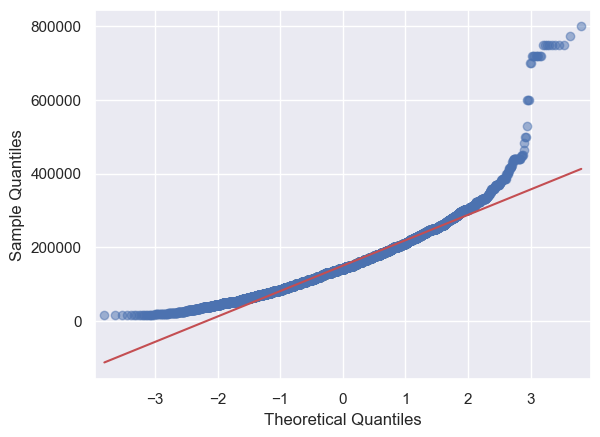

In [5]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

In [6]:
# The first outliers are absurd. They will skew every result too much and must be removed.
outmax = 450_000
outliers = aijobs[aijobs['salary_in_usd'] > outmax].index
print(outliers)

aijobs.drop(outliers, inplace=True)
aijobs.reset_index(drop=True, inplace=True)
aijobs.sort_values('salary_in_usd', ascending=False).head()

Index([ 100,  259,  582,  584,  592,  761, 1389, 1596, 1604, 1612, 2087, 2173,
       2263, 2267, 2403, 2579, 2990, 3765, 3795, 3805, 3809, 4363, 4369, 4672,
       5023, 5299, 5347, 5455],
      dtype='int64')


work_year experience_level employment_type                 job_title  \
3558        2024               SE              FT         Research Engineer   
14245       2020               MI              FT        Research Scientist   
144         2024               SE              FT              AI Architect   
2106        2024               EX              FT  Head of Machine Learning   
3477        2024               SE              FT         Research Engineer   

       salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
3558   450000             USD         450000                 US             0   
14245  450000             USD         450000                 US             0   
144    449000             USD         449000                 US             0   
2106   448000             USD         448000                 US           100   
3477   440000             USD         440000                 US             0   

      company_location company_size  
3558                US            M  
14245               US            M  
144                 US            M  
2106                US            M  
3477                US            M

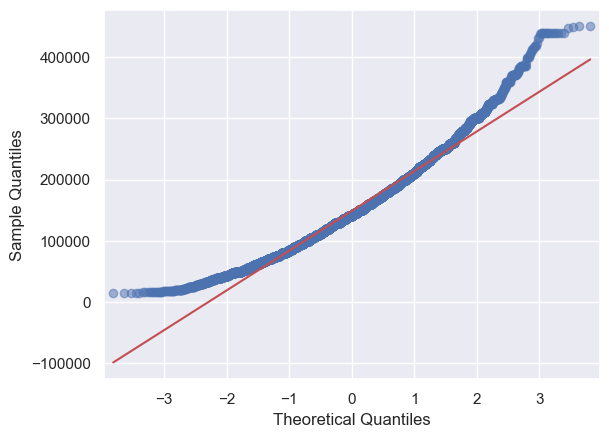

In [7]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

# Common data wrangling:
These steps will be equally done so no data leakage will occur if done now

In [8]:
# There is no value in local currency salaries as they're not scaled.
# Salary in USD conveys the same useful information in a scaled manner.
aijobs.drop('salary', axis=1, inplace=True)

In [9]:
# An interesting variable to research
aijobs['work_abroad'] = aijobs['employee_residence'] != aijobs['company_location']
aijobs['work_abroad'] = aijobs['work_abroad'].astype(int)
aijobs.tail(10)

work_year experience_level employment_type  \
14453       2021               SE              FT   
14454       2021               MI              FT   
14455       2021               MI              FT   
14456       2021               MI              FT   
14457       2021               SE              FT   
14458       2020               SE              FT   
14459       2021               MI              FT   
14460       2020               EN              FT   
14461       2020               EN              CT   
14462       2021               SE              FT   

                                job_title salary_currency  salary_in_usd  \
14453            Director of Data Science             USD         168000   
14454                      Data Scientist             SGD         119059   
14455  Applied Machine Learning Scientist             USD         423000   
14456                       Data Engineer             EUR          28369   
14457                     Data Specialist             USD         165000   
14458                      Data Scientist             USD         412000   
14459            Principal Data Scientist             USD         151000   
14460                      Data Scientist             USD         105000   
14461               Business Data Analyst             USD         100000   
14462                Data Science Manager             INR          94665   

      employee_residence  remote_ratio company_location company_size  \
14453                 JP             0               JP            S   
14454                 SG           100               IL            M   
14455                 US            50               US            L   
14456                 MT            50               MT            L   
14457                 US           100               US            L   
14458                 US           100               US            L   
14459                 US           100               US            L   
14460                 US           100               US            S   
14461                 US           100               US            L   
14462                 IN            50               IN            L   

       work_abroad  
14453            0  
14454            1  
14455            0  
14456            0  
14457            0  
14458            0  
14459            0  
14460            0  
14461            0  
14462            0

In [10]:
# remote_ratio is categorical; the correct way to interpret those numbers is:
#   0 == On Site (less than 20% remote)
#  50 == Partially remote/hybird
# 100 == Fully remote (more than 80% remote)
# therefore using it as numerical would be creating a spurious relationship.
# It has to be dummified and will be switched for easier interpretation.

aijobs.loc[aijobs['remote_ratio'] == 0, 'remote_ratio'] = 'On_Site'
aijobs.loc[aijobs['remote_ratio'] == 50, 'remote_ratio'] = 'Hybrid'
aijobs.loc[aijobs['remote_ratio'] == 100, 'remote_ratio'] = 'Remote'

aijobs['remote_ratio']

0        On_Site
1        On_Site
2        On_Site
3        On_Site
4        On_Site
          ...   
14458     Remote
14459     Remote
14460     Remote
14461     Remote
14462     Hybrid
Name: remote_ratio, Length: 14463, dtype: object

In [11]:
# Categorical columns will receive appropriate treatment
categorical_columns = ['experience_level', 'employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 
                       'company_location', 'company_size']

## Feature Engineering

In [12]:
# Quick look at job titles. This will receive a quick NLP method for processing.
print(len(aijobs.job_title.unique()), "different job titles \n")
print(aijobs.job_title.unique())

150 different job titles 

['Data Scientist' 'AI Architect' 'Data Analyst' 'AI Engineer'
 'Data Architect' 'Data Engineer' 'Data Integration Specialist'
 'Data Science' 'Robotics Engineer' 'Research Analyst' 'Applied Scientist'
 'BI Developer' 'Business Intelligence Analyst'
 'Machine Learning Engineer' 'Research Scientist' 'Head of Data'
 'Data Science Manager' 'Data Modeler' 'Business Intelligence Engineer'
 'Cloud Database Engineer' 'Machine Learning Scientist' 'Data Specialist'
 'Data Operations Analyst' 'Data Developer' 'Research Engineer'
 'Data Science Analyst' 'Data Science Practitioner'
 'Data Management Analyst' 'Analytics Engineer' 'Data Science Consultant'
 'BI Data Analyst' 'Applied Data Scientist' 'Business Intelligence'
 'Insight Analyst' 'Data Quality Engineer' 'BI Analyst' 'Data Manager'
 'Computational Biologist' 'AI Research Scientist' 'MLOps Engineer'
 'Big Data Engineer' 'Business Intelligence Manager' 'Prompt Engineer'
 'Data Integration Engineer' 'Data Analytics 

In [13]:
# Work on the terms contained in job titles.
terms = []
for title in aijobs.job_title.unique():
    for word in title.split():
        terms.append(word)
terms = sorted(set(terms))
print(len(terms), "different terms in these titles \n")
print(terms)

79 different terms in these titles 

['&', 'AI', 'AWS', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous', 'Azure', 'BI', 'Big', 'Biologist', 'Business', 'Cloud', 'Compliance', 'Computational', 'Computer', 'Consultant', 'Data', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Engineer', 'Engineering', 'Finance', 'Financial', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Intelligence', 'Lead', 'Learning', 'ML', 'MLOps', 'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Modeler', 'Modeller', 'NLP', 'Operations', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Research', 'Researcher', 'Robotics', 'Sales', 'Science', 'Scientist', 'Software', 'Specialist', 'Staff', 'Strategist', 'Strategy', 'Tech', 'Technician', 'Vehicle', 'Vision', 'Visualization', 'of']


In [14]:
stop_words = ['&', 'of', 'Data', 'Learning', 'Consultant', 'Computational', 'Computer', 'Managing', 'Power', 'Sales', 'Tech', 'Technician', 
              'Vehicle', 'Autonomous', 'Compliance', 'DevOps', 'Marketing']
# Justification: '&', 'of' and 'Data' are too generic for this project.
# 'Learning' has two contexts: Machine Learning and Deep Learning, yet both "Machine" and "Deep" are unique to them,
# so there's nothing to be gained from adding it.
# "Autonomous Vehicle Technician" is a job title whose words are all unique, so a single one is enough.
# "Computational Biologist" shares the same issue.
# "Computer Vision" is present in more than one job, but all of them use this same sequence, so it's the same situation.
# All other ones present themselves only at most in a couple of entries and therefore are prone to overfitting.

In [15]:
synonym_terms = ['ML','Machine','MLOps', 'Operations','Business','BI','Intelligence','AWS','Cloud','Azure','Modeller','Modeler',
                 'Engineering','Engineer','Financial','Finance','Researcher','Research','Science','Scientist',
                 'Strategy','Strategist','Management','Manager']

In [16]:
# this uses the same pressupositions as above, but some words will mean the same thing.
synonyms = {'Machine': 'Machine|ML|MLOps',      # ML is short for Machine Learning
            'Operations':'MLOps|Operations',    # Ops is short for Operations
            'Intelligence':'Intelligence|BI',   # BI is short for Business Intelligence (Intelligence is exclusive to BI)
            'Business':'Business|BI',           # For consistency (Business is not exclusive to BI)
            'Cloud':'Cloud|AWS|Azure',          # There is a single instance for AWS and for Azure; both specific cloud tools
            'Modeler':'Modeler|Modeller',       # Typo
            'Engineer':'Engineer|Engineering',
            'Finance':'Finance|Financial',
            'Research':'Research|Researcher',
            'Scientist':'Scientist|Science',
            'Strategist':'Strategist|Strategy',
            'Manager':'Management|Manager'}

In [17]:
clean_terms = terms.copy()                                                   # copy method to keep the original list
[clean_terms.remove(term) for term in stop_words if term in clean_terms]     # remove stop words
[clean_terms.remove(term) for term in synonym_terms if term in clean_terms]  # synonyms will be processed differently
print(len(clean_terms), "terms after cleaning \n\n", clean_terms)

38 terms after cleaning 

 ['AI', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Big', 'Biologist', 'Database', 'Decision', 'Deep', 'Developer', 'Director', 'ETL', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Lead', 'NLP', 'Ops', 'Owner', 'Pipeline', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Robotics', 'Software', 'Specialist', 'Staff', 'Vision', 'Visualization']


In [18]:
# dummization for all chosen job keywords
for job_string in clean_terms:
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(job_string, case=False).astype(int)
aijobs

work_year experience_level employment_type                 job_title  \
0           2024               MI              FT            Data Scientist   
1           2024               MI              FT            Data Scientist   
2           2024               SE              FT              AI Architect   
3           2024               SE              FT              AI Architect   
4           2024               SE              FT            Data Scientist   
...          ...              ...             ...                       ...   
14458       2020               SE              FT            Data Scientist   
14459       2021               MI              FT  Principal Data Scientist   
14460       2020               EN              FT            Data Scientist   
14461       2020               EN              CT     Business Data Analyst   
14462       2021               SE              FT      Data Science Manager   

      salary_currency  salary_in_usd employee_residence remote_ratio  \
0                 USD          86218                 CA      On_Site   
1                 USD          68975                 CA      On_Site   
2                 USD         285000                 US      On_Site   
3                 USD         153400                 US      On_Site   
4                 USD         101763                 CA      On_Site   
...               ...            ...                ...          ...   
14458             USD         412000                 US       Remote   
14459             USD         151000                 US       Remote   
14460             USD         105000                 US       Remote   
14461             USD         100000                 US       Remote   
14462             INR          94665                 IN       Hybrid   

      company_location company_size  ...  job_name_Prompt  job_name_Quality  \
0                   CA            M  ...                0                 0   
1                   CA            M  ...                0                 0   
2                   US            M  ...                0                 0   
3                   US            M  ...                0                 0   
4                   CA            M  ...                0                 0   
...                ...          ...  ...              ...               ...   
14458               US            L  ...                0                 0   
14459               US            L  ...                0                 0   
14460               US            S  ...                0                 0   
14461               US            L  ...                0                 0   
14462               IN            L  ...                0                 0   

       job_name_Quantitative  job_name_Reporting  job_name_Robotics  \
0                          0                   0                  0   
1                          0                   0                  0   
2                          0                   0                  0   
3                          0                   0                  0   
4                          0                   0                  0   
...                      ...                 ...                ...   
14458                      0                   0                  0   
14459                      0                   0                  0   
14460                      0                   0                  0   
14461                      0                   0                  0   
14462                      0                   0                  0   

       job_name_Software  job_name_Specialist  job_name_Staff  \
0                      0                    0               0   
1                      0                    0               0   
2                      0                    0               0   
3                      0                    0               0   
4                      0                    0               0   
.

In [19]:
for job_string in synonyms.keys():
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(f'{synonyms[job_string]}', case=False).astype(int)
aijobs

work_year experience_level employment_type                 job_title  \
0           2024               MI              FT            Data Scientist   
1           2024               MI              FT            Data Scientist   
2           2024               SE              FT              AI Architect   
3           2024               SE              FT              AI Architect   
4           2024               SE              FT            Data Scientist   
...          ...              ...             ...                       ...   
14458       2020               SE              FT            Data Scientist   
14459       2021               MI              FT  Principal Data Scientist   
14460       2020               EN              FT            Data Scientist   
14461       2020               EN              CT     Business Data Analyst   
14462       2021               SE              FT      Data Science Manager   

      salary_currency  salary_in_usd employee_residence remote_ratio  \
0                 USD          86218                 CA      On_Site   
1                 USD          68975                 CA      On_Site   
2                 USD         285000                 US      On_Site   
3                 USD         153400                 US      On_Site   
4                 USD         101763                 CA      On_Site   
...               ...            ...                ...          ...   
14458             USD         412000                 US       Remote   
14459             USD         151000                 US       Remote   
14460             USD         105000                 US       Remote   
14461             USD         100000                 US       Remote   
14462             INR          94665                 IN       Hybrid   

      company_location company_size  ...  job_name_Intelligence  \
0                   CA            M  ...                      0   
1                   CA            M  ...                      0   
2                   US            M  ...                      0   
3                   US            M  ...                      0   
4                   CA            M  ...                      0   
...                ...          ...  ...                    ...   
14458               US            L  ...                      0   
14459               US            L  ...                      0   
14460               US            S  ...                      0   
14461               US            L  ...                      0   
14462               IN            L  ...                      0   

       job_name_Business  job_name_Cloud  job_name_Modeler  job_name_Engineer  \
0                      0               0                 0                  0   
1                      0               0                 0                  0   
2                      0               0                 0                  0   
3                      0               0                 0                  0   
4                      0               0                 0                  0   
...                  ...             ...               ...                ...   
14458                  0               0                 0                  0   
14459                  0               0                 0                  0   
14460                  0               0                 0                  0   
14461                  1               0                 0                  0   
14462                  0               0                 0                  0   

       job_name_Finance  job_name_Research  job_name_Scientist  \
0                     0                  0                   1   
1                     0                  0                   1   
2                     0                  0                   0   
3                     0                  0                   0   
4                     0                  0                   1   
...                

In [20]:
df_dummies = pd.get_dummies(aijobs[categorical_columns], dtype=int)
aijobs = pd.concat([aijobs, df_dummies], axis=1)

aijobs

work_year experience_level employment_type                 job_title  \
0           2024               MI              FT            Data Scientist   
1           2024               MI              FT            Data Scientist   
2           2024               SE              FT              AI Architect   
3           2024               SE              FT              AI Architect   
4           2024               SE              FT            Data Scientist   
...          ...              ...             ...                       ...   
14458       2020               SE              FT            Data Scientist   
14459       2021               MI              FT  Principal Data Scientist   
14460       2020               EN              FT            Data Scientist   
14461       2020               EN              CT     Business Data Analyst   
14462       2021               SE              FT      Data Science Manager   

      salary_currency  salary_in_usd employee_residence remote_ratio  \
0                 USD          86218                 CA      On_Site   
1                 USD          68975                 CA      On_Site   
2                 USD         285000                 US      On_Site   
3                 USD         153400                 US      On_Site   
4                 USD         101763                 CA      On_Site   
...               ...            ...                ...          ...   
14458             USD         412000                 US       Remote   
14459             USD         151000                 US       Remote   
14460             USD         105000                 US       Remote   
14461             USD         100000                 US       Remote   
14462             INR          94665                 IN       Hybrid   

      company_location company_size  ...  company_location_SI  \
0                   CA            M  ...                    0   
1                   CA            M  ...                    0   
2                   US            M  ...                    0   
3                   US            M  ...                    0   
4                   CA            M  ...                    0   
...                ...          ...  ...                  ...   
14458               US            L  ...                    0   
14459               US            L  ...                    0   
14460               US            S  ...                    0   
14461               US            L  ...                    0   
14462               IN            L  ...                    0   

       company_location_TH  company_location_TR  company_location_UA  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
14458                    0                    0                    0   
14459                    0                    0                    0   
14460                    0                    0                    0   
14461                    0                    0                    0   
14462                    0                    0                    0   

       company_location_US  company_location_VN  company_location_ZA  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        1                    0                    0   
3                        1                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
14458                    1                 

In [21]:
aijobs[categorical_columns].describe().loc['unique']

experience_level       4
employment_type        4
salary_currency       23
employee_residence    88
remote_ratio           3
company_location      77
company_size           3
Name: unique, dtype: object

In [22]:
# To establish the features, categorical columns that are not dummies will need to be removed. Target variable too.

X_vars = aijobs.columns.tolist()
[X_vars.remove(col) for col in categorical_columns if col in X_vars]
X_vars.remove('job_title')
X_vars.remove('salary_in_usd')
X_vars

['work_year',
 'work_abroad',
 'job_name_AI',
 'job_name_Admin',
 'job_name_Analyst',
 'job_name_Analytics',
 'job_name_Applied',
 'job_name_Architect',
 'job_name_Associate',
 'job_name_Big',
 'job_name_Biologist',
 'job_name_Database',
 'job_name_Decision',
 'job_name_Deep',
 'job_name_Developer',
 'job_name_Director',
 'job_name_ETL',
 'job_name_Head',
 'job_name_Infrastructure',
 'job_name_Insight',
 'job_name_Integration',
 'job_name_Lead',
 'job_name_NLP',
 'job_name_Ops',
 'job_name_Owner',
 'job_name_Pipeline',
 'job_name_Practitioner',
 'job_name_Principal',
 'job_name_Product',
 'job_name_Programmer',
 'job_name_Prompt',
 'job_name_Quality',
 'job_name_Quantitative',
 'job_name_Reporting',
 'job_name_Robotics',
 'job_name_Software',
 'job_name_Specialist',
 'job_name_Staff',
 'job_name_Vision',
 'job_name_Visualization',
 'job_name_Machine',
 'job_name_Operations',
 'job_name_Intelligence',
 'job_name_Business',
 'job_name_Cloud',
 'job_name_Modeler',
 'job_name_Engineer',
 '

In [23]:
X_out = aijobs.columns.tolist()
[X_out.remove(col) for col in X_vars]
X_out

['experience_level',
 'employment_type',
 'job_title',
 'salary_currency',
 'salary_in_usd',
 'employee_residence',
 'remote_ratio',
 'company_location',
 'company_size']

In [24]:
X_vars

['work_year',
 'work_abroad',
 'job_name_AI',
 'job_name_Admin',
 'job_name_Analyst',
 'job_name_Analytics',
 'job_name_Applied',
 'job_name_Architect',
 'job_name_Associate',
 'job_name_Big',
 'job_name_Biologist',
 'job_name_Database',
 'job_name_Decision',
 'job_name_Deep',
 'job_name_Developer',
 'job_name_Director',
 'job_name_ETL',
 'job_name_Head',
 'job_name_Infrastructure',
 'job_name_Insight',
 'job_name_Integration',
 'job_name_Lead',
 'job_name_NLP',
 'job_name_Ops',
 'job_name_Owner',
 'job_name_Pipeline',
 'job_name_Practitioner',
 'job_name_Principal',
 'job_name_Product',
 'job_name_Programmer',
 'job_name_Prompt',
 'job_name_Quality',
 'job_name_Quantitative',
 'job_name_Reporting',
 'job_name_Robotics',
 'job_name_Software',
 'job_name_Specialist',
 'job_name_Staff',
 'job_name_Vision',
 'job_name_Visualization',
 'job_name_Machine',
 'job_name_Operations',
 'job_name_Intelligence',
 'job_name_Business',
 'job_name_Cloud',
 'job_name_Modeler',
 'job_name_Engineer',
 '

In [25]:
# To delete columns with too few instances in order to avoid overfitting
# Hair says 5 is a minimum threshold

def del_vars(X_train, printing=False):
    """
    This function deletes all columns in training base that have too few instances and will result in overfitting
    It also deletes every row that had an instance in such columns in order to prevent assumptions implied in the intecept
    As these variables are rendered unworkable, they are also deleted from test base (no information leak happens)
    Every row removed from independent variables bases (X) is also removed from the dependent variable array (y).
    """
    
    if printing == True:
        print("Before:", X_train.shape)
    deletions = 1 #just to enter the loop
    train_dropped = []
    while deletions > 0:
        deletions = X_train.shape[0] # store the dataframe size for later comparison
        X_sum = X_train.sum()
        exclusion_list = X_sum[X_sum < 5].index # create the exclusion column list

        # deleting all rows with any positive value in those variables
        X_delete = X_train[exclusion_list].sum(axis=1)
        rows_to_delete = X_delete[X_delete != 0]
        X_train.drop(rows_to_delete.index, inplace=True)
        
        [train_dropped.append(item) for item in rows_to_delete.index] # list all deleted rows for later consistency wity y array
        deletions = deletions - X_train.shape[0] # difference from previous dataframe size
        if printing == True:
            print('Rows deleted:', deletions) # deleted rows in this loop
            print('Columns dropped:', len(exclusion_list)) # cumulative columns to be deleted
        # loop until there are no more deleted rows
        
    X_train.drop(exclusion_list, axis=1, inplace=True) # dropping columns from train base now
    
    if printing == True:
        print("After:", X_train.shape)

In [26]:
new_X = aijobs[X_vars + ['salary_in_usd']].copy()

In [27]:
new_X

work_year  work_abroad  job_name_AI  job_name_Admin  job_name_Analyst  \
0           2024            0            0               0                 0   
1           2024            0            0               0                 0   
2           2024            0            1               0                 0   
3           2024            0            1               0                 0   
4           2024            0            0               0                 0   
...          ...          ...          ...             ...               ...   
14458       2020            0            0               0                 0   
14459       2021            0            0               0                 0   
14460       2020            0            0               0                 0   
14461       2020            0            0               0                 1   
14462       2021            0            0               0                 0   

       job_name_Analytics  job_name_Applied  job_name_Architect  \
0                       0                 0                   0   
1                       0                 0                   0   
2                       0                 0                   1   
3                       0                 0                   1   
4                       0                 0                   0   
...                   ...               ...                 ...   
14458                   0                 0                   0   
14459                   0                 0                   0   
14460                   0                 0                   0   
14461                   0                 0                   0   
14462                   0                 0                   0   

       job_name_Associate  job_name_Big  ...  company_location_TH  \
0                       0             0  ...                    0   
1                       0             0  ...                    0   
2                       0             0  ...                    0   
3                       0             0  ...                    0   
4                       0             0  ...                    0   
...                   ...           ...  ...                  ...   
14458                   0             0  ...                    0   
14459                   0             0  ...                    0   
14460                   0             0  ...                    0   
14461                   0             0  ...                    0   
14462                   0             0  ...                    0   

       company_location_TR  company_location_UA  company_location_US  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    1   
3                        0                    0                    1   
4                        0                    0                    0   
...                    ...                  ...                  ...   
14458                    0                    0                    1   
14459                    0                    0                    1   
14460                    0                    0                    1   
14461                    0                    0                    1   
14462                    0                    0                    0   

       company_location_VN  company_location_ZA  company_size_L  \
0                        0                    0               0   
1                        0                    0               0   
2                        0                    0               0   
3                        0                    0               0   
4                        0                    0               0   
...                    ...                  ...             ...   
14458                    0                    0               1   
14459      

In [28]:
del_vars(new_X, printing=True)

Before: (14463, 255)
Rows deleted: 149
Columns dropped: 110
Rows deleted: 29
Columns dropped: 123
Rows deleted: 9
Columns dropped: 127
Rows deleted: 0
Columns dropped: 127
After: (14276, 128)


In [29]:
new_X

work_year  work_abroad  job_name_AI  job_name_Analyst  \
0           2024            0            0                 0   
1           2024            0            0                 0   
2           2024            0            1                 0   
3           2024            0            1                 0   
4           2024            0            0                 0   
...          ...          ...          ...               ...   
14458       2020            0            0                 0   
14459       2021            0            0                 0   
14460       2020            0            0                 0   
14461       2020            0            0                 1   
14462       2021            0            0                 0   

       job_name_Analytics  job_name_Applied  job_name_Architect  \
0                       0                 0                   0   
1                       0                 0                   0   
2                       0                 0                   1   
3                       0                 0                   1   
4                       0                 0                   0   
...                   ...               ...                 ...   
14458                   0                 0                   0   
14459                   0                 0                   0   
14460                   0                 0                   0   
14461                   0                 0                   0   
14462                   0                 0                   0   

       job_name_Associate  job_name_Big  job_name_Database  ...  \
0                       0             0                  0  ...   
1                       0             0                  0  ...   
2                       0             0                  0  ...   
3                       0             0                  0  ...   
4                       0             0                  0  ...   
...                   ...           ...                ...  ...   
14458                   0             0                  0  ...   
14459                   0             0                  0  ...   
14460                   0             0                  0  ...   
14461                   0             0                  0  ...   
14462                   0             0                  0  ...   

       company_location_PL  company_location_PT  company_location_SI  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
14458                    0                    0                    0   
14459                    0                    0                    0   
14460                    0                    0                    0   
14461                    0                    0                    0   
14462                    0                    0                    0   

       company_location_UA  company_location_US  company_location_ZA  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    1                    0   
3                        0                    1                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
14458                    0                    1                    0   
14459                    0                    1                    0   
14460                    0                    1                    0   
14461                    0                 

## Box-Cox transformation

Best Lambda Value: 0.4472


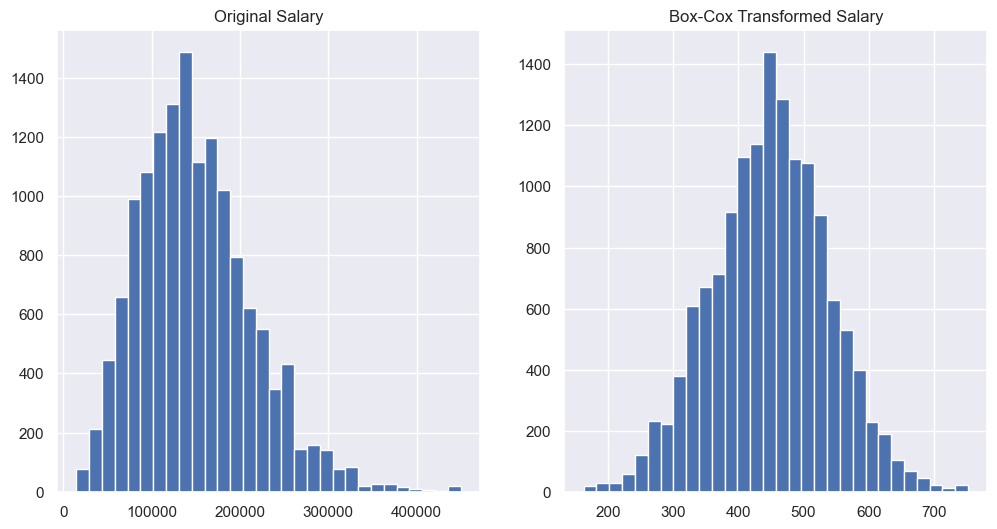

Normal test: NormaltestResult(statistic=1.1650279657294993, pvalue=0.5584925594937046)
Shapiro-Wilk test: ShapiroResult(statistic=0.999191403388977, pvalue=2.274209464303567e-06)
Kolmogorov-Smirnov test: KstestResult(statistic=1.0, pvalue=0.0, statistic_location=162.62856373902414, statistic_sign=-1)


In [31]:
# fit the lambda and transform the train dependent variable
new_X['transformed_salary'], lmbda = boxcox(new_X['salary_in_usd'])
print(f'Best Lambda Value: {lmbda:.4f}')

# plot

plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 2, 1)
plt.hist(new_X['salary_in_usd'], bins=30)
plt.title('Original Salary')

# Transformed
plt.subplot(1, 2, 2)
plt.hist(new_X['transformed_salary'], bins=30)
plt.title('Box-Cox Transformed Salary')

plt.show()

print('Normal test:', normaltest(new_X['transformed_salary']))
print('Shapiro-Wilk test:', shapiro(new_X['transformed_salary']))
print('Kolmogorov-Smirnov test:', kstest(new_X['transformed_salary'], "norm"))

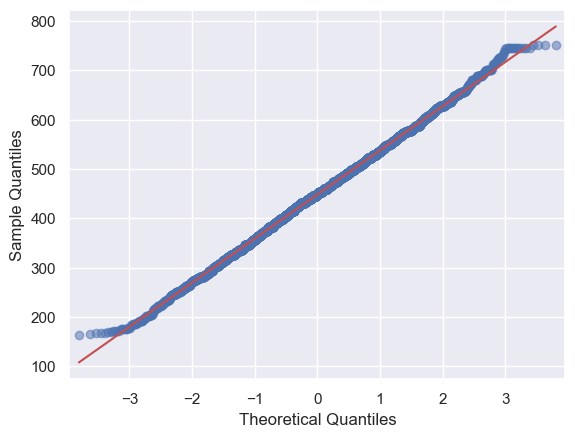

In [32]:
sm.qqplot(new_X['transformed_salary'], line='s', alpha=0.5)
plt.show()

# DATA DESCRIPTION

work_year
2023    8512
2024    4006
2022    1652
2021     218
2020      75
Name: count, dtype: int64


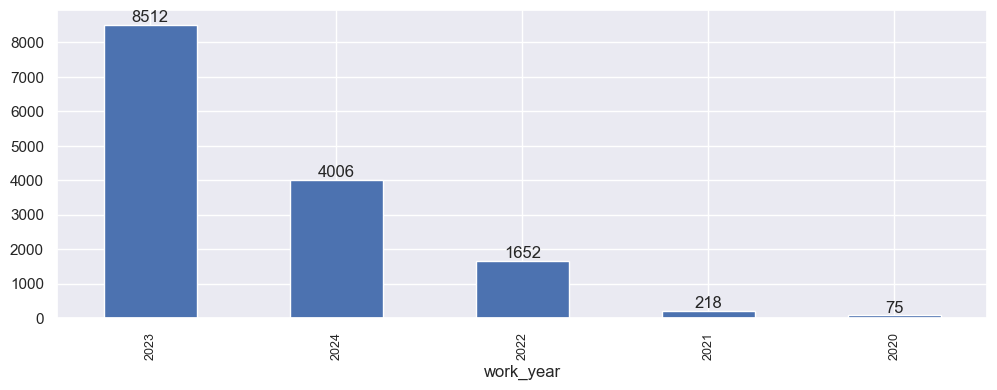

experience_level
SE    9489
MI    3429
EN    1117
EX     428
Name: count, dtype: int64


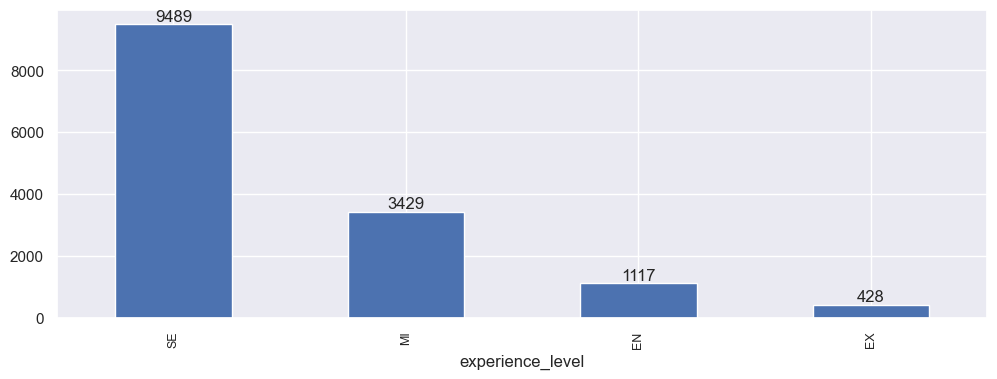

employment_type
FT    14400
CT       26
PT       24
FL       13
Name: count, dtype: int64


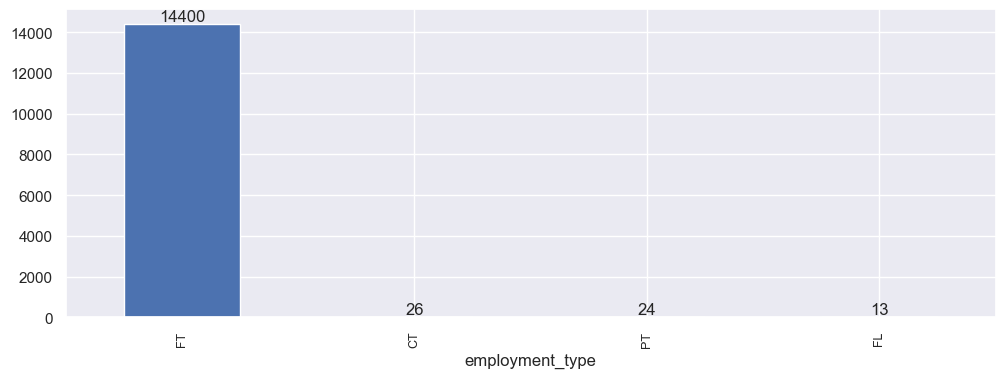

salary_currency
USD    13328
GBP      549
EUR      423
INR       53
CAD       51
AUD       12
PLN        7
CHF        6
SGD        6
JPY        4
BRL        4
DKK        3
HUF        3
TRY        3
NOK        2
THB        2
ZAR        1
HKD        1
ILS        1
PHP        1
NZD        1
MXN        1
CLP        1
Name: count, dtype: int64


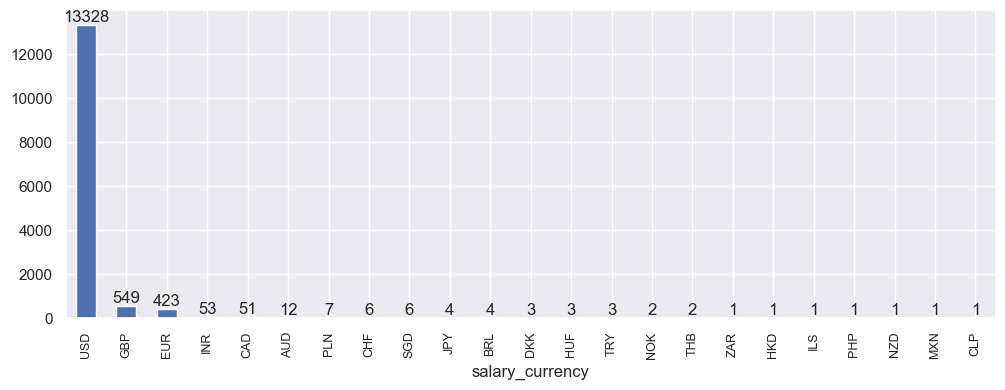

employee_residence
US    12593
GB      627
CA      377
ES      131
DE       90
      ...  
QA        1
MU        1
OM        1
UG        1
LU        1
Name: count, Length: 88, dtype: int64


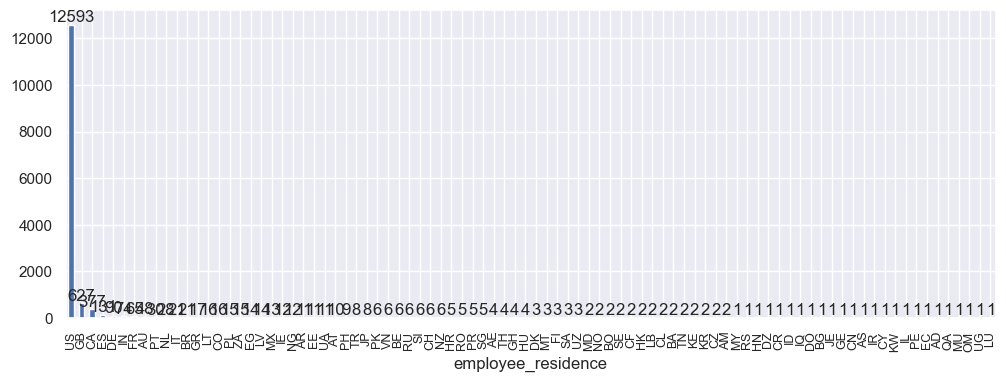

remote_ratio
On_Site    9567
Remote     4650
Hybrid      246
Name: count, dtype: int64


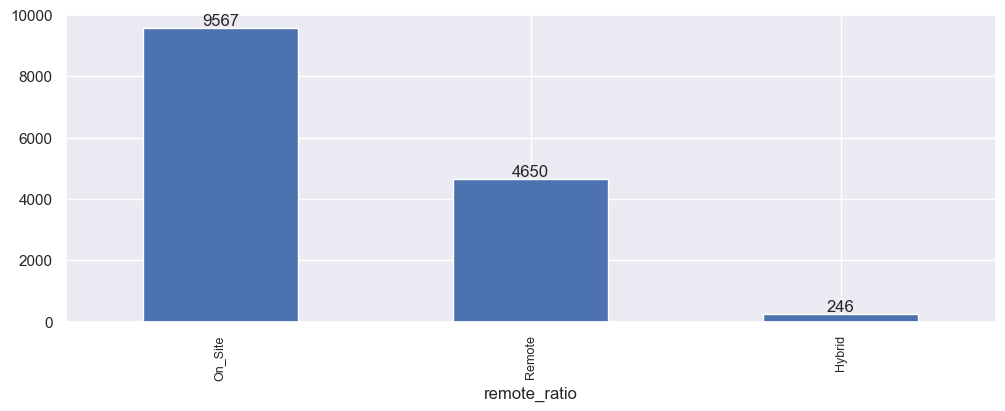

company_location
US    12642
GB      635
CA      379
ES      127
DE       97
      ...  
MU        1
AM        1
QA        1
AD        1
MD        1
Name: count, Length: 77, dtype: int64


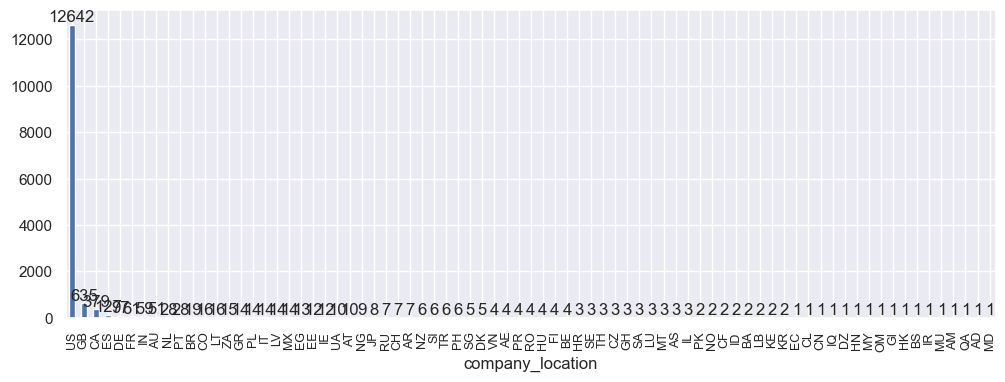

company_size
M    13315
L      968
S      180
Name: count, dtype: int64


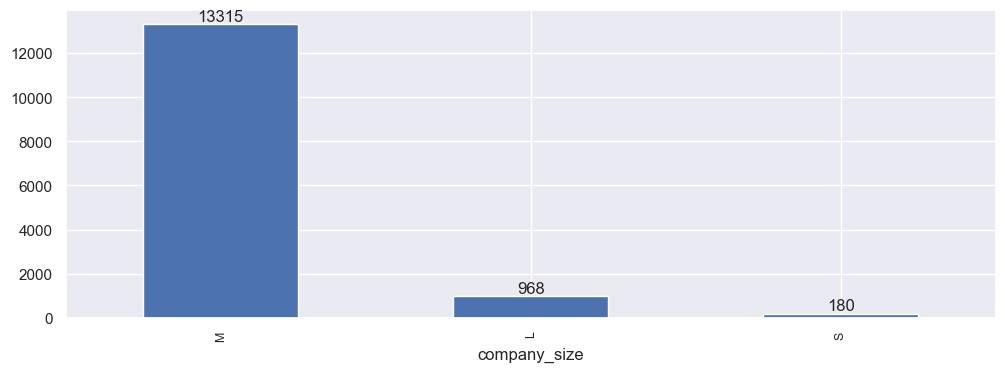

In [33]:
# Quick chart view of the raw base counts for all categorical columns
plt.rc('xtick', labelsize=9)
for col in ['work_year'] + categorical_columns:
    print(aijobs[col].value_counts())
    ax = aijobs[col].value_counts().plot(kind='bar', figsize=(12, 4))
    ax.bar_label(ax.containers[0])
    plt.show()
plt.rc('xtick', labelsize=12) #resetting it for the next plots

In [34]:
# definition for plotting all post treatment dummies' counts, averages and deviation of target variable

def plotting(var):
    usd = new_X.groupby(var)['salary_in_usd']
    box = new_X.groupby(var)['transformed_salary']

    fig, ax = plt.subplots(layout='constrained', figsize=(12, 4))
    ax.remove()

    ax1 = plt.subplot(1, 2, 1)
    rects = ax1.bar(1, usd.mean()[1].astype(int), 0.8, yerr=usd.std()[1].astype(int), color='mediumturquoise')
    ax1.bar_label(rects, label_type='center')
    rects = ax1.bar(2, usd.mean()[0].astype(int), 0.8, yerr=usd.std()[0].astype(int), color='salmon')
    ax1.bar_label(rects, label_type='center')
    ax1.set_xticks([1, 2], [var, 'not ' + var])
    ax1.set_title('Salary in USD')

    ax2 = plt.subplot(1, 2, 2)
    rects = ax2.bar(1, box.mean()[1].astype(int), 0.8, yerr=box.std()[1].astype(int), color='mediumaquamarine')
    ax2.bar_label(rects, label_type='center')
    rects = ax2.bar(2, box.mean()[0].astype(int), 0.8, yerr=box.std()[0].astype(int), color='lightcoral')
    ax2.bar_label(rects, label_type='center')
    ax2.set_xticks([1, 2], [var, 'not ' + var])
    ax2.set_title('Transformed Salary')

    plt.show()

In [40]:
avg = new_X[['transformed_salary']].mean()[0]
avg

448.49164931935564

salary_in_usd              transformed_salary     
                   mean    std count               mean  std
work_year                                                   
2020             107839  84984    63                373  119
2021             107461  68681   179                376  109
2022             135837  57094  1614                428   86
2023             153995  63032  8437                454   86
2024             149397  67722  3983                447   91

salary_in_usd               transformed_salary     
                     mean    std  count               mean  std
work_abroad                                                    
0                  150177  64276  14213                449   89
1                   81138  57509     63                330  100

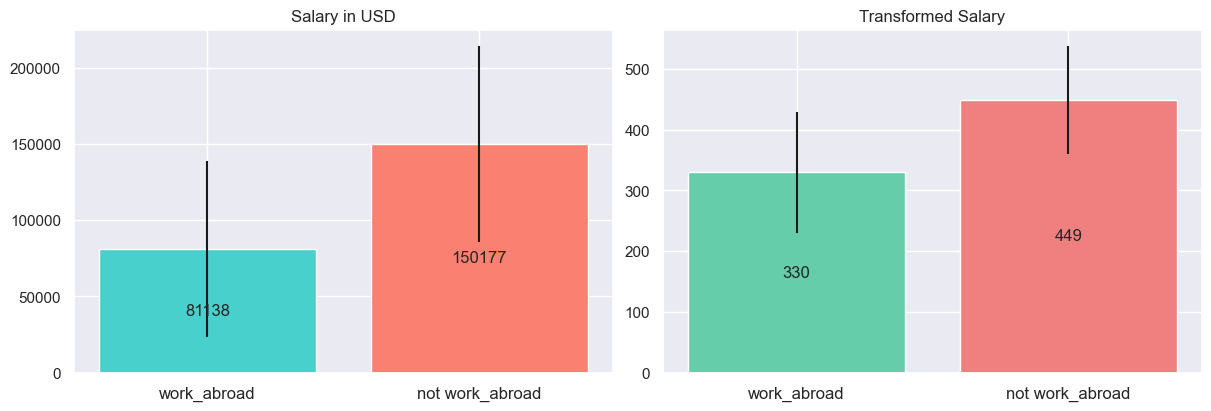

salary_in_usd               transformed_salary     
                     mean    std  count               mean  std
job_name_AI                                                    
0                  149643  64108  14111                448   89
1                  169470  84349    165                468  113

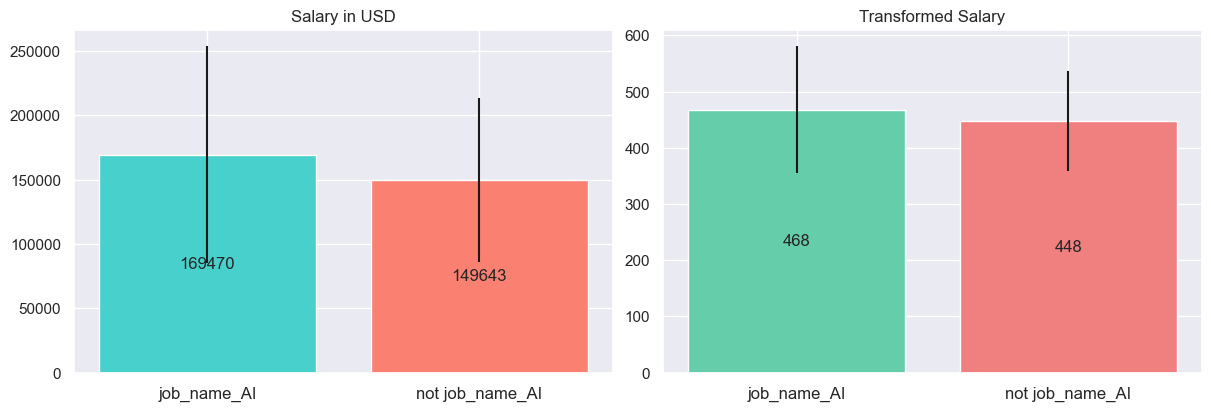

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Analyst                                                   
0                       159144  64453  11731                461  87
1                       107136  43595   2545                386  71

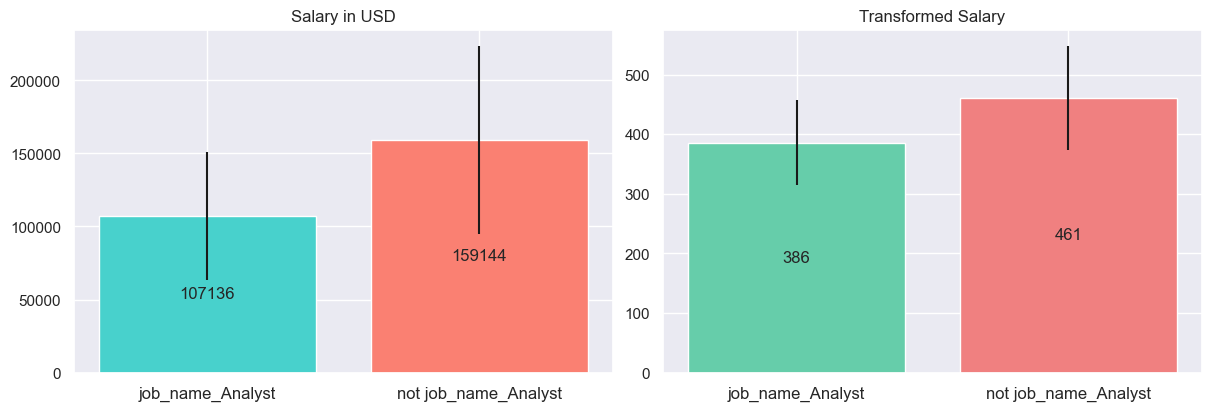

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
job_name_Analytics                                                   
0                         149793  64616  13801                448  89
1                         152167  58085    475                454  75

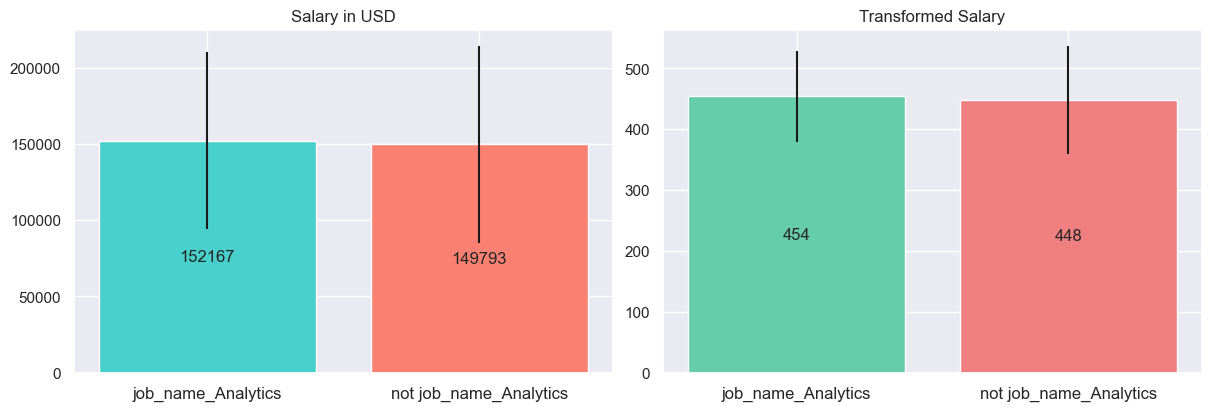

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Applied                                                   
0                       148842  64262  13880                447  89
1                       185994  58985    396                498  77

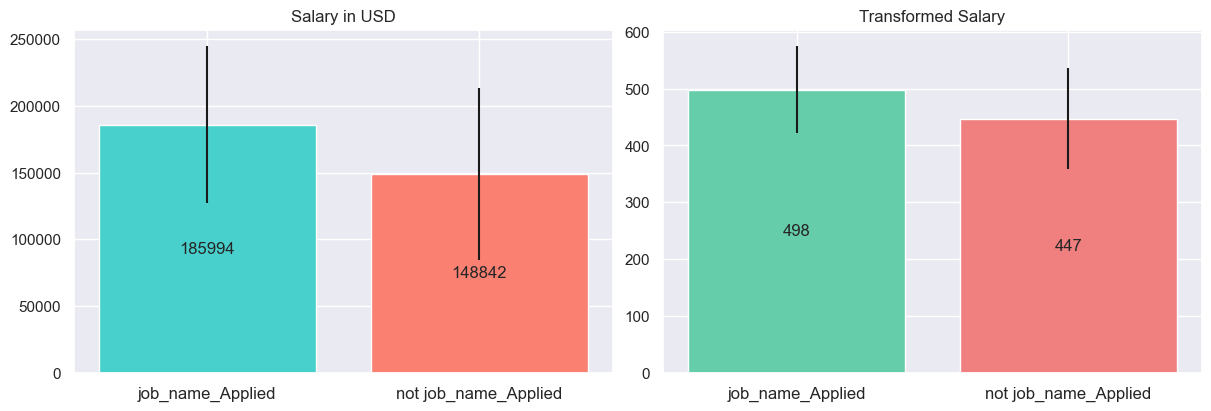

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
job_name_Architect                                                   
0                         149359  64355  13890                447  89
1                         168364  63714    386                475  79

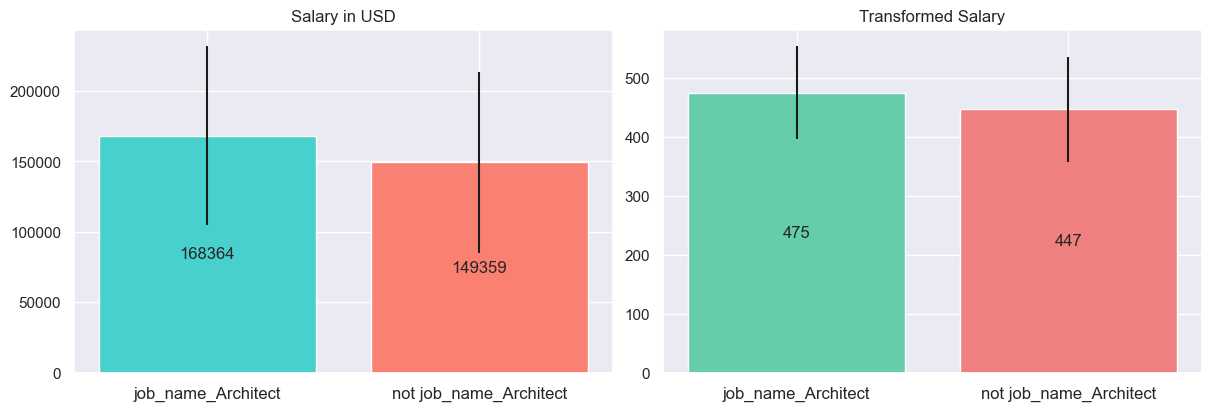

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
job_name_Associate                                                   
0                         149901  64401  14271                448  89
1                          67319  15618      5                318  32

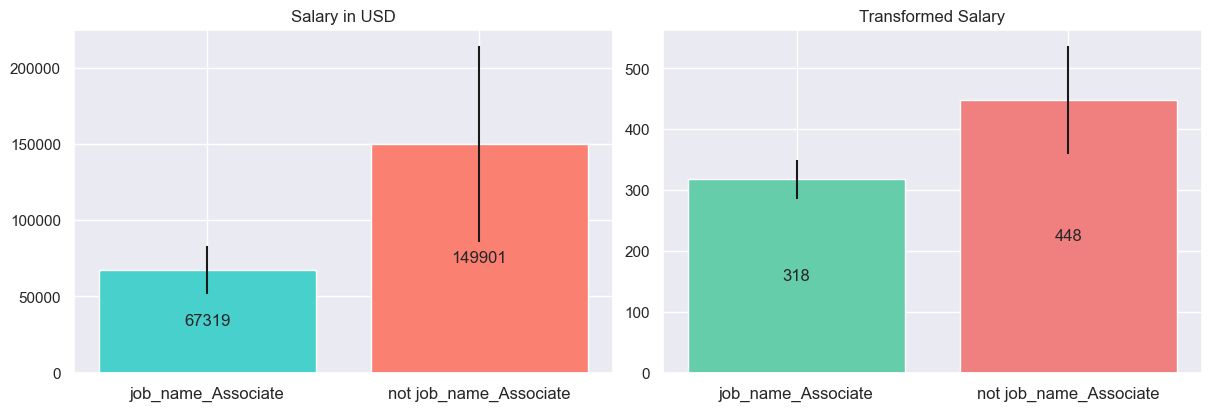

salary_in_usd               transformed_salary     
                      mean    std  count               mean  std
job_name_Big                                                    
0                   149931  64387  14264                448   89
1                    79793  53002     12                324  113

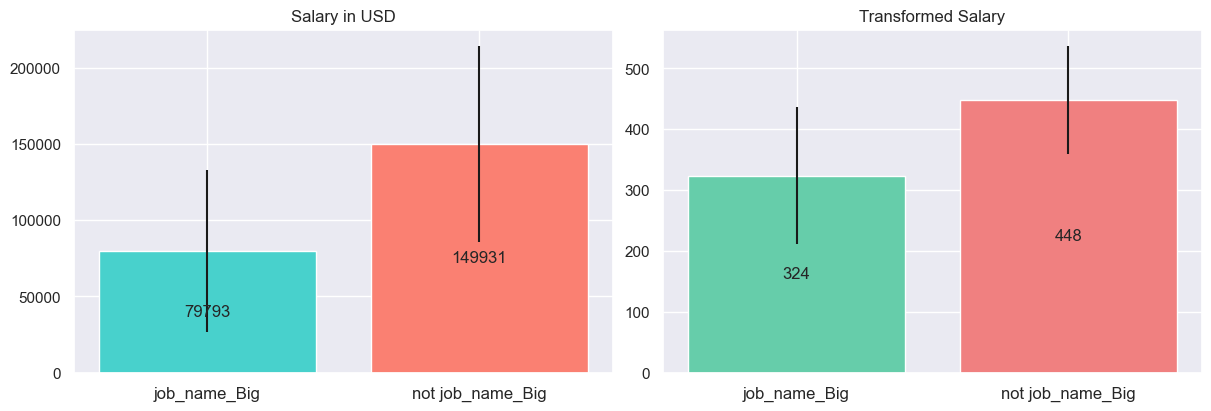

salary_in_usd               transformed_salary    
                           mean    std  count               mean std
job_name_Database                                                   
0                        149878  64429  14263                448  89
1                        143538  37756     13                446  54

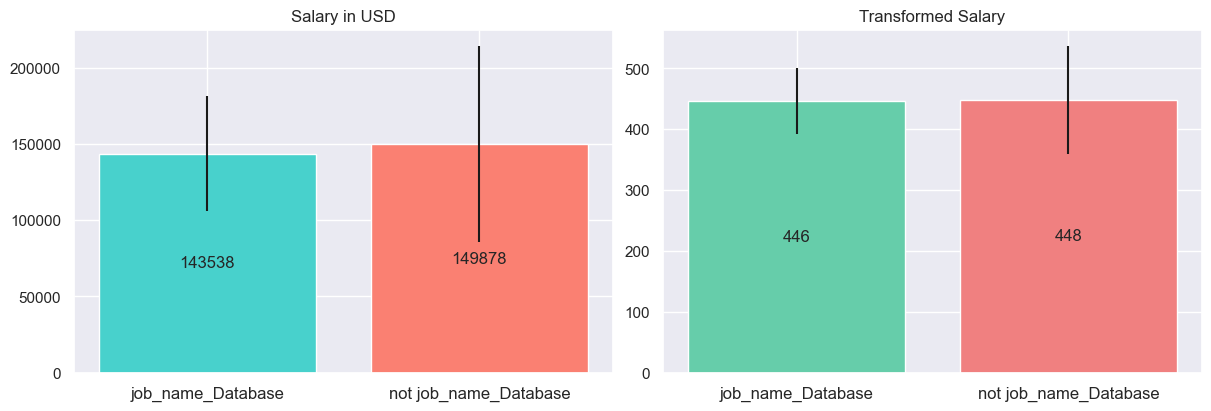

salary_in_usd               transformed_salary    
                           mean    std  count               mean std
job_name_Decision                                                   
0                        149829  64469  14238                448  89
1                        166094  31969     38                478  41

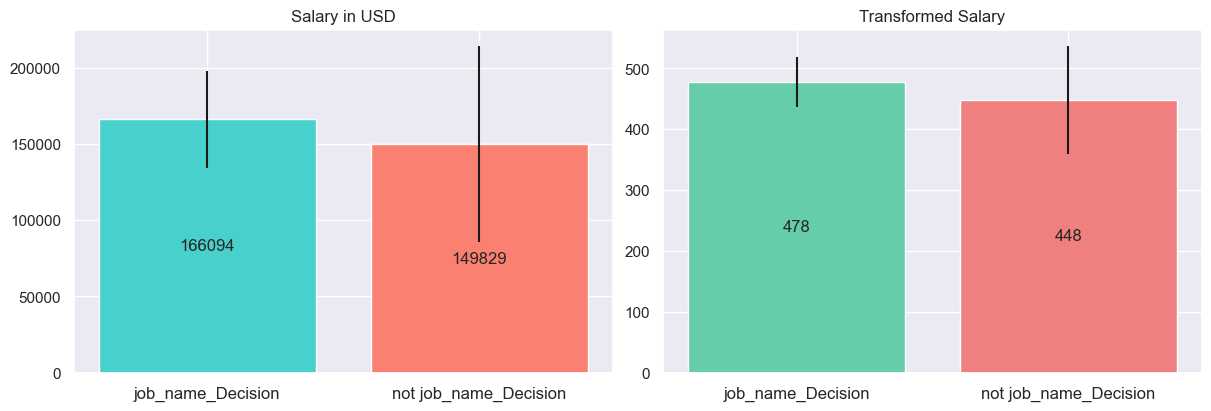

salary_in_usd                transformed_salary     
                       mean     std  count               mean  std
job_name_Deep                                                     
0                    149840   64359  14263                448   89
1                    185681  103900     13                486  129

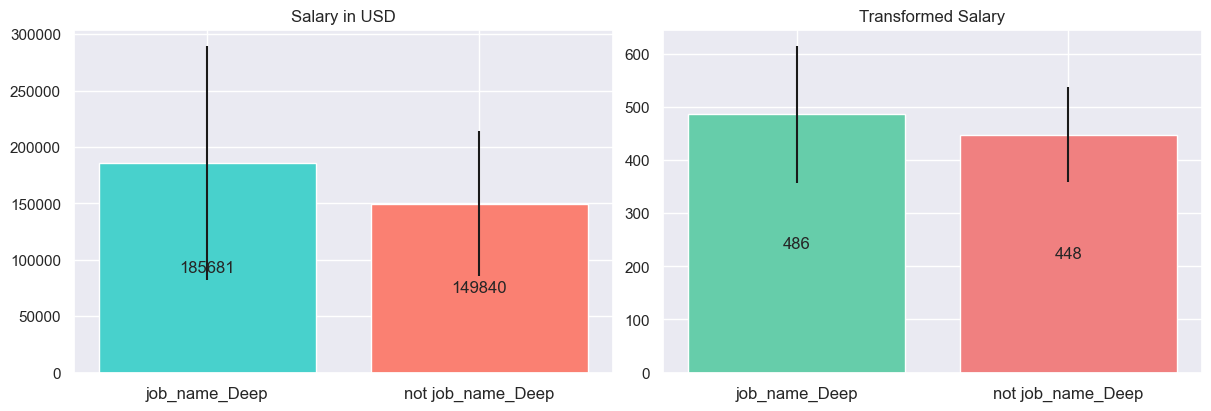

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
job_name_Developer                                                   
0                         150469  64459  14067                449  89
1                         109746  45764    209                390  72

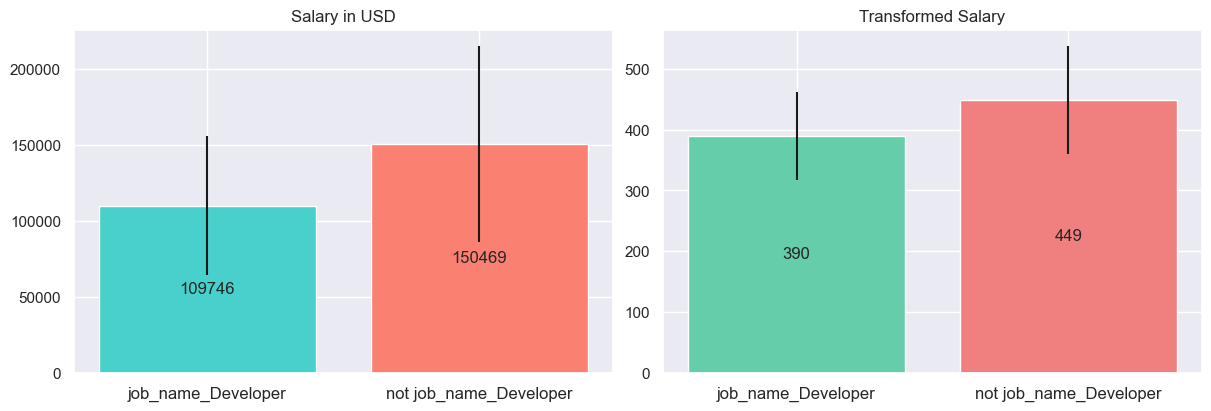

salary_in_usd               transformed_salary    
                           mean    std  count               mean std
job_name_Director                                                   
0                        149680  64296  14234                448  89
1                        215021  70399     42                532  82

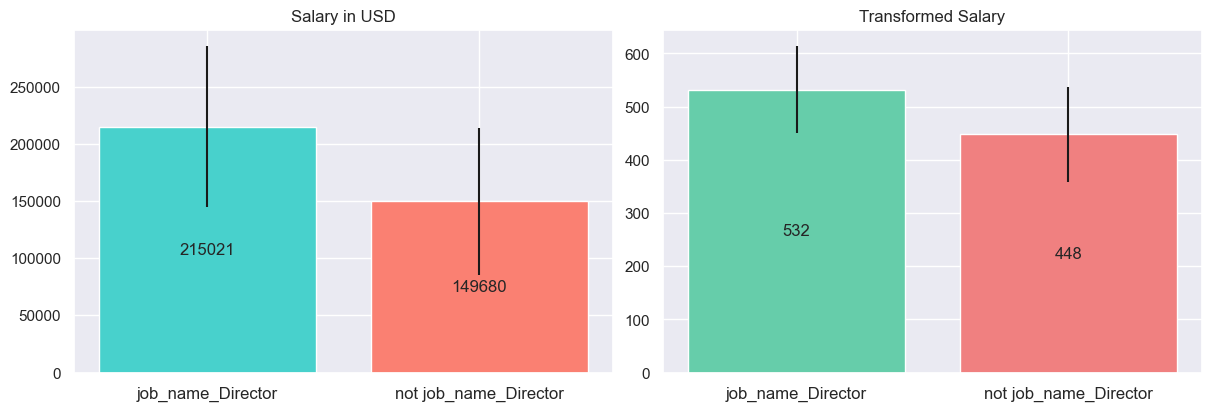

salary_in_usd               transformed_salary    
                      mean    std  count               mean std
job_name_ETL                                                   
0                   149930  64402  14249                448  89
1                   119466  61845     27                402  92

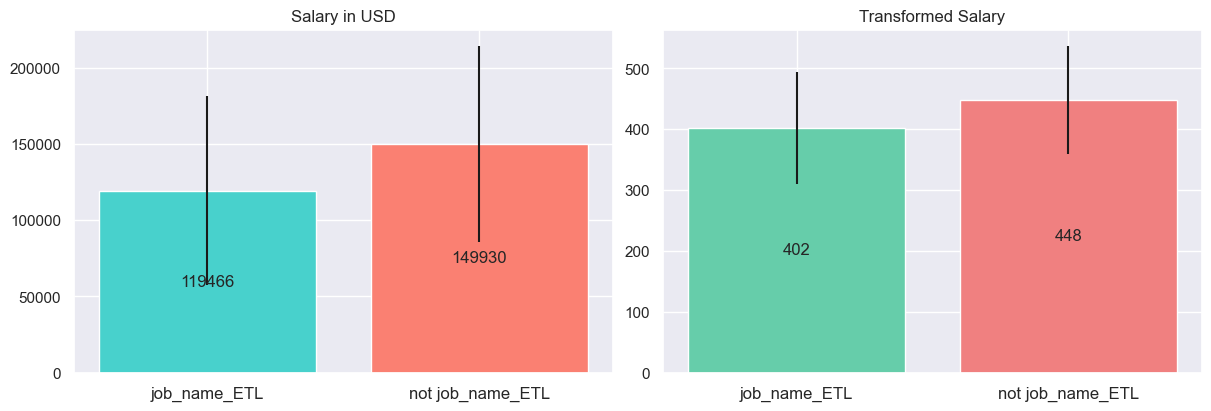

salary_in_usd               transformed_salary     
                       mean    std  count               mean  std
job_name_Head                                                    
0                    149572  64137  14211                448   89
1                    215609  87077     65                528  104

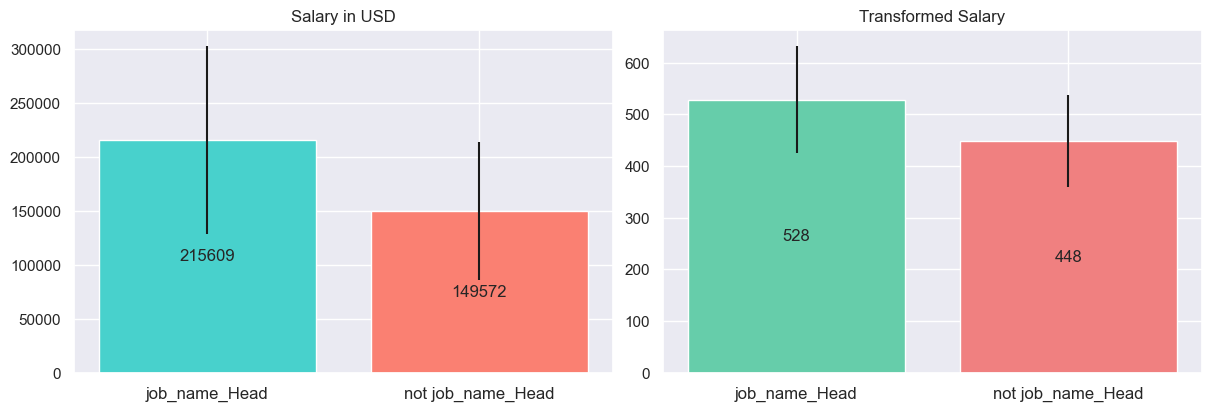

salary_in_usd               transformed_salary    
                                 mean    std  count               mean std
job_name_Infrastructure                                                   
0                              149780  64384  14229                448  89
1                              177901  66703     47                487  82

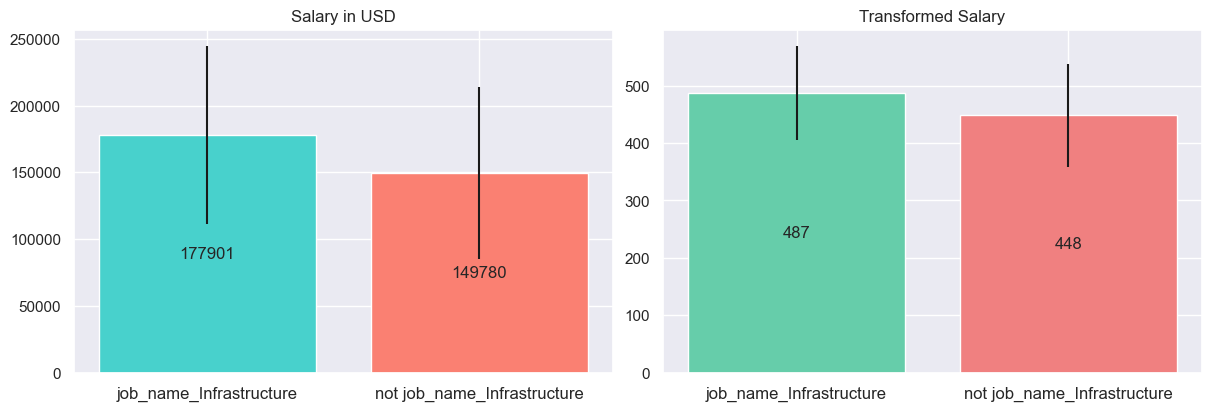

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Insight                                                   
0                       149959  64366  14264                448  89
1                        46459   7158     12                270  19

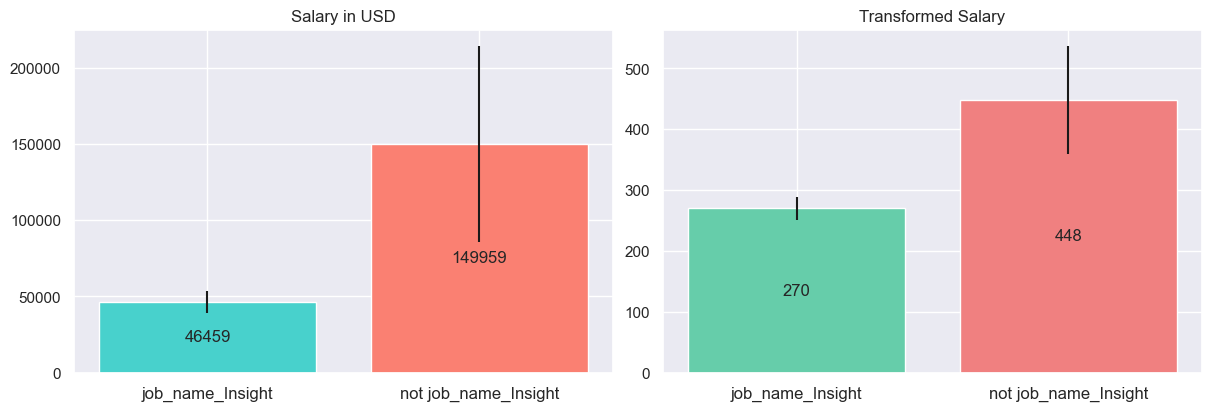

salary_in_usd               transformed_salary    
                              mean    std  count               mean std
job_name_Integration                                                   
0                           149977  64419  14237                448  89
1                           111571  47422     39                393  75

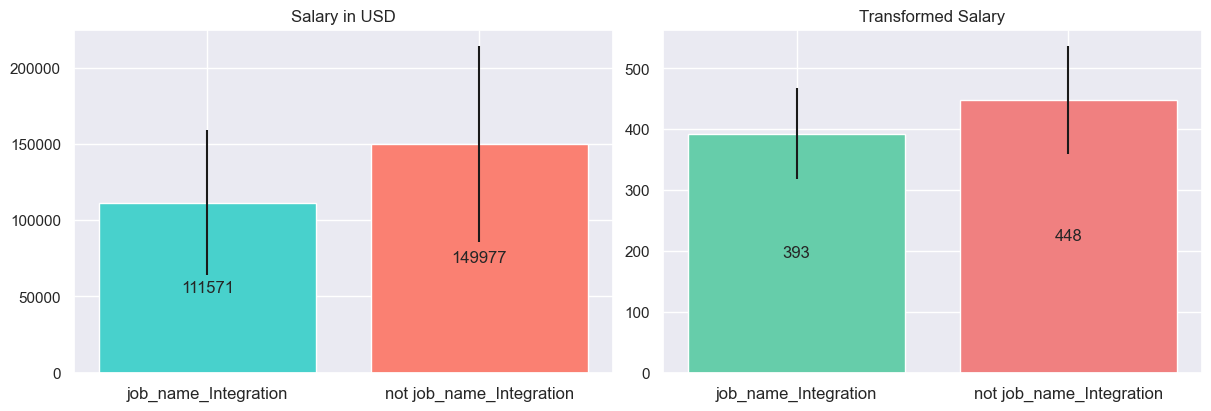

salary_in_usd               transformed_salary     
                       mean    std  count               mean  std
job_name_Lead                                                    
0                    149830  64252  14179                448   89
1                    156099  84432     97                449  116

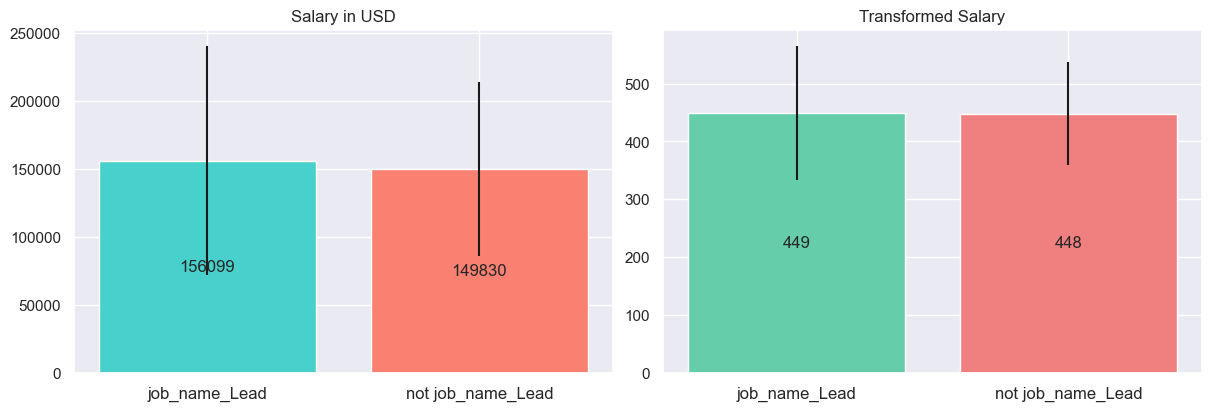

salary_in_usd               transformed_salary     
                      mean    std  count               mean  std
job_name_NLP                                                    
0                   149893  64394  14261                448   89
1                   130002  77349     15                411  118

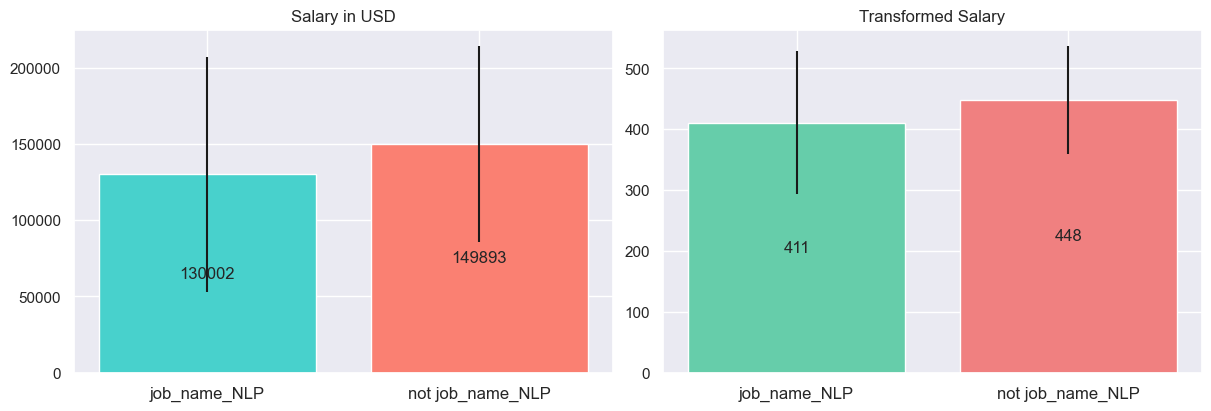

salary_in_usd               transformed_salary    
                      mean    std  count               mean std
job_name_Ops                                                   
0                   149892  64420  14253                448  89
1                   137904  57511     23                432  84

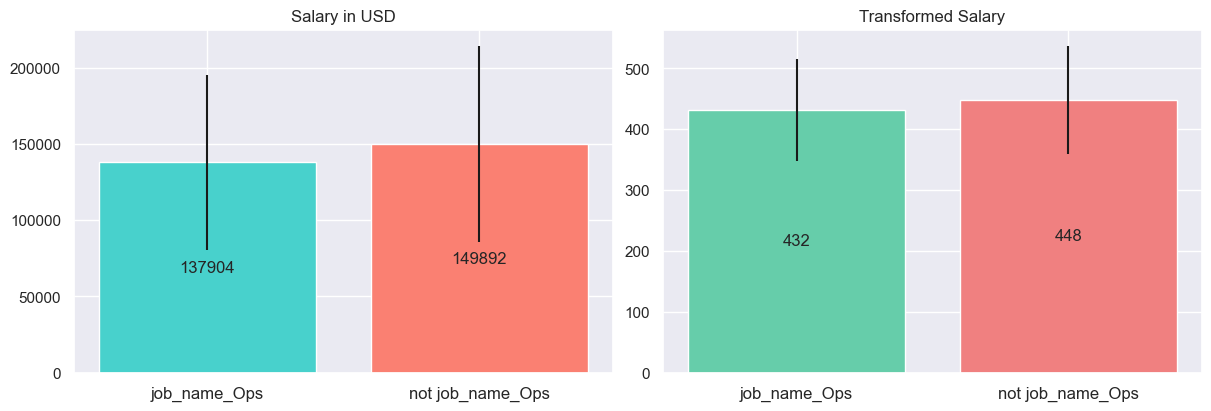

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
job_name_Practitioner                                                   
0                            149891  64426  14260                448  89
1                            133650  45759     16                430  68

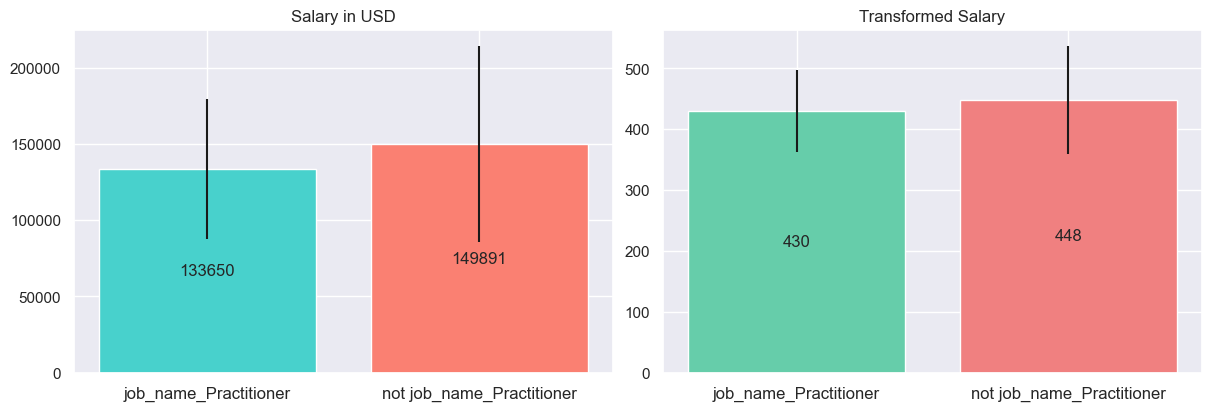

salary_in_usd               transformed_salary     
                            mean    std  count               mean  std
job_name_Principal                                                    
0                         149848  64386  14258                448   89
1                         169490  80500     18                472  102

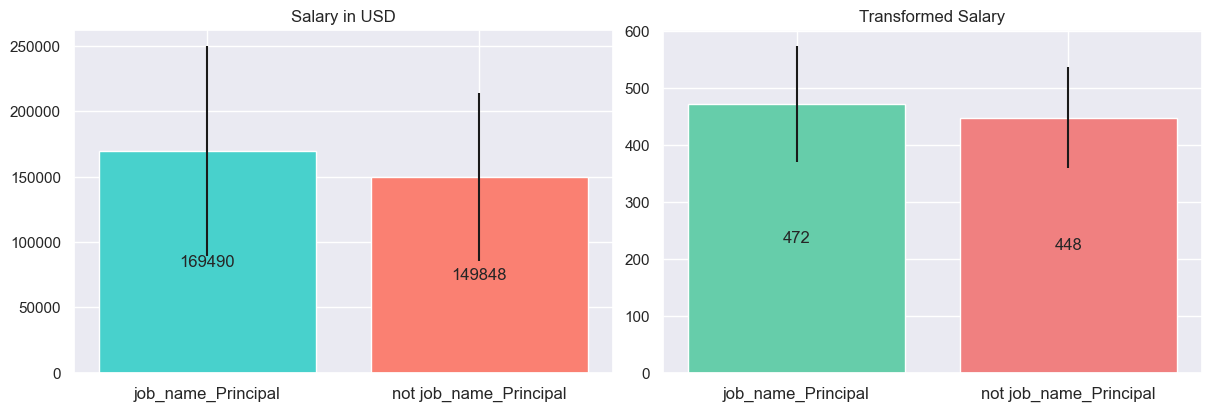

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Product                                                   
0                       149872  64447  14239                448  89
1                       150021  48119     37                452  75

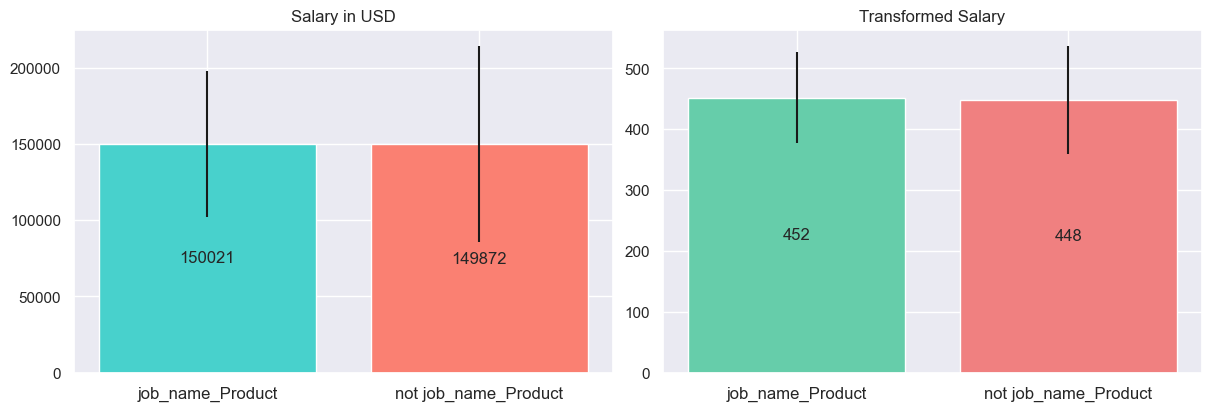

salary_in_usd               transformed_salary    
                         mean    std  count               mean std
job_name_Prompt                                                   
0                      149845  64410  14262                448  89
1                      177937  58683     14                488  79

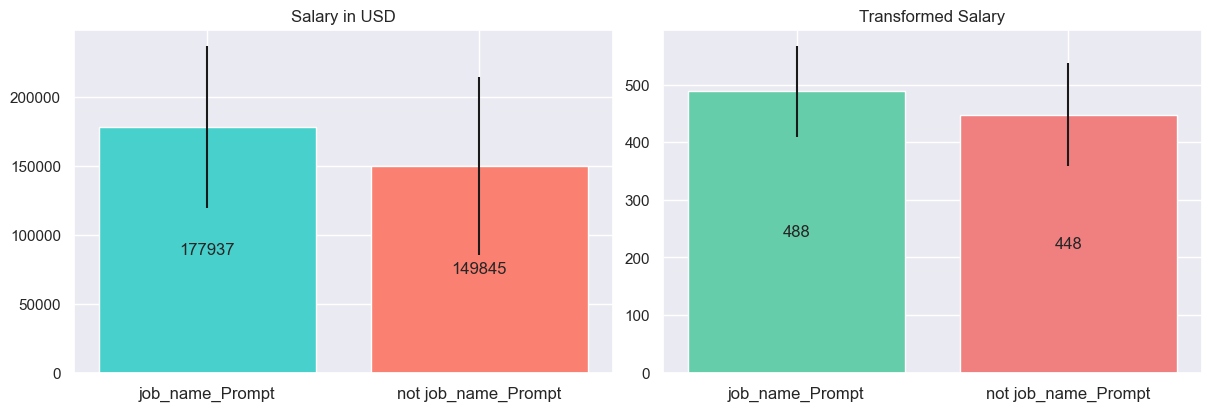

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Quality                                                   
0                       150003  64386  14247                448  89
1                        85532  39020     29                347  72

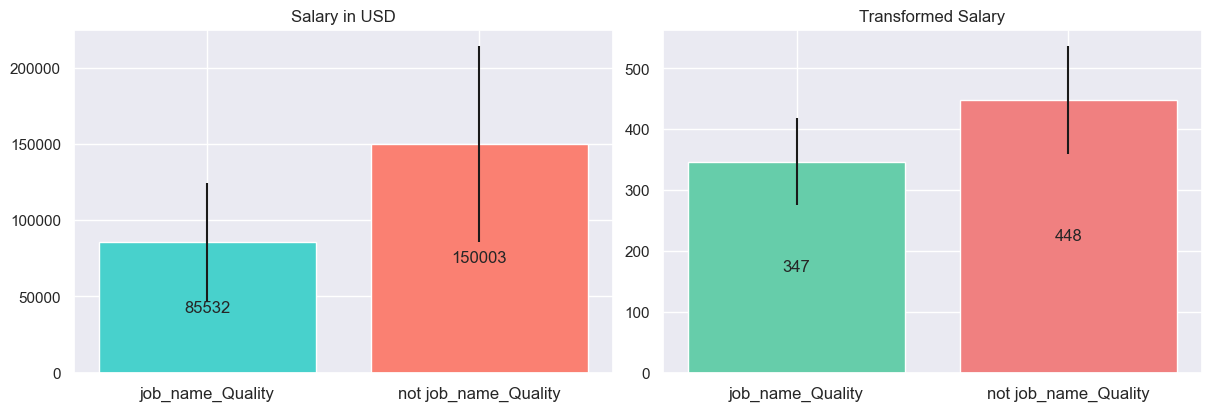

salary_in_usd               transformed_salary    
                           mean    std  count               mean std
job_name_Robotics                                                   
0                        149858  64414  14262                448  89
1                        165071  59157     14                471  80

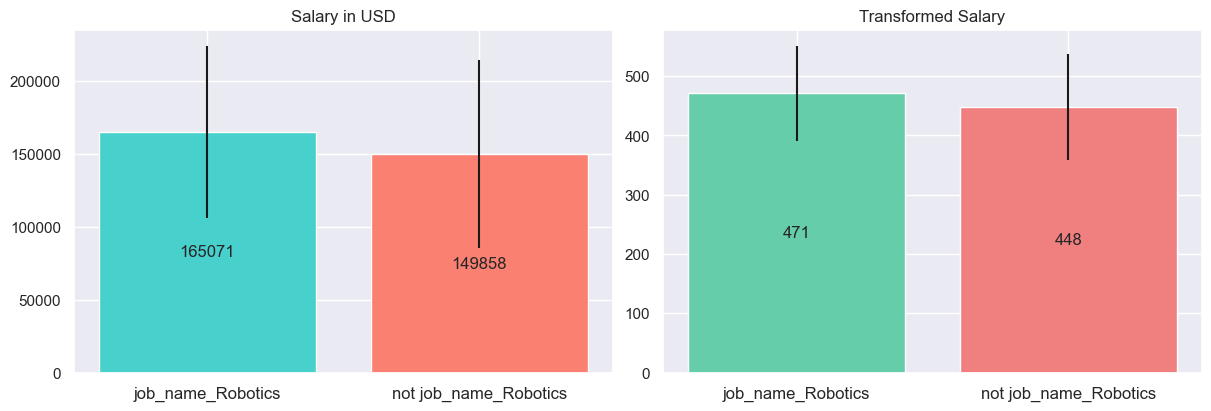

salary_in_usd               transformed_salary     
                           mean    std  count               mean  std
job_name_Software                                                    
0                        149813  64363  14246                448   89
1                        178101  79705     30                481  110

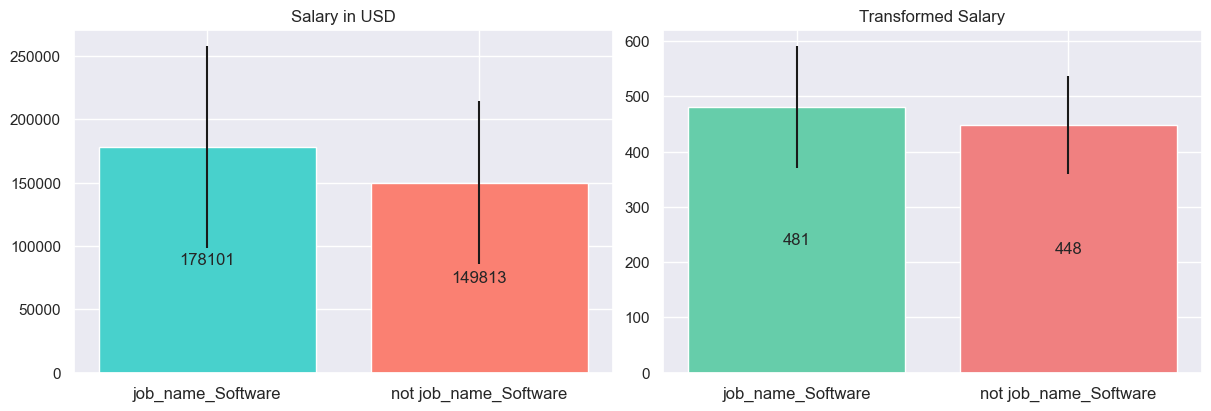

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
job_name_Specialist                                                   
0                          150379  64358  14143                449  89
1                           95970  43862    133                367  70

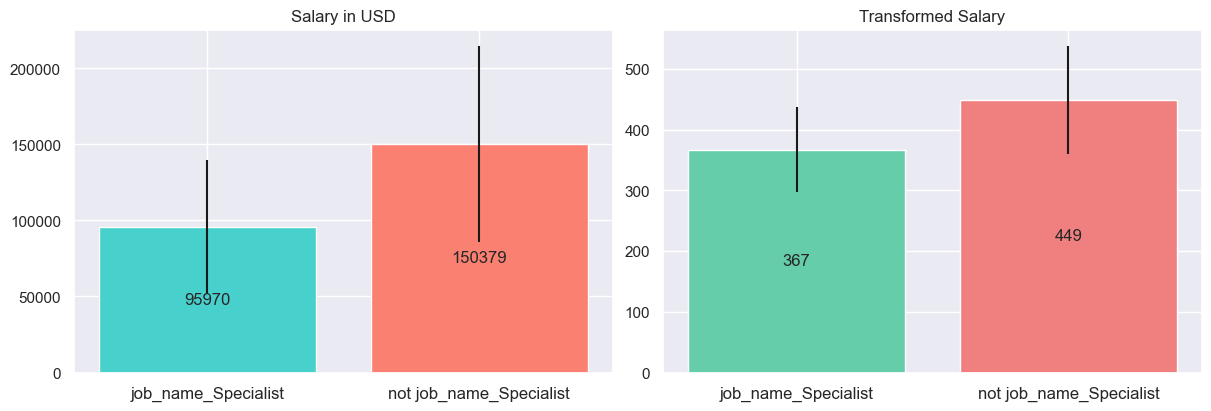

salary_in_usd               transformed_salary     
                        mean    std  count               mean  std
job_name_Staff                                                    
0                     149889  64403  14271                448   89
1                     102750  73459      5                360  144

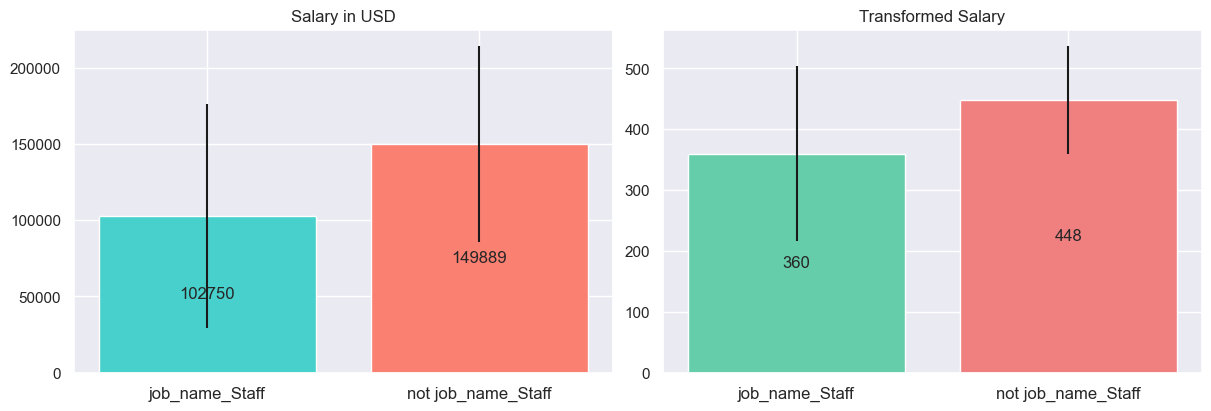

salary_in_usd               transformed_salary     
                         mean    std  count               mean  std
job_name_Vision                                                    
0                      149813  64353  14243                448   89
1                      175390  82702     33                475  120

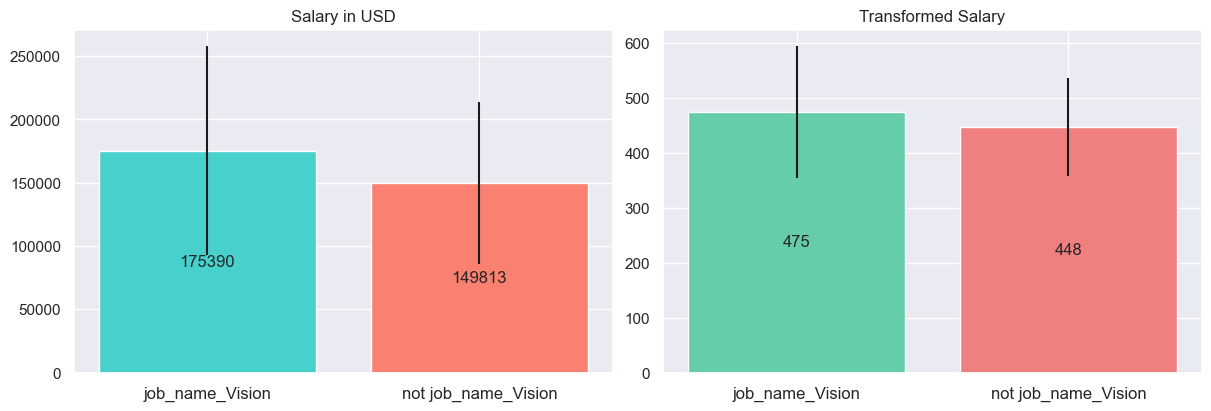

salary_in_usd               transformed_salary    
                                mean    std  count               mean std
job_name_Visualization                                                   
0                             149911  64424  14258                448  89
1                             119144  42584     18                407  67

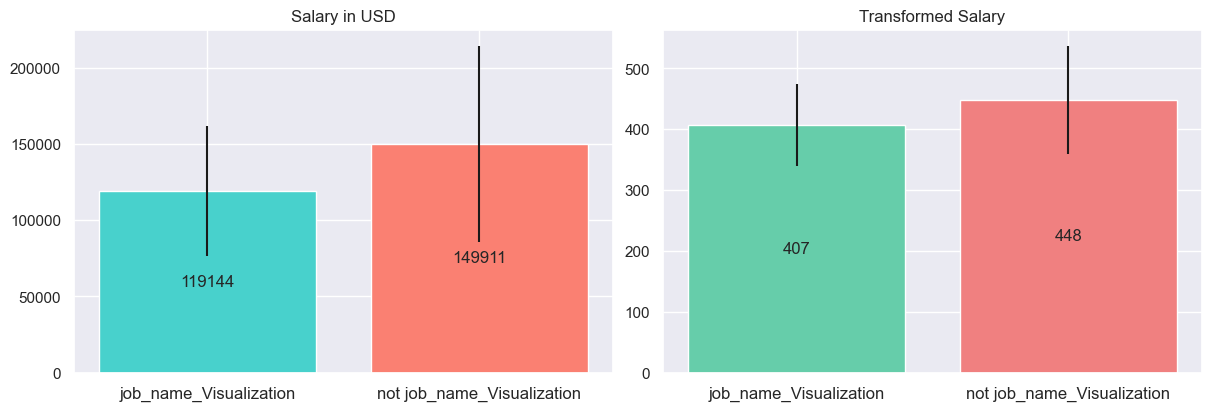

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Machine                                                   
0                       144374  62432  12388                441  87
1                       185948  65547   1888                497  83

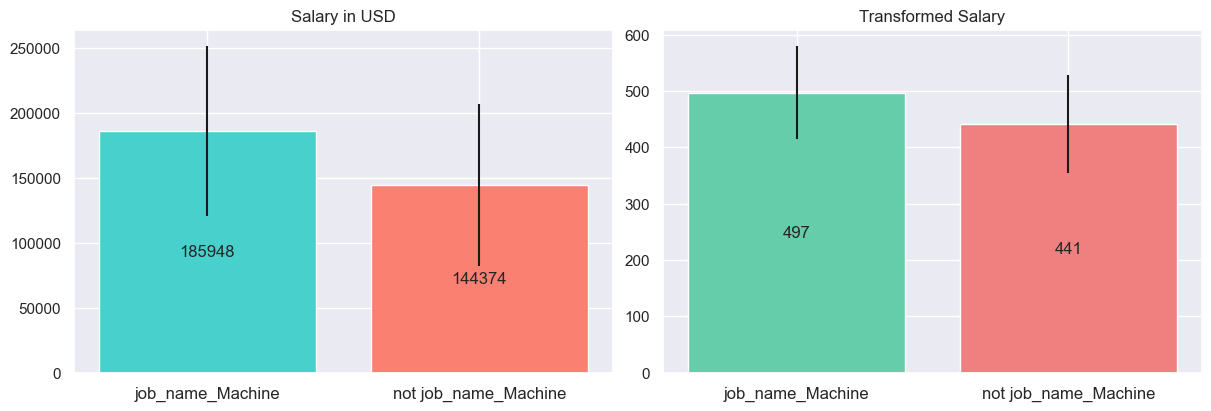

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
job_name_Operations                                                   
0                          150053  64406  14200                448  89
1                          116137  55872     76                398  84

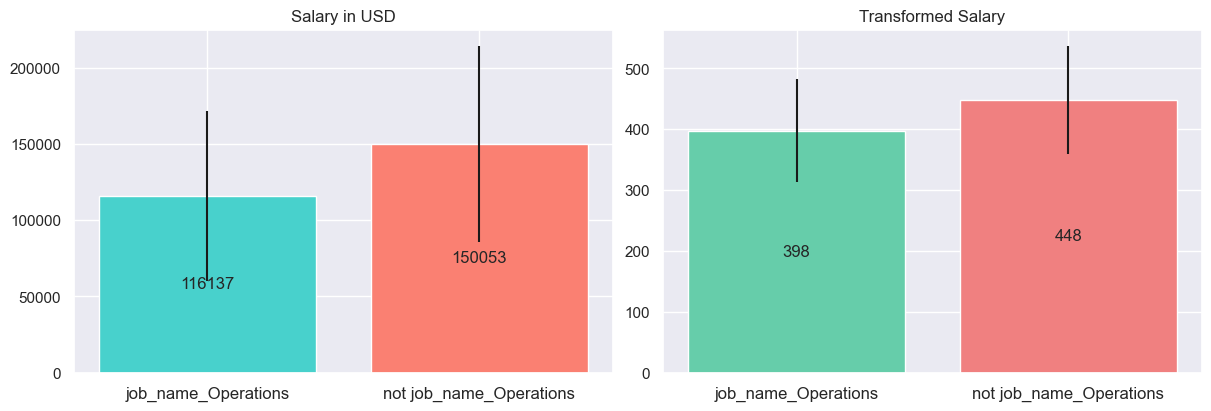

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
job_name_Intelligence                                                   
0                            151064  64724  13660                450  89
1                            123455  50225    616                411  78

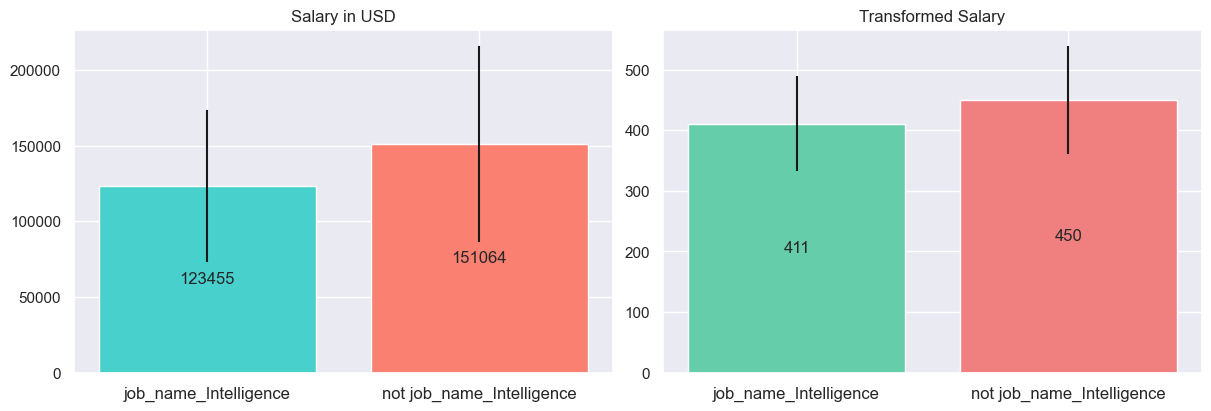

salary_in_usd               transformed_salary    
                           mean    std  count               mean std
job_name_Business                                                   
0                        151138  64701  13645                450  89
1                        122496  50538    631                410  80

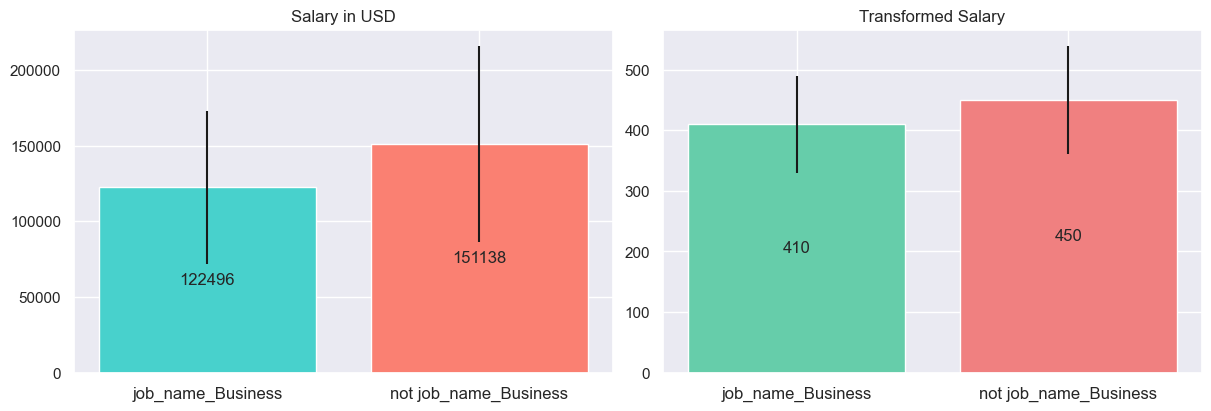

salary_in_usd               transformed_salary    
                        mean    std  count               mean std
job_name_Cloud                                                   
0                     149868  64427  14257                448  89
1                     153219  49975     19                458  67

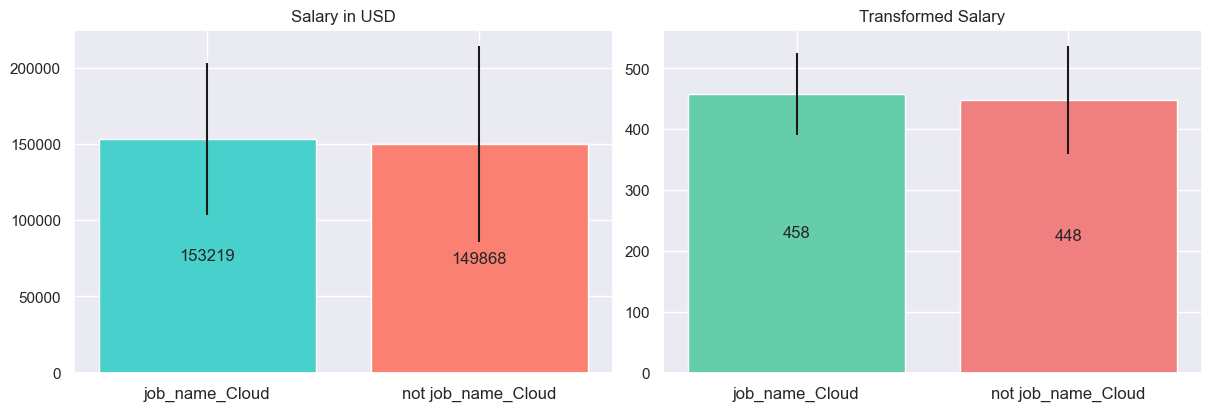

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Modeler                                                   
0                       149944  64463  14228                448  89
1                       128646  41086     48                423  61

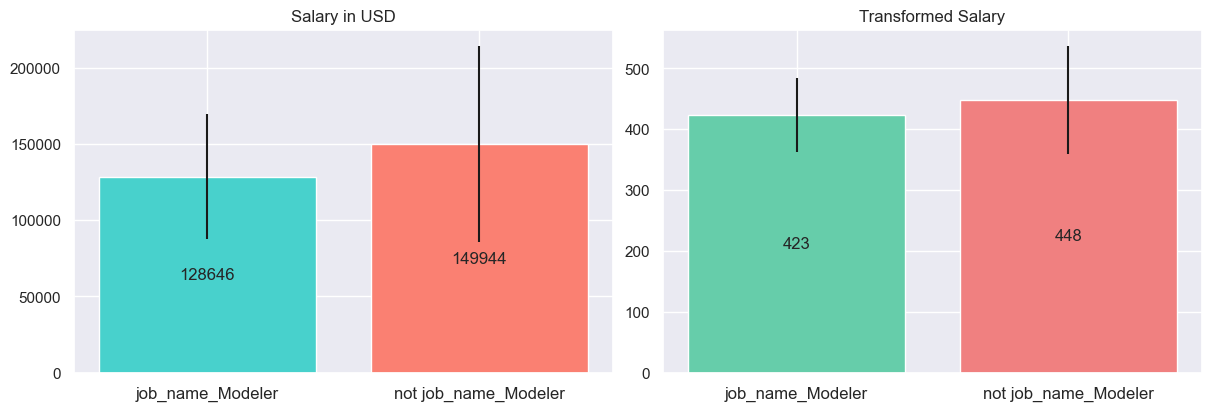

salary_in_usd              transformed_salary    
                           mean    std count               mean std
job_name_Engineer                                                  
0                        141843  63183  8263                436  89
1                        160906  64450  6013                464  86

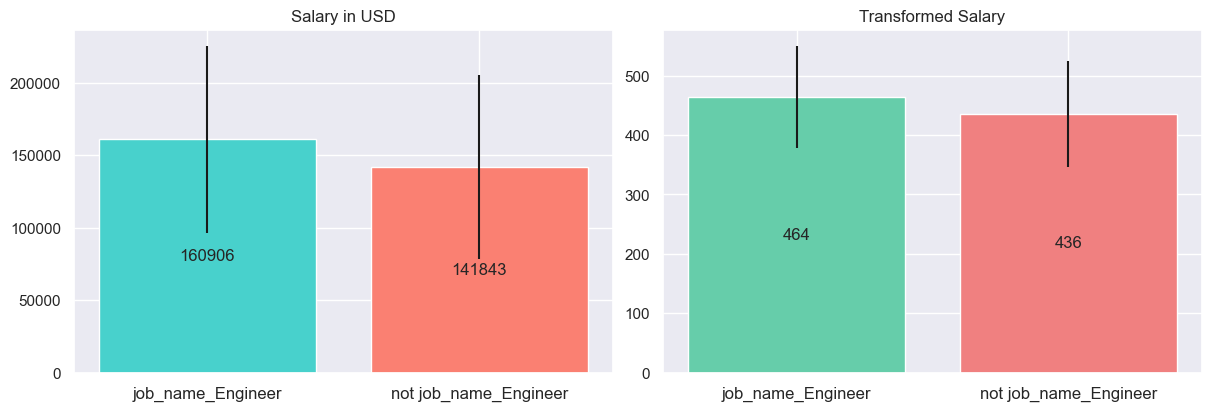

salary_in_usd               transformed_salary     
                          mean    std  count               mean  std
job_name_Finance                                                    
0                       149891  64388  14269                448   89
1                       112471  97906      7                379  132

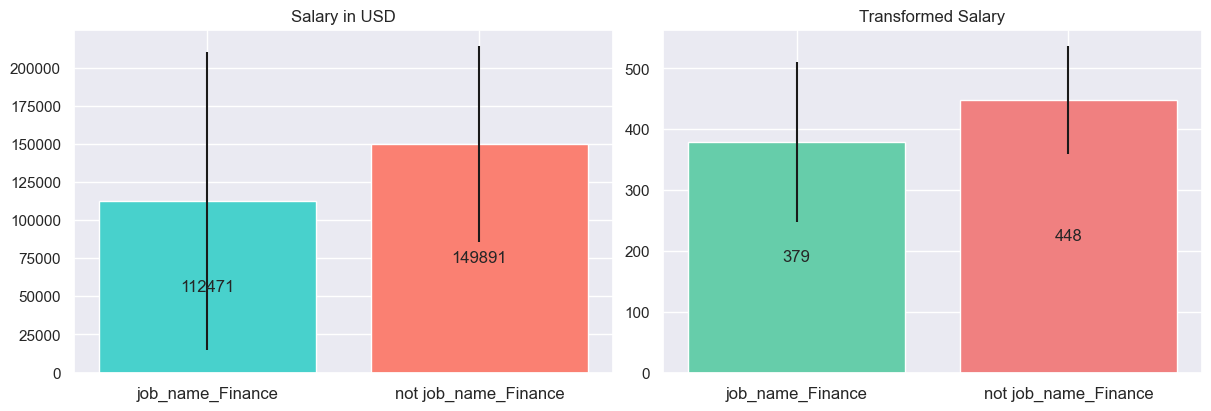

salary_in_usd               transformed_salary     
                           mean    std  count               mean  std
job_name_Research                                                    
0                        148102  62776  13412                446   88
1                        177349  81099    864                482  102

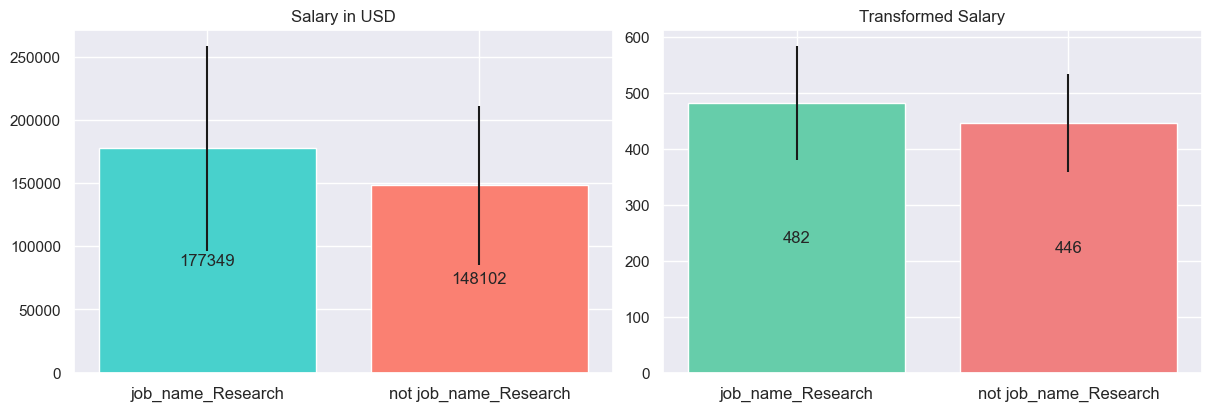

salary_in_usd              transformed_salary    
                            mean    std count               mean std
job_name_Scientist                                                  
0                         144038  63995  9803                440  89
1                         162660  63466  4473                466  86

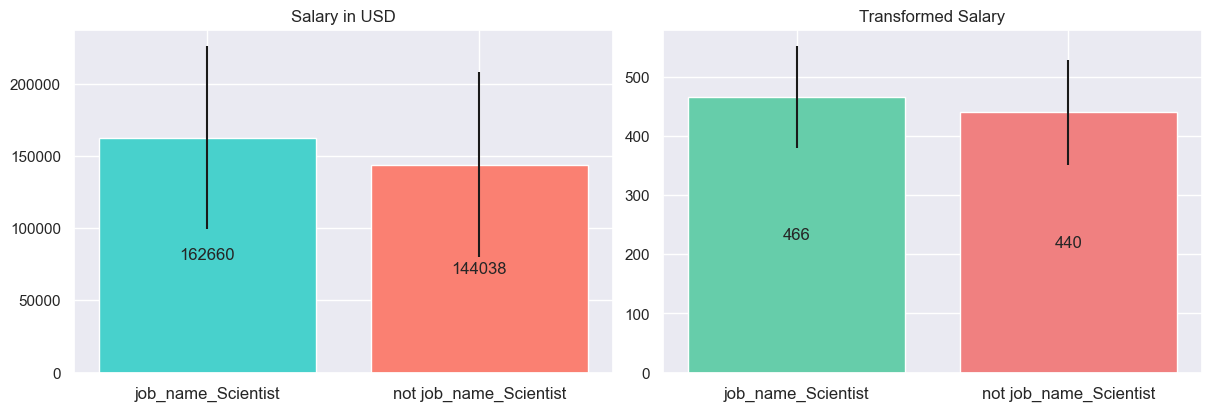

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
job_name_Strategist                                                   
0                          149956  64415  14248                448  89
1                          107593  45466     28                389  64

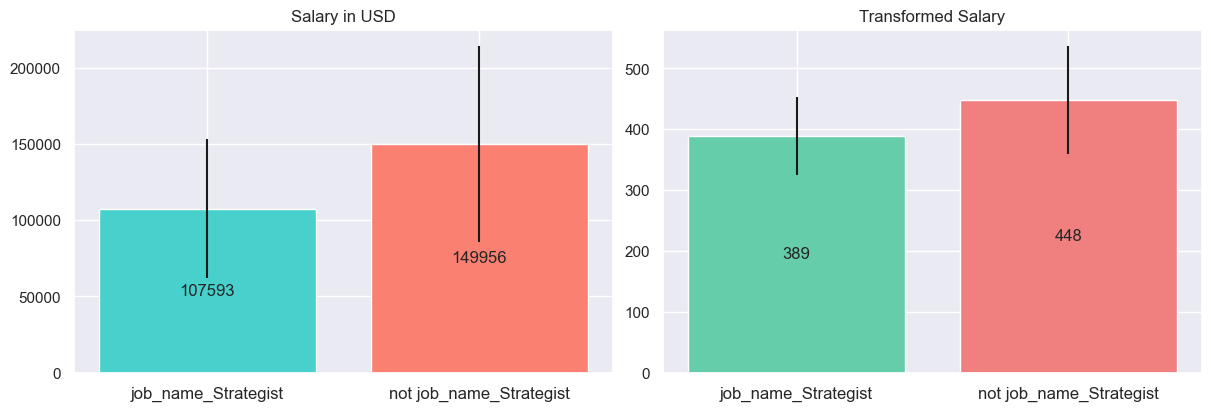

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Manager                                                   
0                       150234  64469  13843                448  89
1                       138317  61423    433                432  85

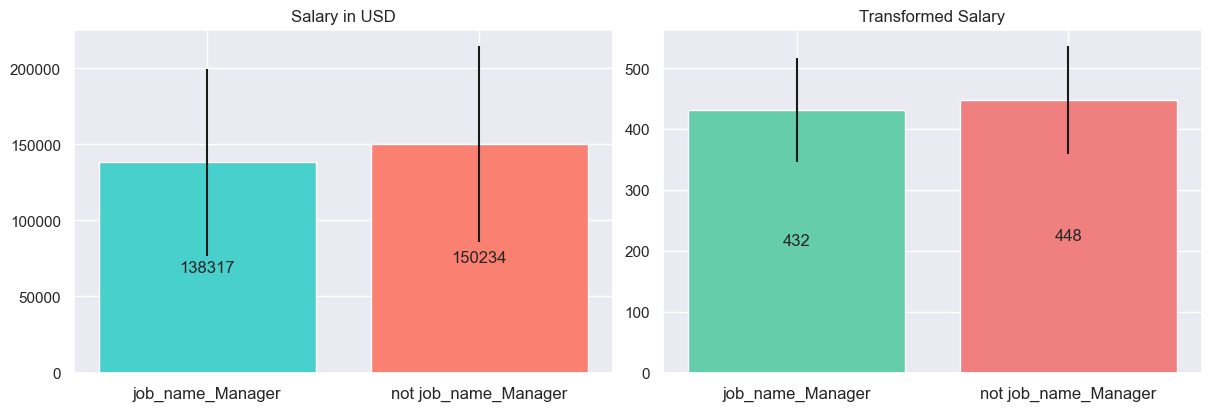

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
experience_level_EN                                                   
0                          154372  63391  13221                455  86
1                           93484  48447   1055                359  83

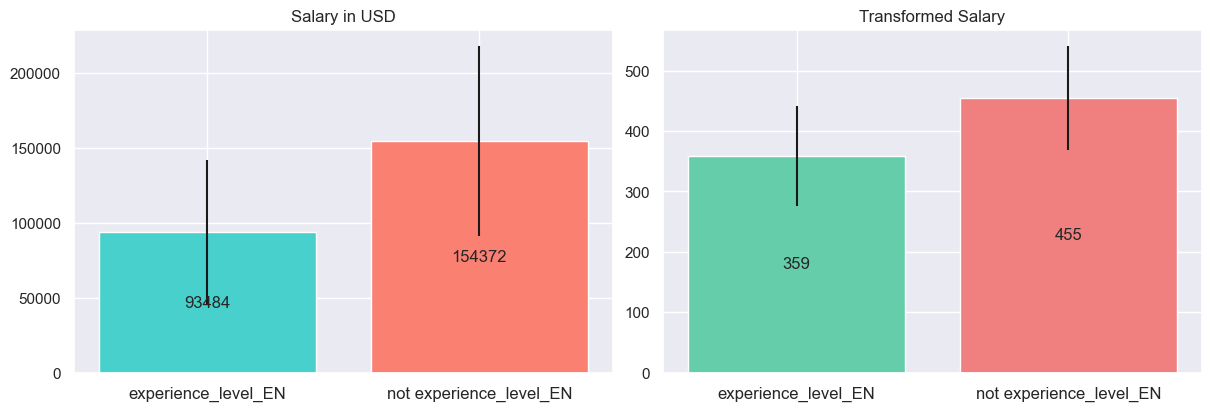

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
experience_level_EX                                                   
0                          148525  63735  13853                446  88
1                          193999  70580    423                506  85

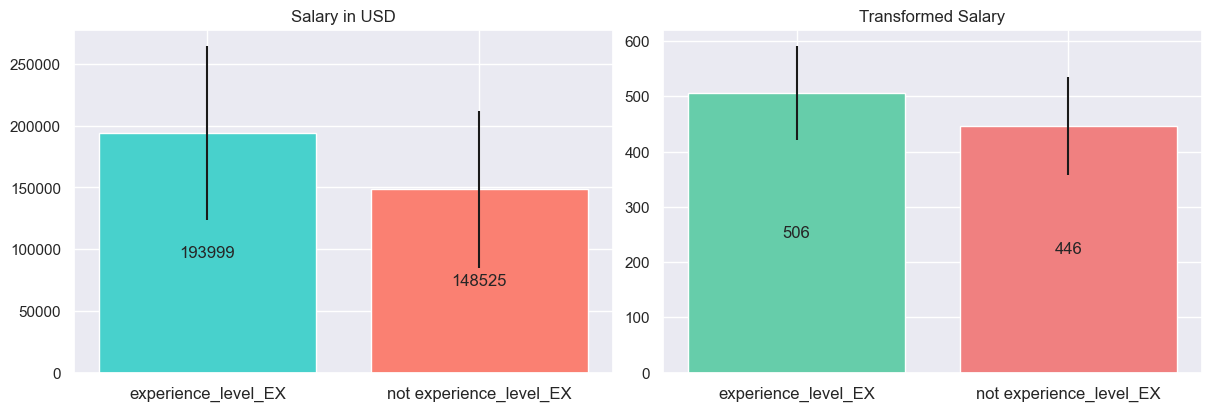

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
experience_level_MI                                                   
0                          157781  64187  10915                459  87
1                          124190  58134   3361                411  85

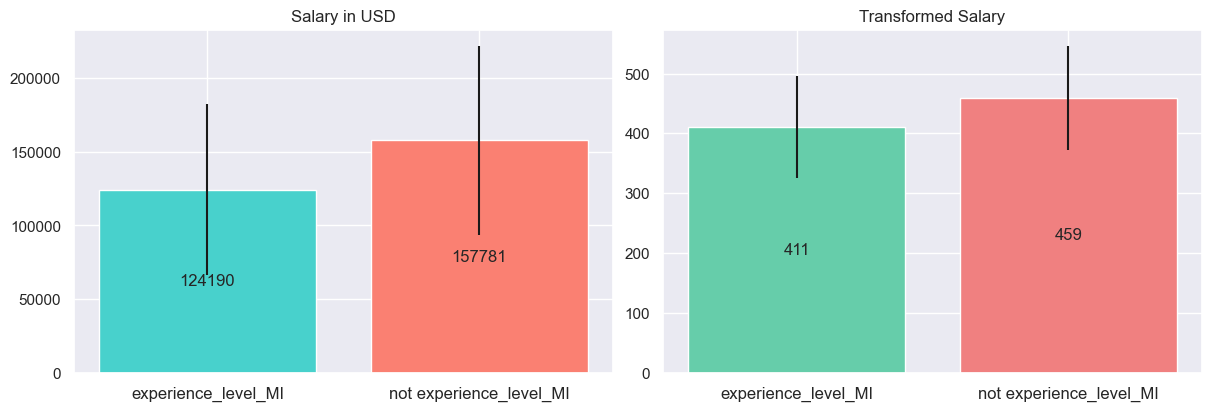

salary_in_usd              transformed_salary    
                             mean    std count               mean std
experience_level_SE                                                  
0                          123598  62644  4839                408  92
1                          163345  61060  9437                469  80

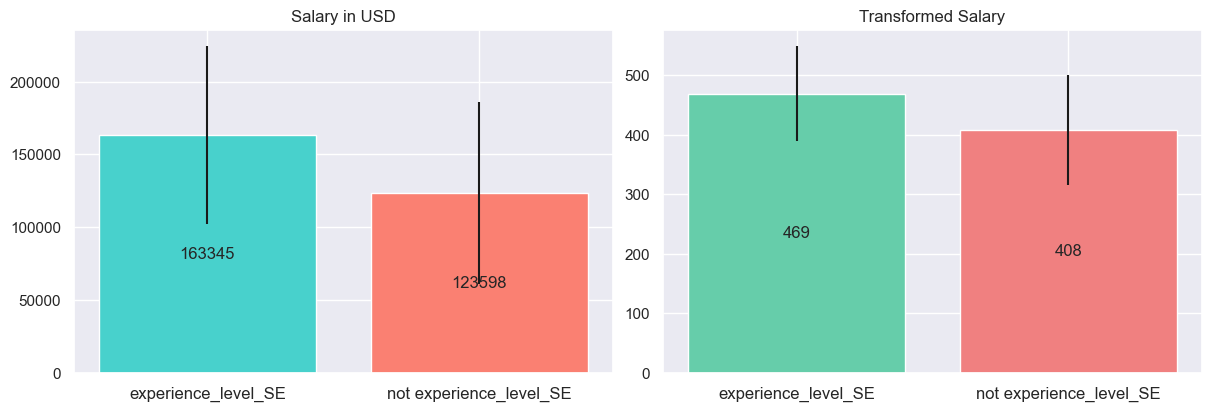

salary_in_usd                transformed_salary     
                            mean     std  count               mean  std
employment_type_CT                                                     
0                         149918   64333  14254                448   89
1                         120154  100501     22                388  137

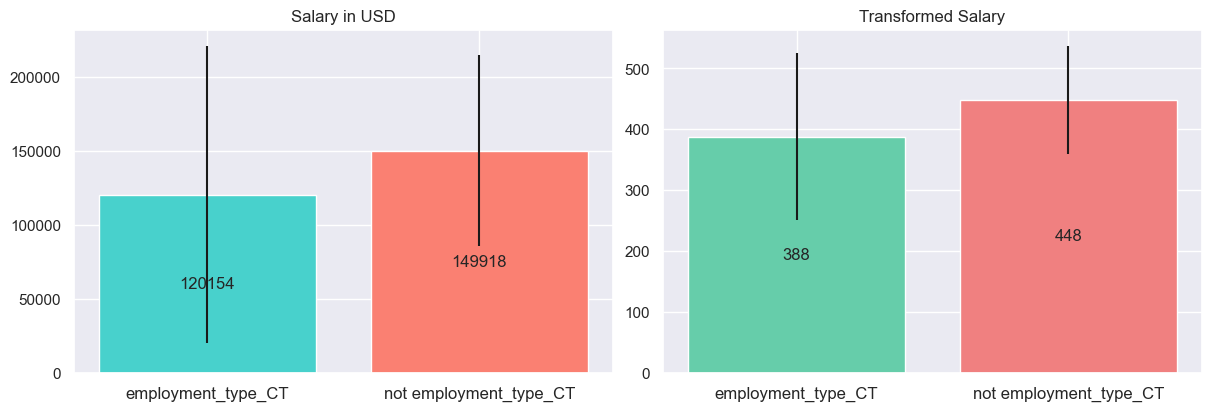

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
employment_type_FL                                                   
0                         149922  64383  14269                448  89
1                          48646  26666      7                268  65

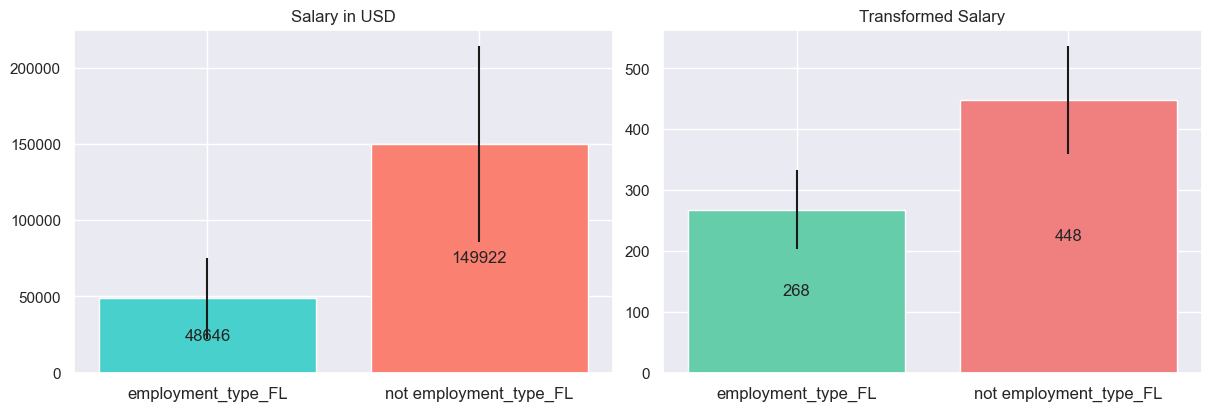

salary_in_usd               transformed_salary     
                            mean    std  count               mean  std
employment_type_FT                                                    
0                          86786  80043     47                332  123
1                         150081  64252  14229                448   89

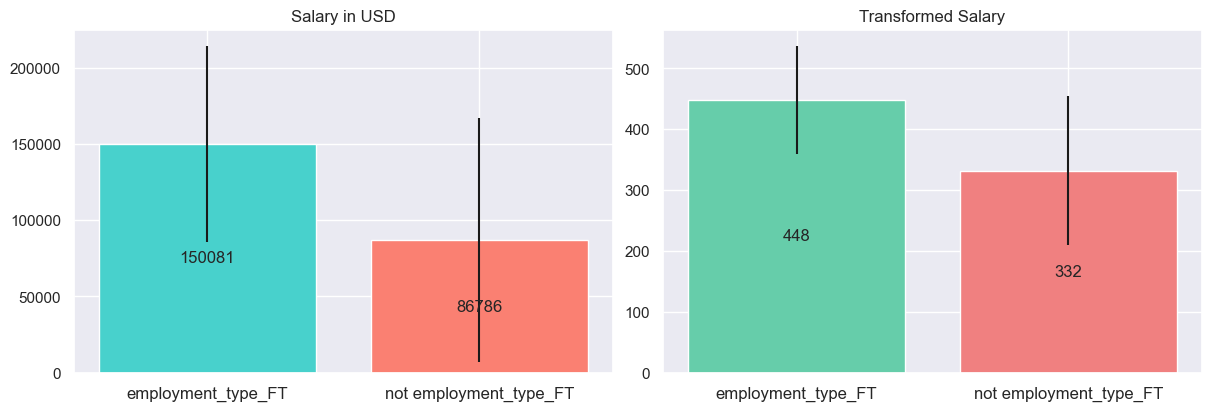

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
employment_type_PT                                                   
0                         149985  64355  14258                448  89
1                          60835  43073     18                288  94

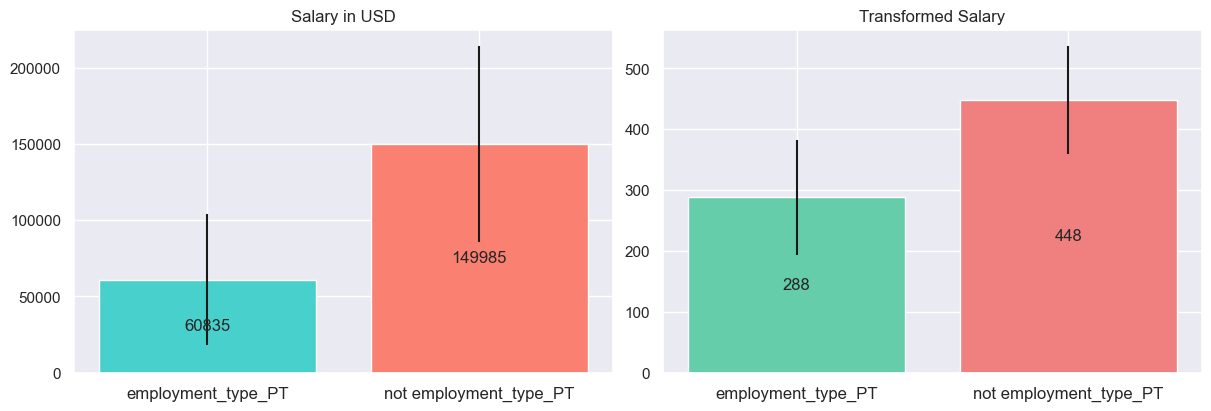

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_AUD                                                   
0                          149927  64400  14265                448  89
1                           79662  27474     11                340  53

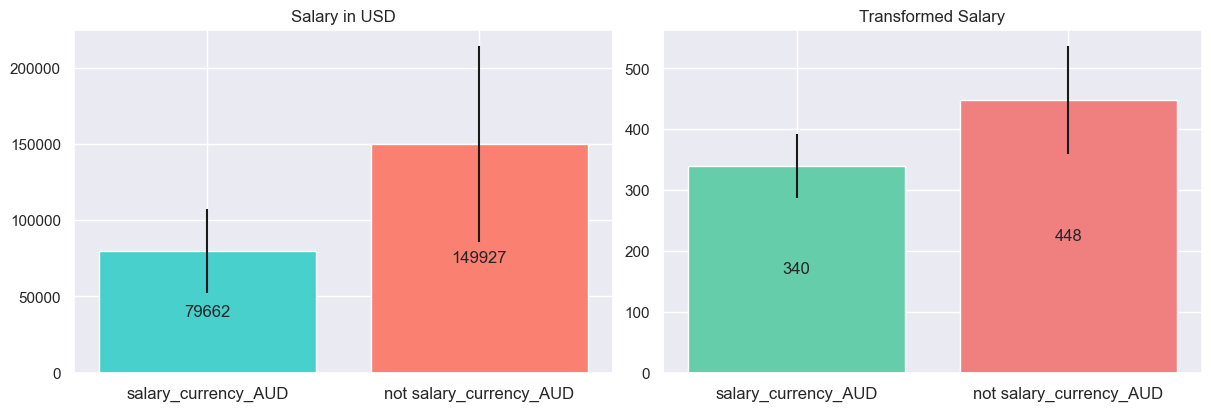

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_CAD                                                   
0                          150013  64402  14228                448  89
1                          108122  52213     48                386  80

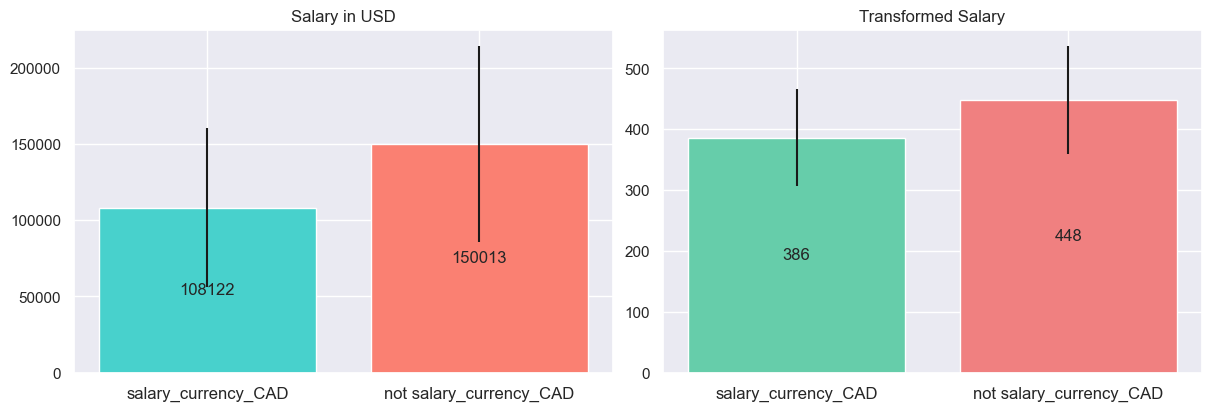

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_CHF                                                   
0                          149891  64414  14270                448  89
1                          106307  26420      6                390  48

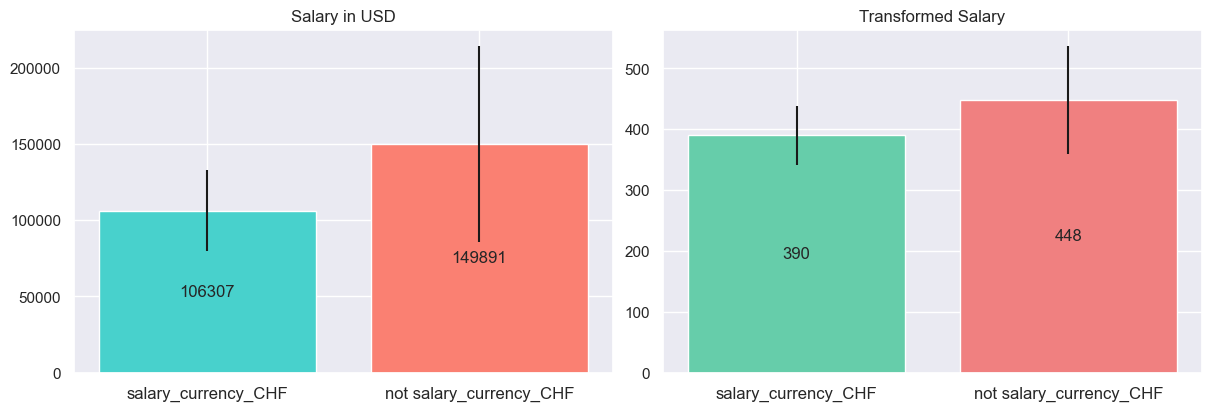

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_EUR                                                   
0                          152310  63418  13881                452  86
1                           64224  32542    395                305  63

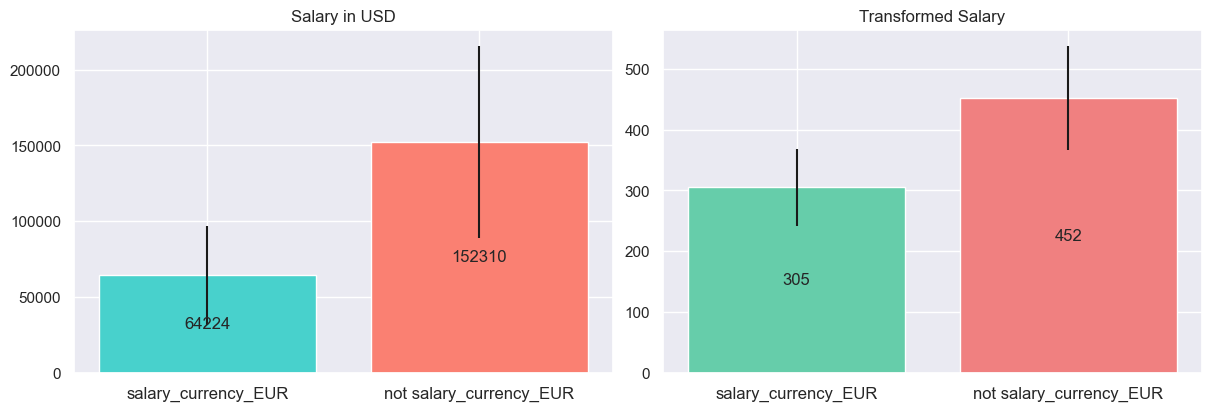

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_GBP                                                   
0                          152564  63469  13737                452  87
1                           81271  48214    539                338  74

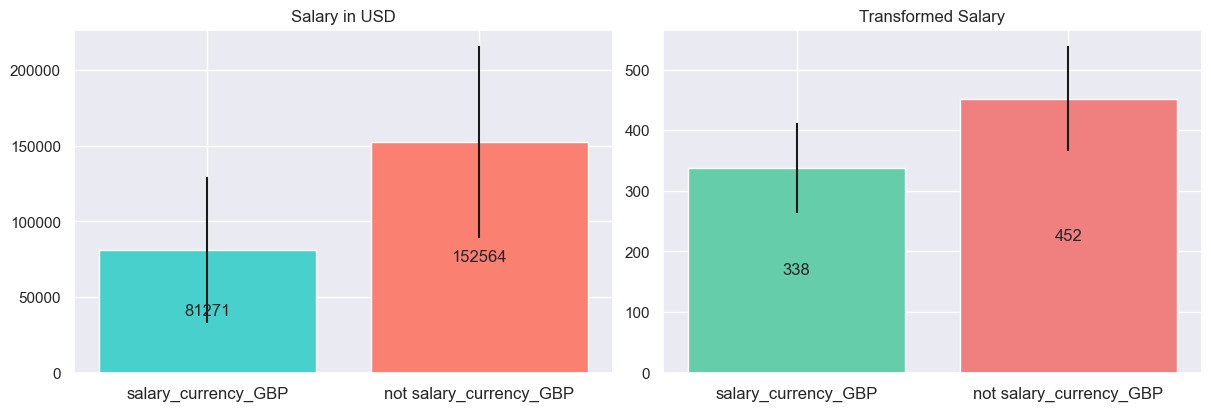

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_INR                                                   
0                          150272  64149  14227                449  88
1                           33910  19277     49                227  53

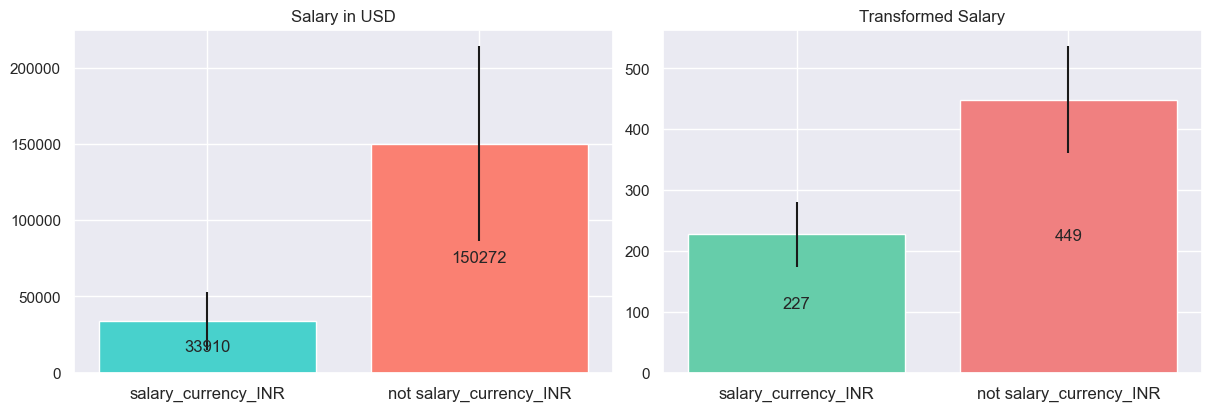

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_PLN                                                   
0                          149920  64380  14270                448  89
1                           36295  11609      6                239  37

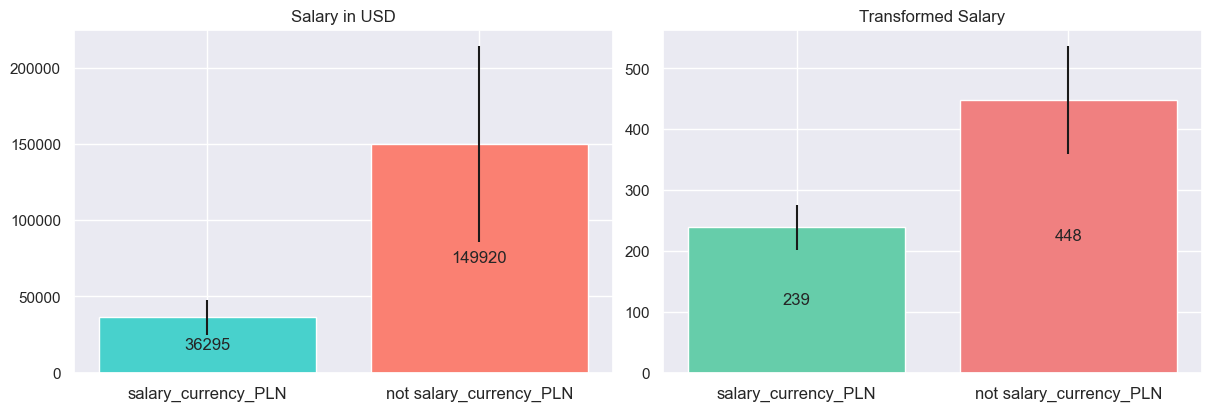

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_USD                                                   
0                           73773  44032   1054                323  75
1                          155939  61858  13222                458  82

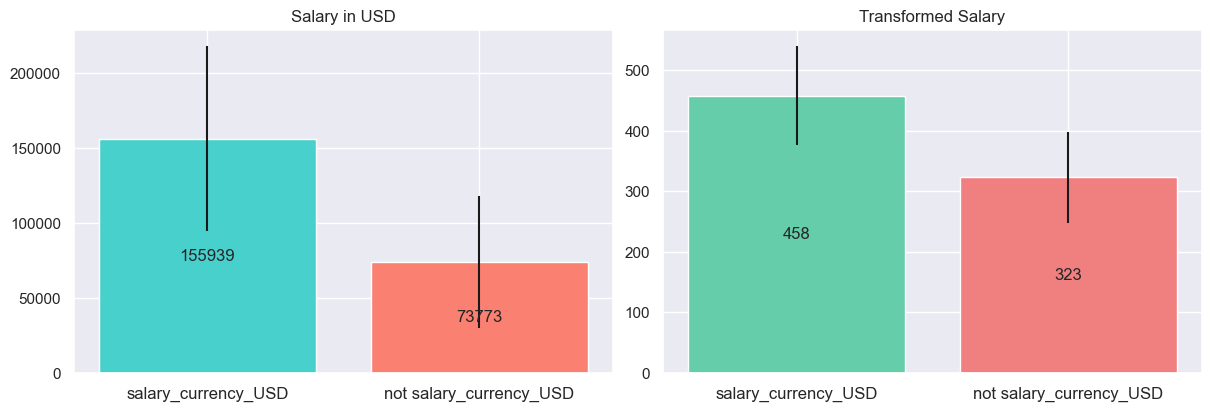

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_AR                                                   
0                            149940  64386  14265                448  89
1                             62272  18504     11                306  42

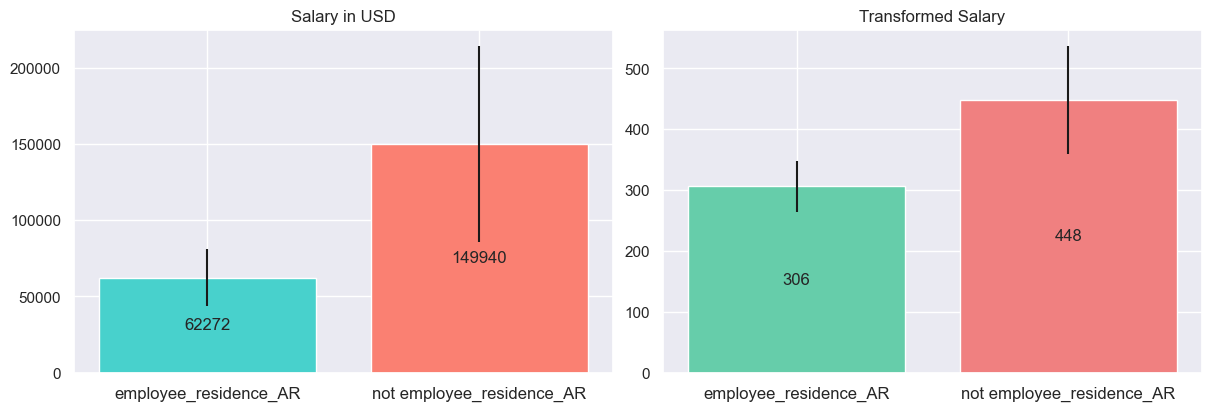

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_AT                                                   
0                            149930  64394  14266                448  89
1                             68378  15101     10                320  32

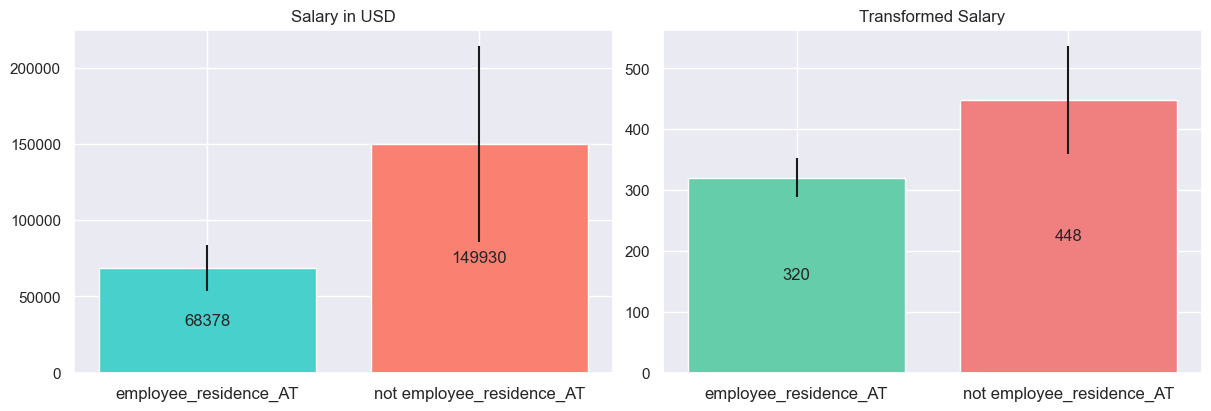

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_AU                                                    
0                            149913  64373  14230                448   89
1                            137401  74486     46                426  105

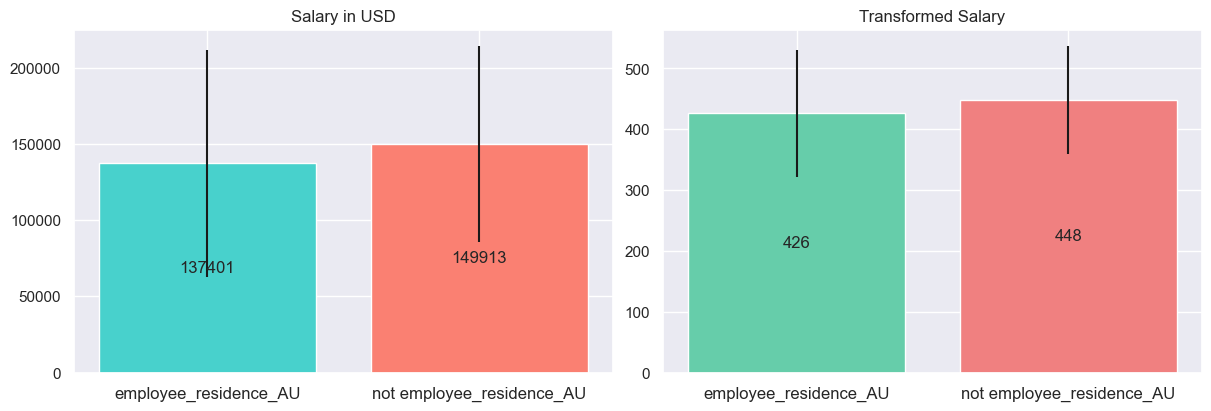

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_BR                                                   
0                            149962  64385  14259                448  89
1                             74411  32850     17                327  64

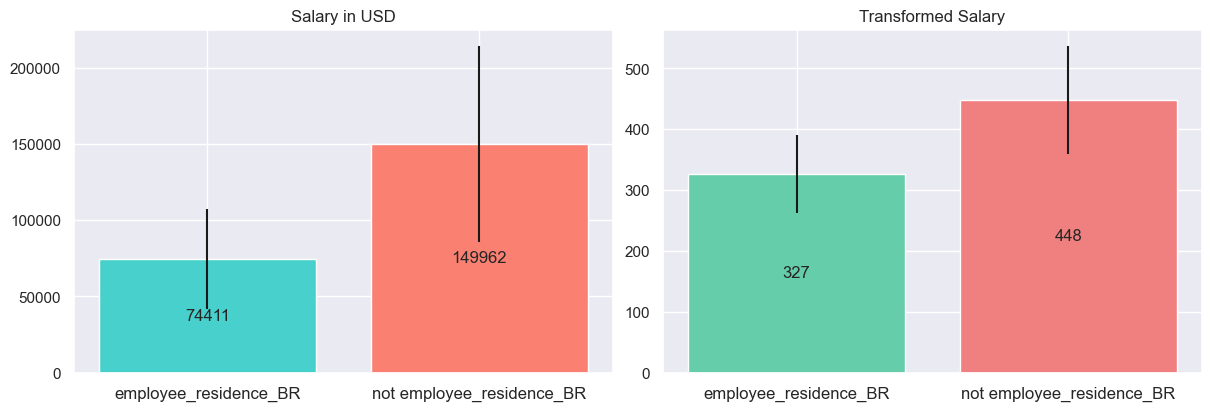

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_CA                                                   
0                            150011  64547  13903                448  89
1                            144697  58897    373                442  81

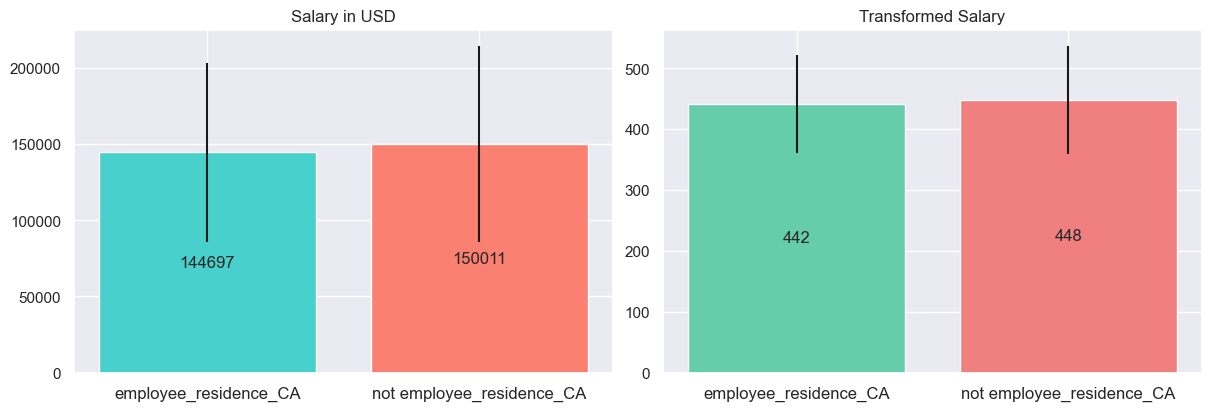

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_CH                                                   
0                            149891  64414  14270                448  89
1                            106307  26420      6                390  48

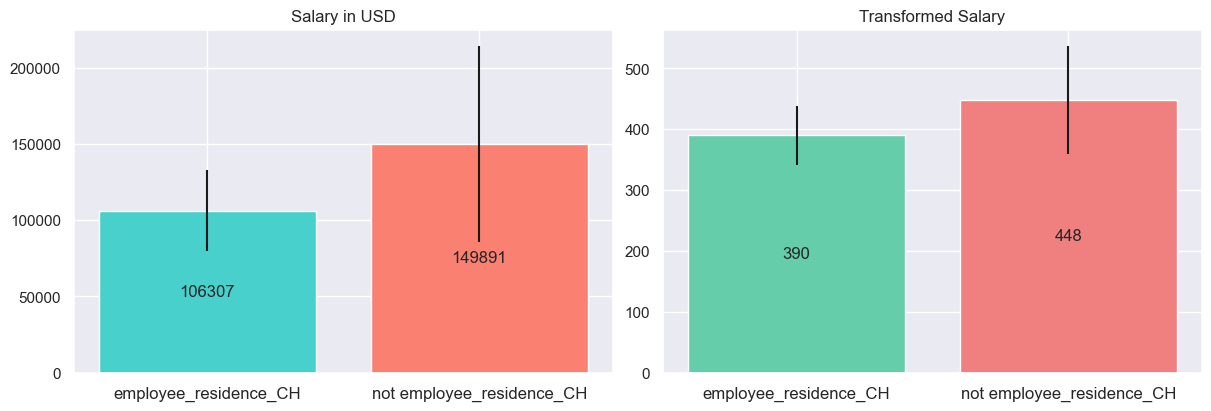

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_CO                                                   
0                            149952  64394  14260                448  89
1                             79115  30019     16                338  61

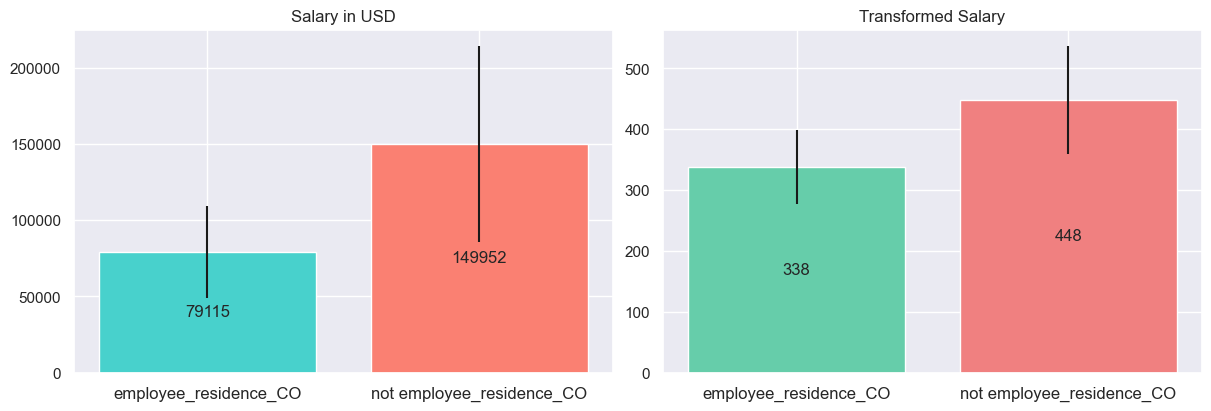

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_DE                                                   
0                            150191  64338  14188                448  89
1                             98470  54835     88                367  88

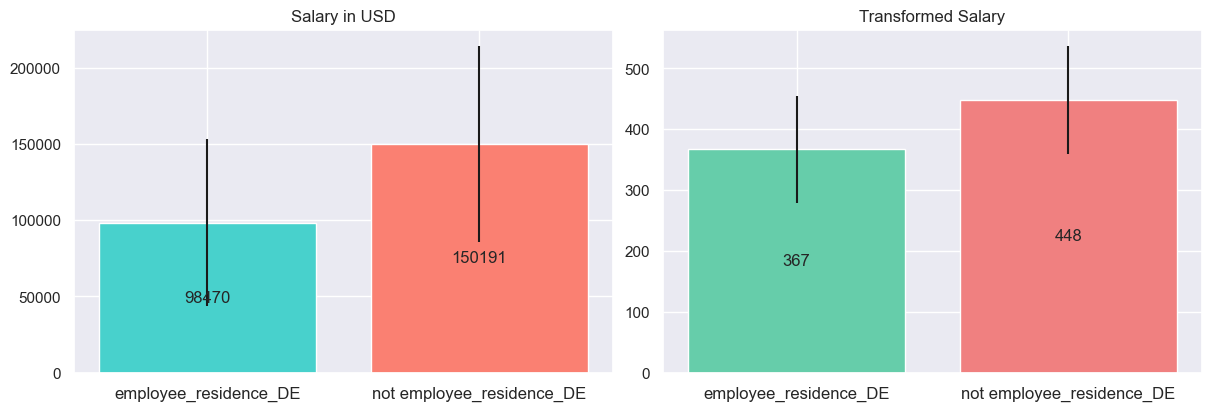

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_EE                                                   
0                            149954  64366  14265                448  89
1                             43941   8749     11                263  23

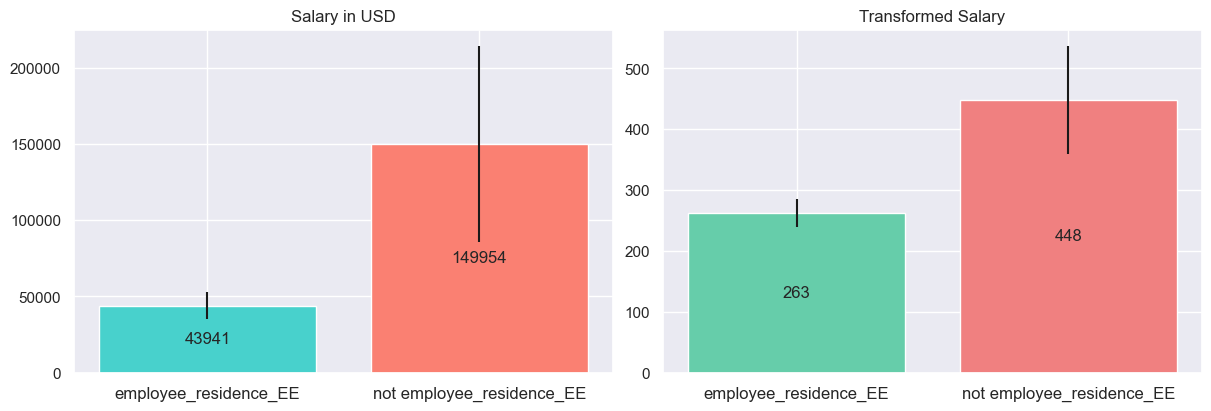

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_EG                                                    
0                            149886  64404  14262                448   89
1                            135807  70464     14                423  109

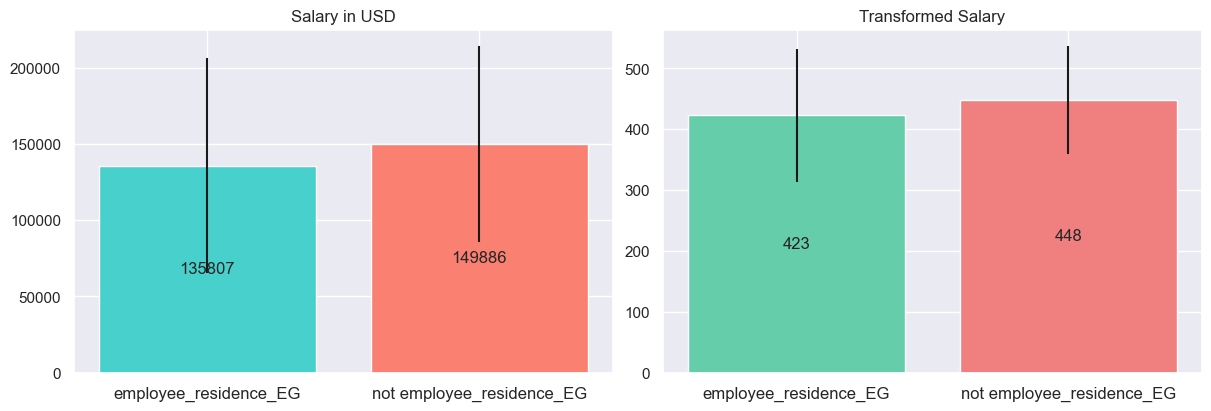

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_ES                                                   
0                            150698  64014  14148                449  88
1                             58668  36987    128                291  66

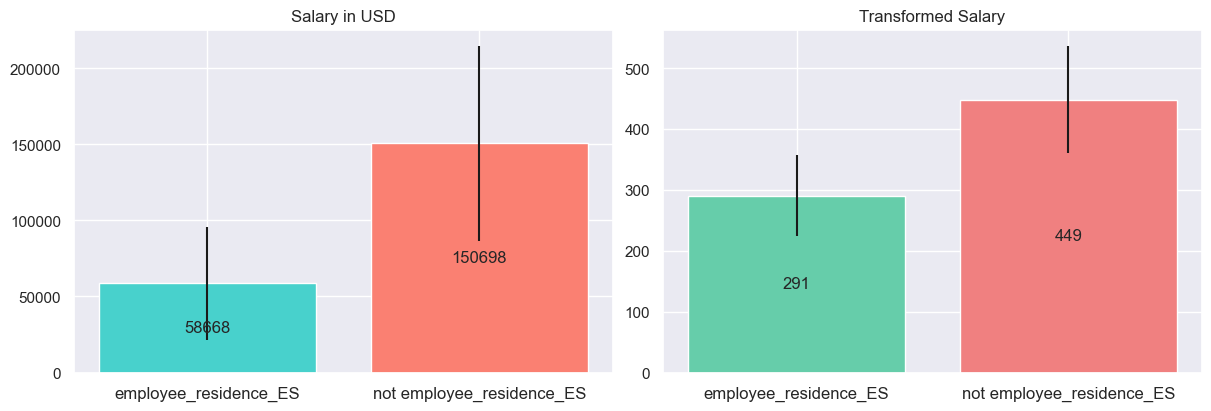

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_FR                                                   
0                            150157  64286  14212                448  89
1                             86612  60853     64                342  95

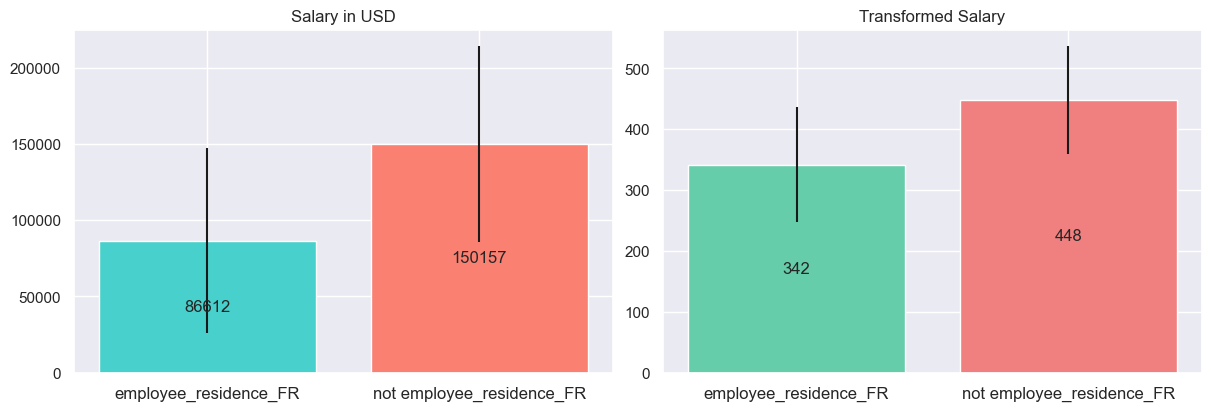

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_GB                                                   
0                            152325  63608  13653                452  87
1                             96122  58142    623                362  89

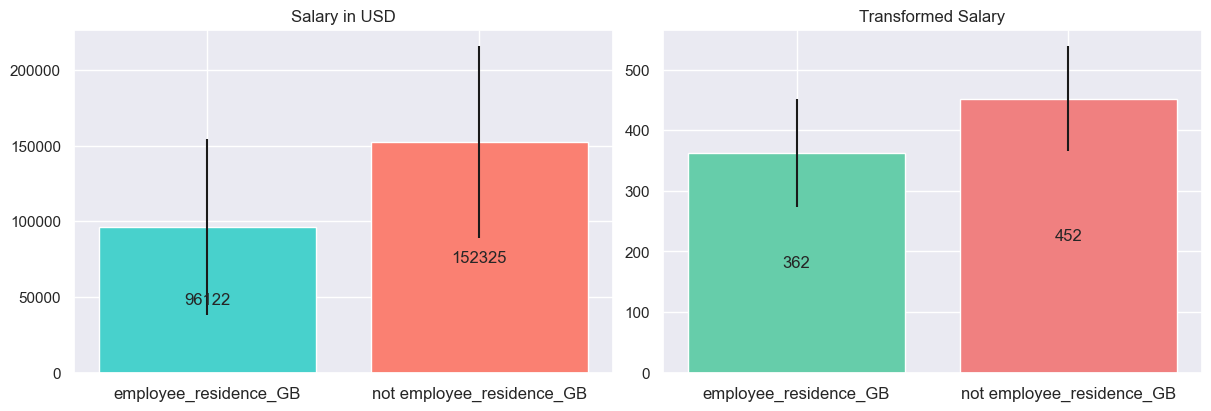

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_GR                                                   
0                            149983  64357  14260                448  89
1                             51692  21262     16                278  55

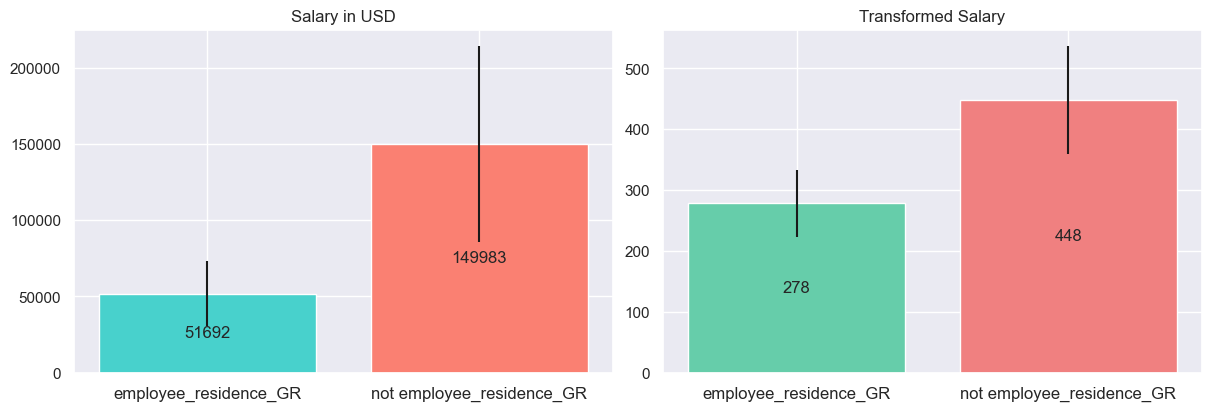

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_IE                                                   
0                            149910  64416  14264                448  89
1                            104694  33896     12                386  53

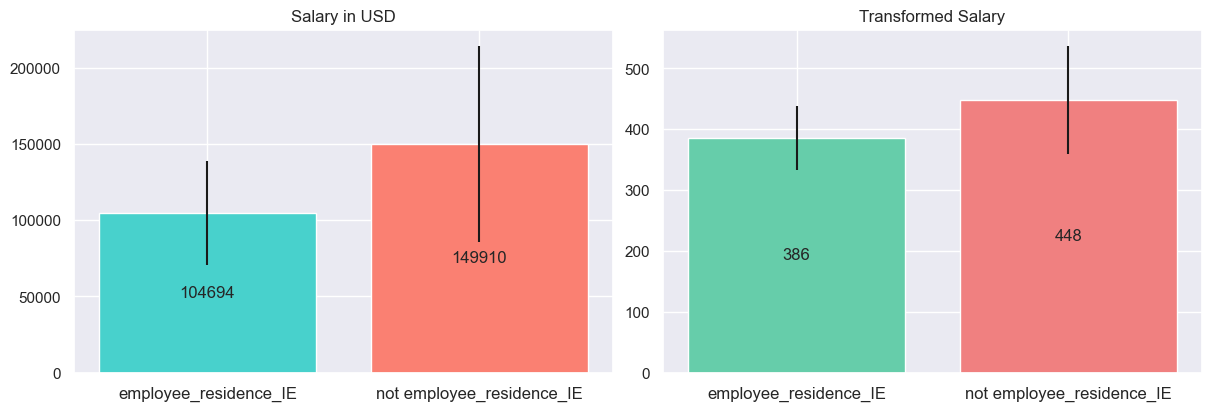

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_IN                                                   
0                            150349  64120  14210                449  88
1                             47248  39994     66                255  86

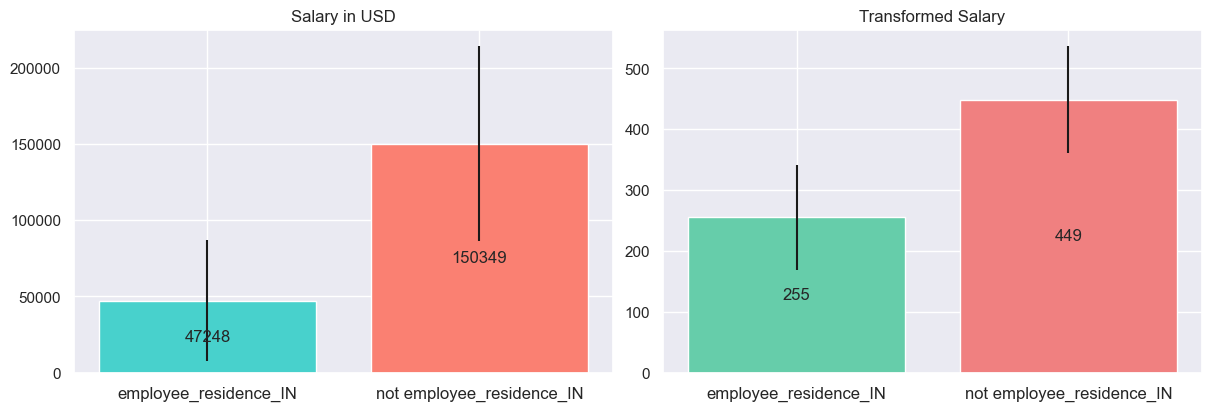

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_IT                                                   
0                            150012  64343  14255                448  89
1                             54867  30538     21                282  67

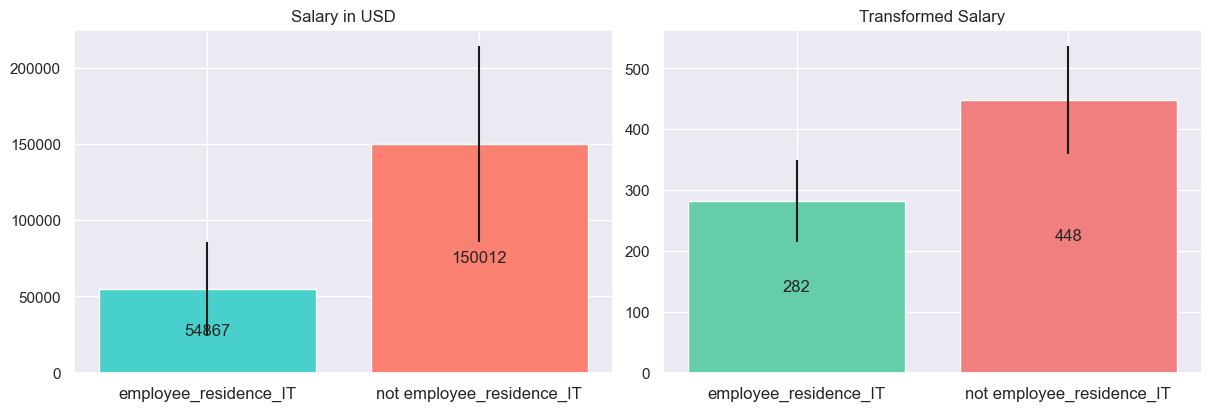

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_LT                                                   
0                            149964  64381  14260                448  89
1                             68553  29287     16                316  60

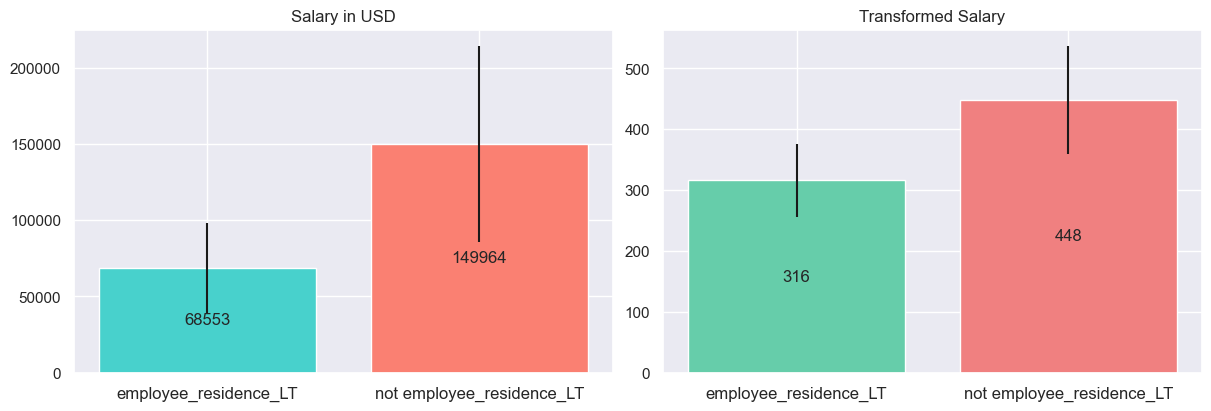

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_LV                                                   
0                            149966  64369  14262                448  89
1                             54734  19875     14                287  46

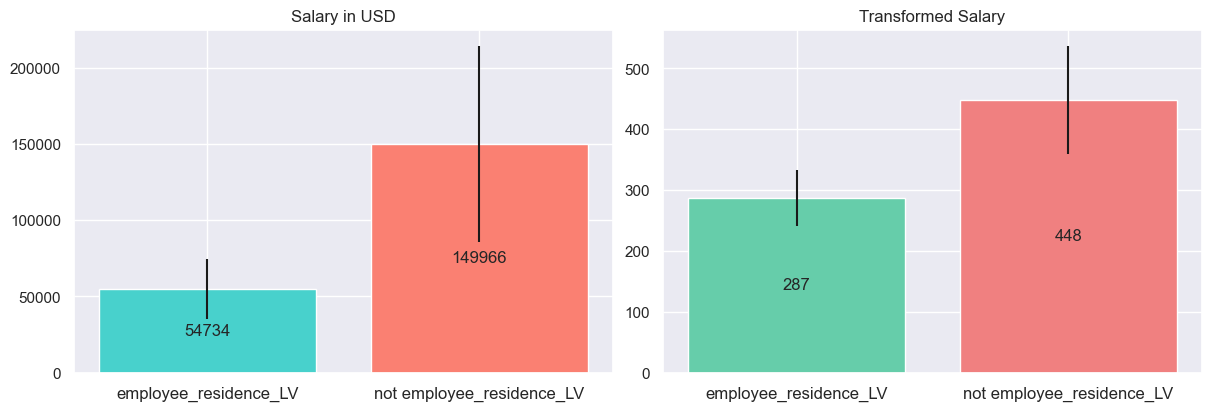

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_MX                                                    
0                            149923  64380  14264                448   89
1                             89258  72868     12                337  128

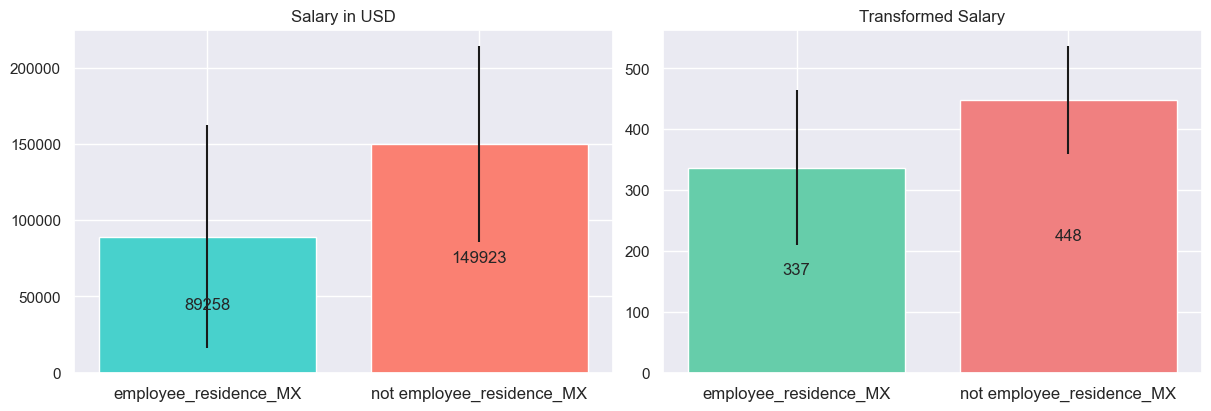

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_NG                                                   
0                            149954  64360  14264                448  89
1                             52416  49059     12                267  94

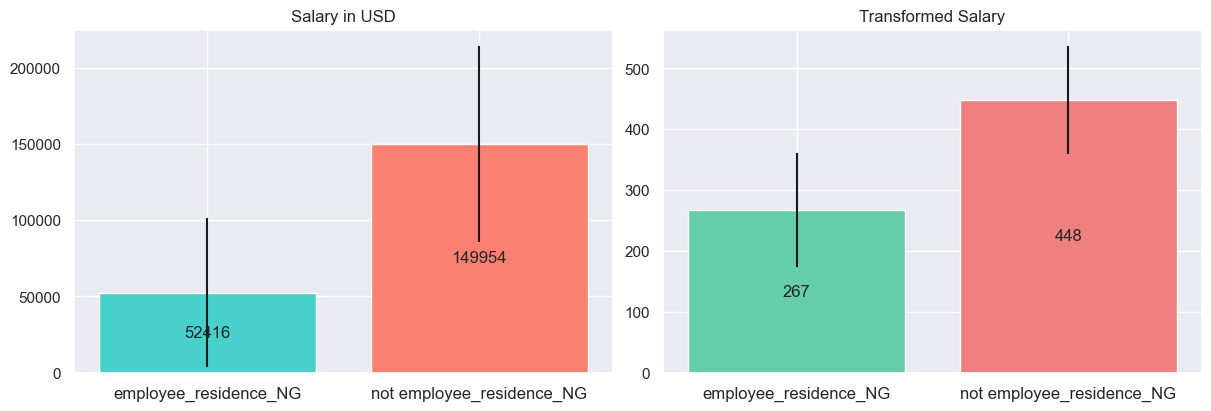

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_NL                                                   
0                            150016  64379  14248                448  89
1                             76752  28581     28                334  56

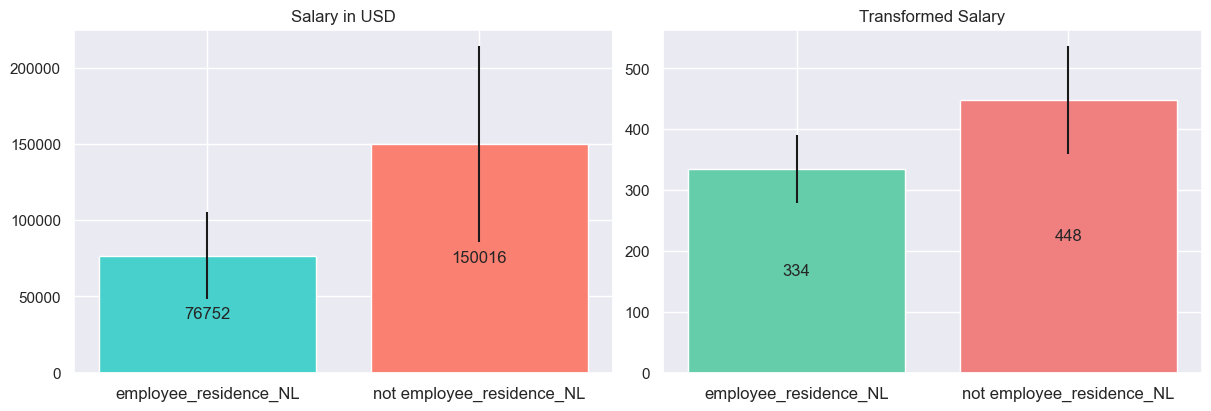

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_NZ                                                   
0                            149872  64418  14271                448  89
1                            152218  35137      5                460  46

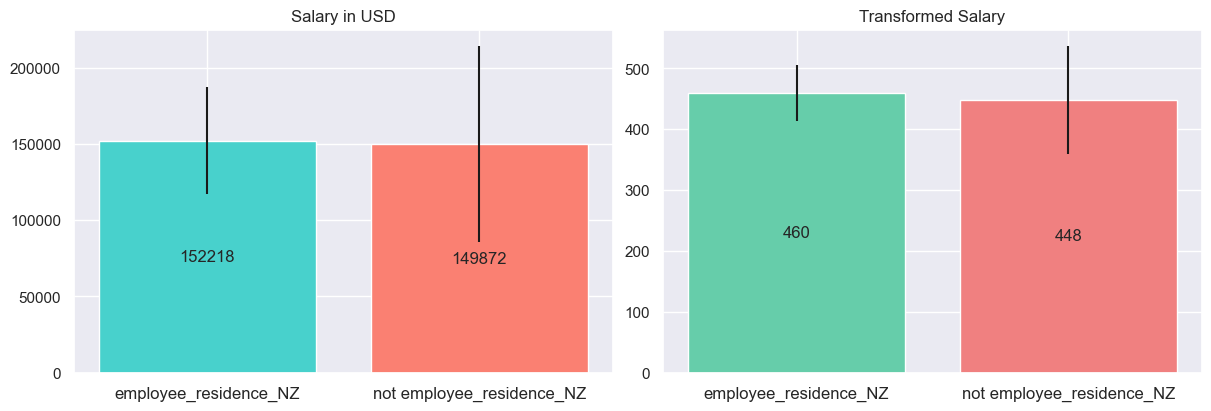

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_PH                                                   
0                            149921  64386  14269                448  89
1                             51337  24241      7                277  59

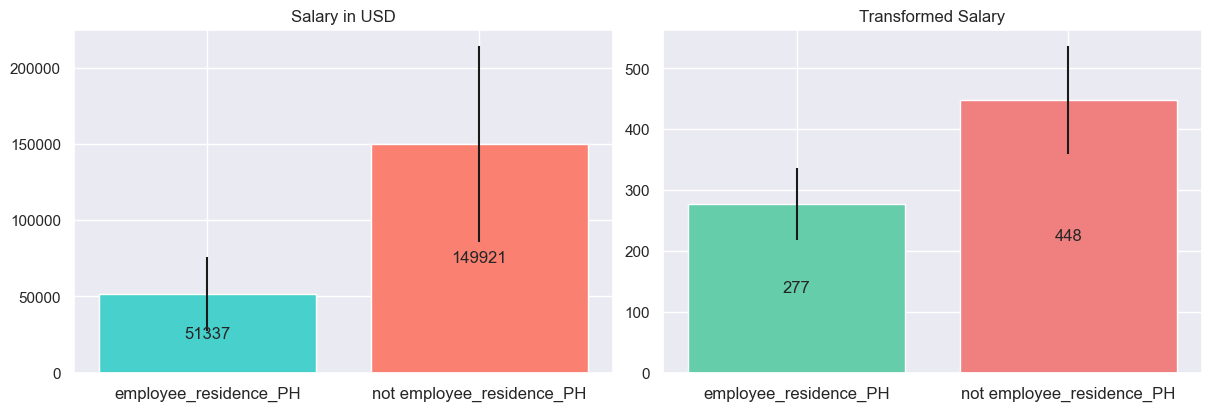

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_PL                                                    
0                            149942  64381  14262                448   89
1                             79055  54735     14                326  102

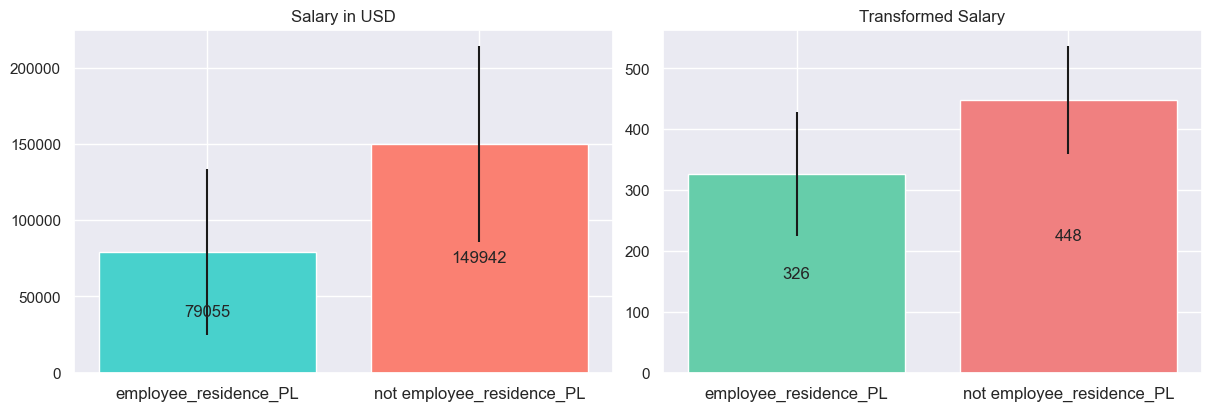

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_PT                                                   
0                            150075  64313  14246                448  89
1                             53920  28464     30                281  64

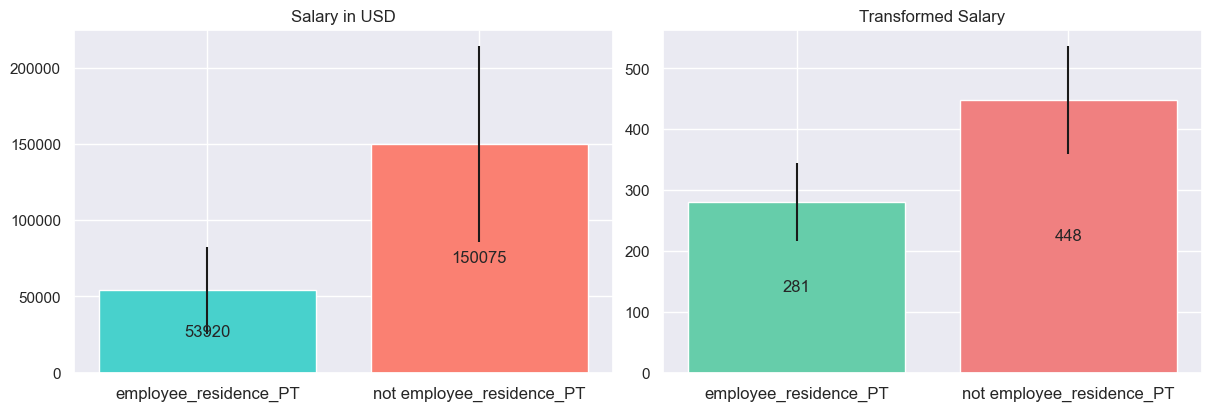

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_SI                                                   
0                            149912  64392  14270                448  89
1                             56186  28245      6                287  65

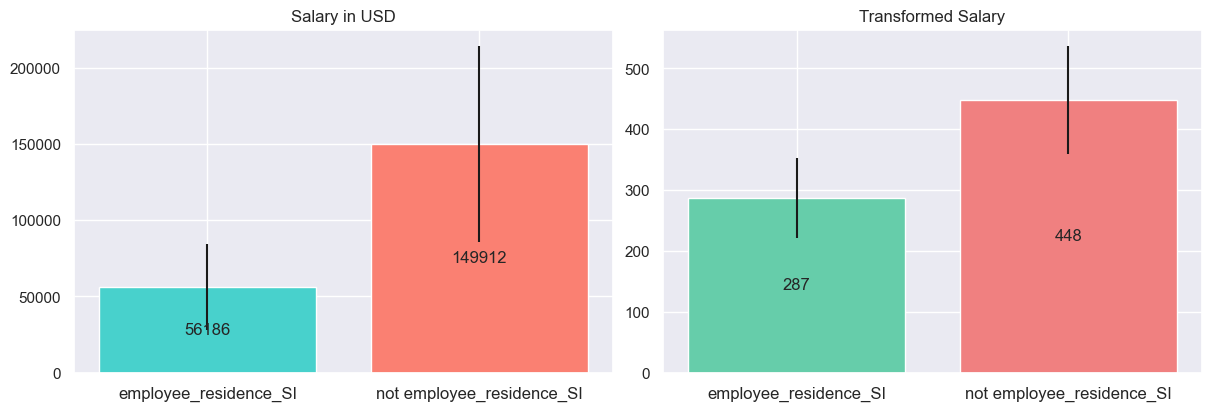

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_UA                                                    
0                            149912  64390  14265                448   89
1                             98272  71246     11                359  114

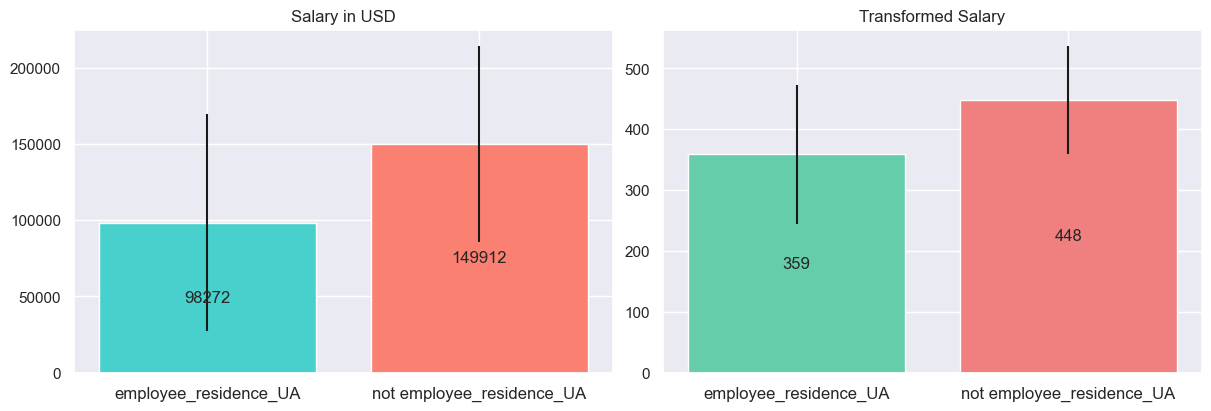

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_US                                                   
0                             98727  61774   1691                364  99
1                            156745  61602  12585                459  81

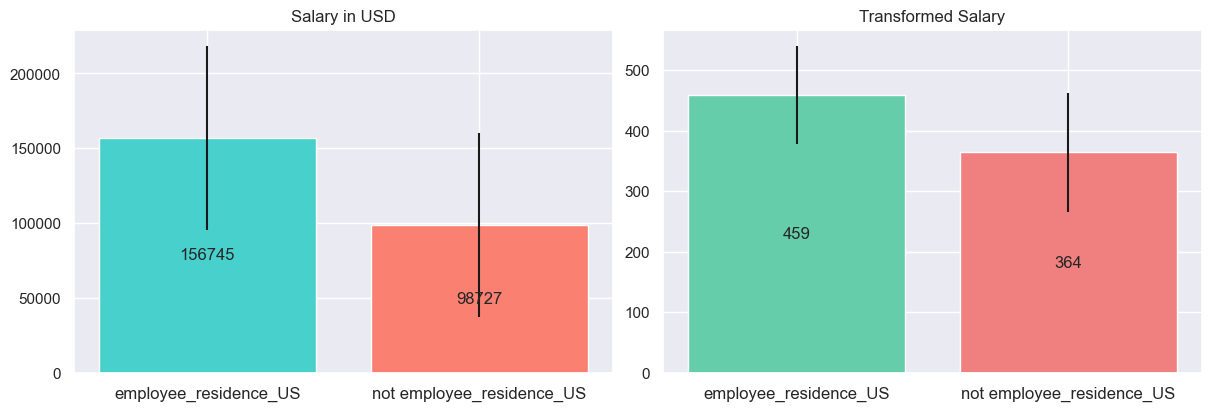

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_ZA                                                   
0                            149963  64371  14262                448  89
1                             57308  24142     14                292  51

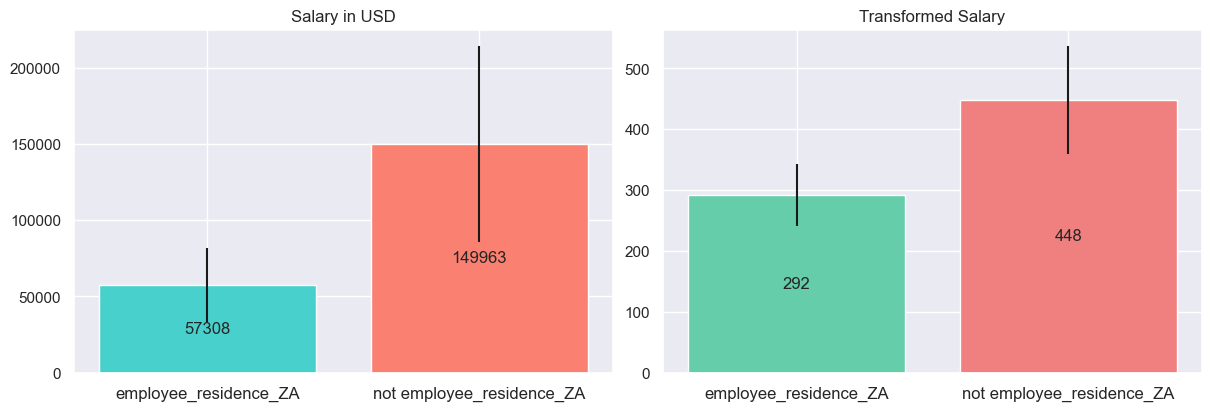

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
remote_ratio_Hybrid                                                    
0                          150781  63964  14078                450   88
1                           85306  63290    198                337  102

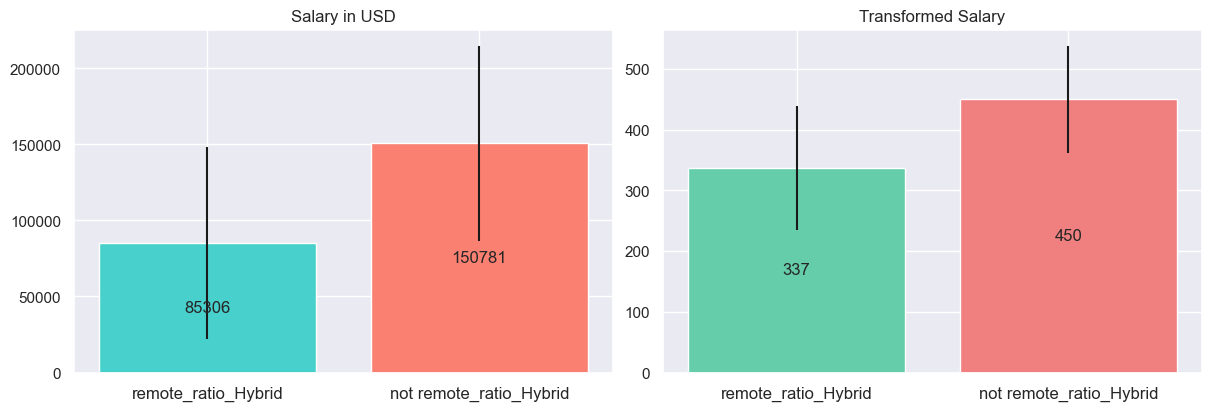

salary_in_usd              transformed_salary    
                              mean    std count               mean std
remote_ratio_On_Site                                                  
0                           143310  60953  4760                439  88
1                           153155  65828  9516                453  89

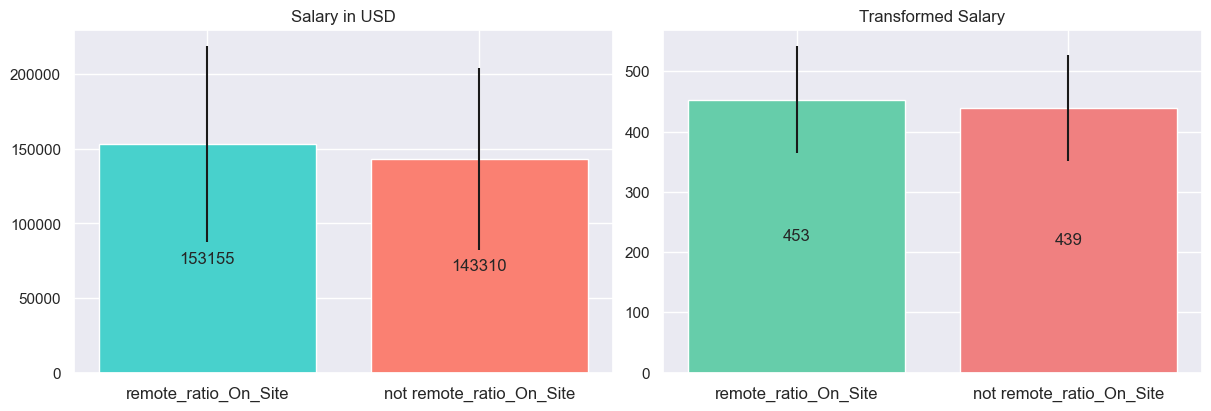

salary_in_usd              transformed_salary    
                             mean    std count               mean std
remote_ratio_Remote                                                  
0                          151772  66469  9714                450  91
1                          145828  59592  4562                443  85

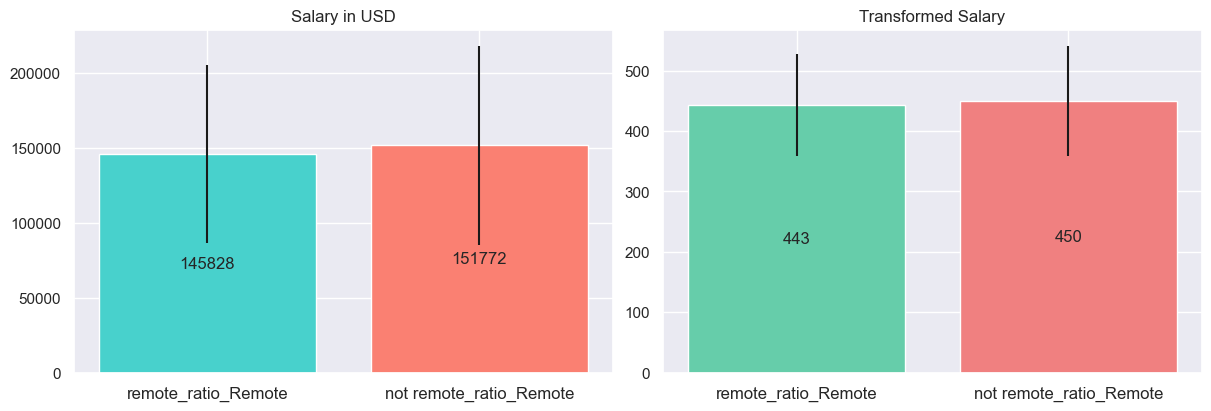

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_AR                                                   
0                          149912  64399  14269                448  89
1                           69571  17299      7                322  37

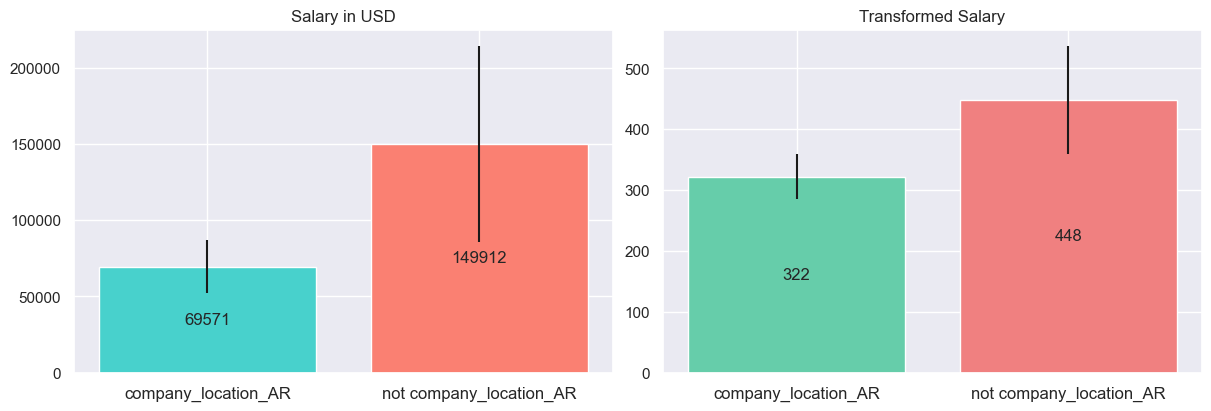

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_AT                                                   
0                          149930  64394  14266                448  89
1                           68479  15045     10                321  32

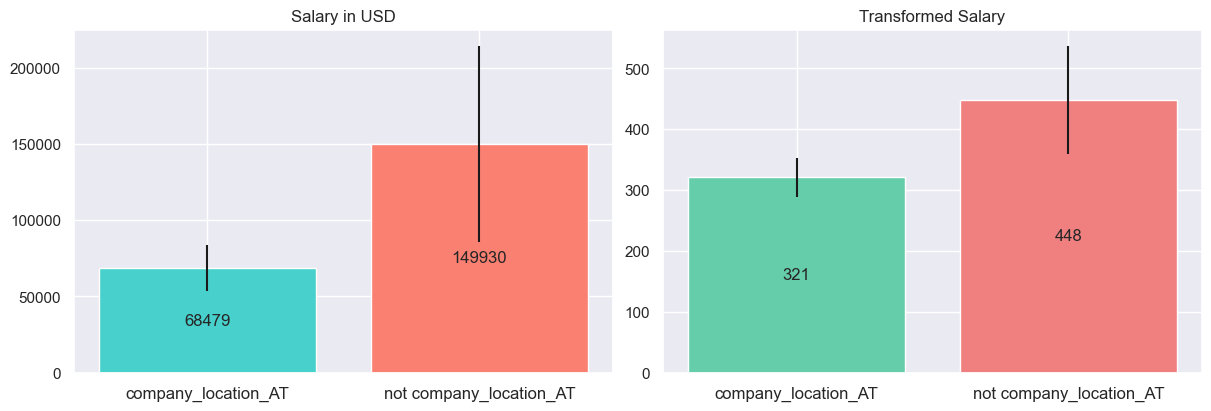

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
company_location_AU                                                    
0                          149918  64372  14228                448   89
1                          136280  74144     48                424  106

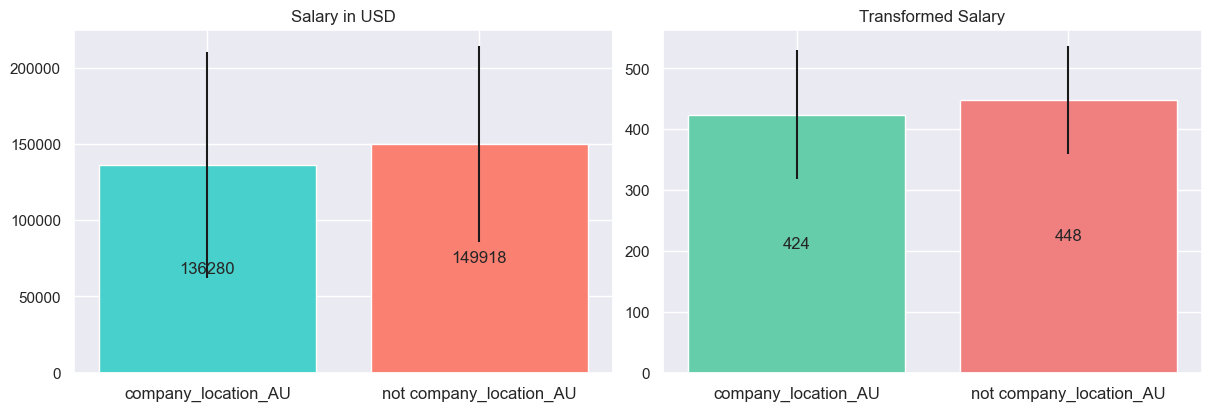

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_BR                                                   
0                          149960  64382  14261                448  89
1                           67000  24585     15                314  53

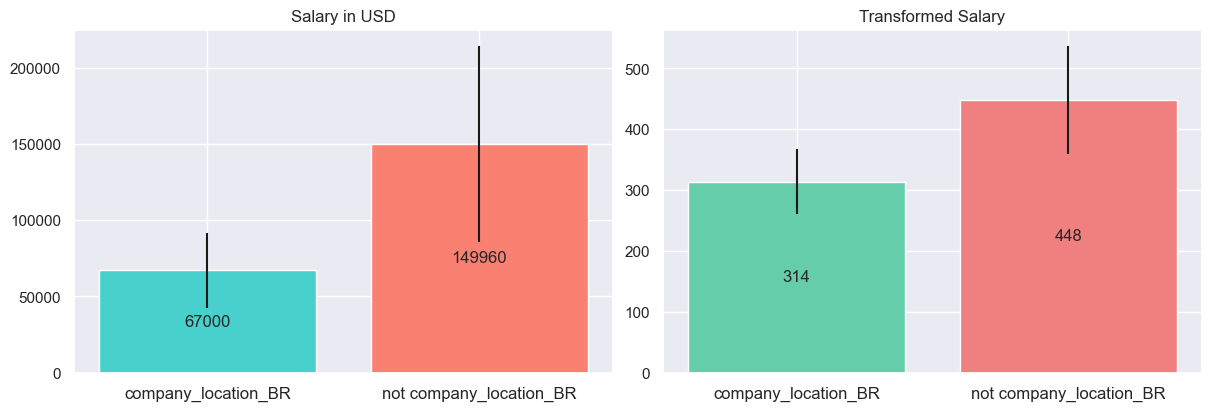

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_CA                                                   
0                          150020  64532  13901                448  89
1                          144387  59483    375                442  83

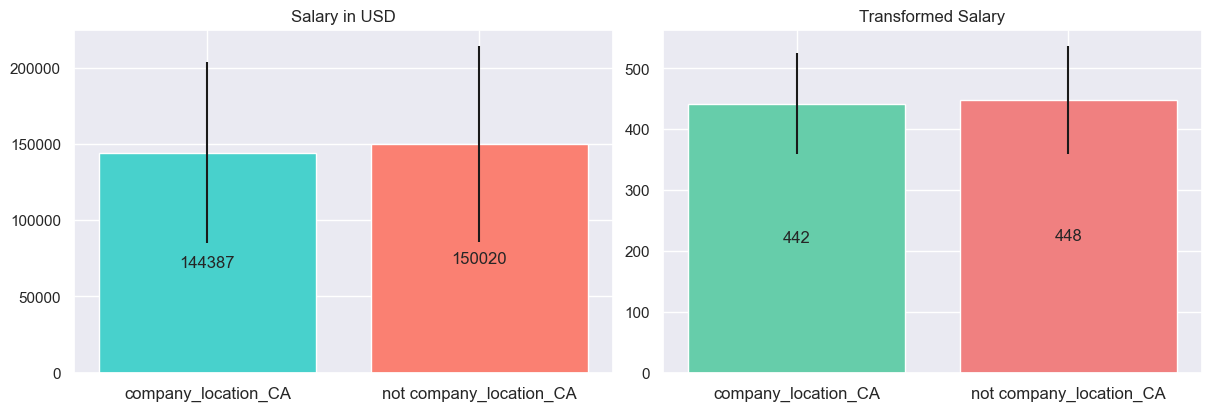

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_CH                                                   
0                          149900  64408  14269                448  89
1                           94594  39267      7                363  83

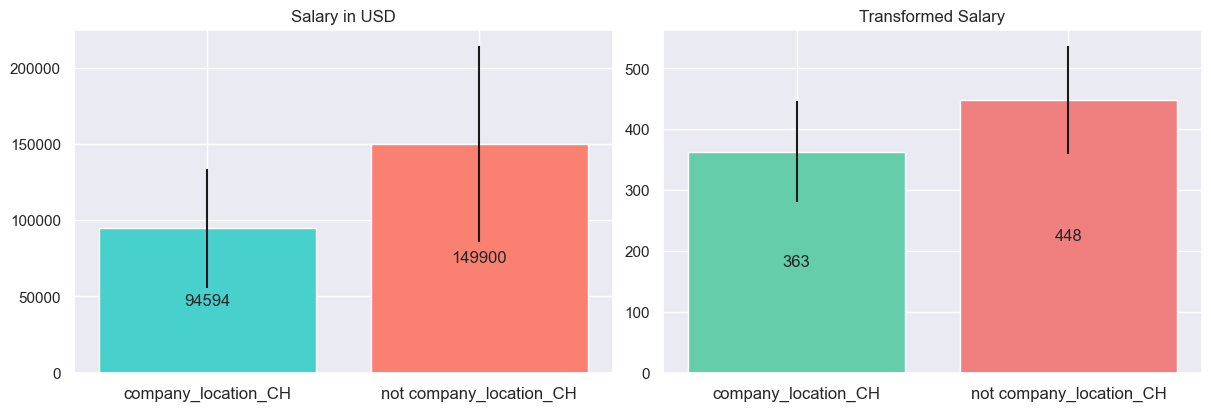

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_CO                                                   
0                          149952  64394  14260                448  89
1                           79115  30019     16                338  61

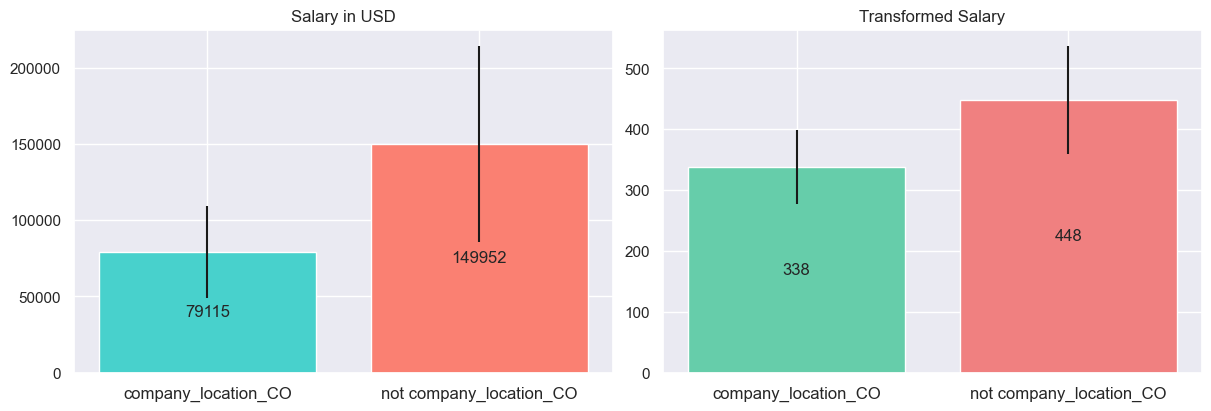

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_DE                                                   
0                          150228  64316  14184                449  89
1                           95050  54872     92                360  89

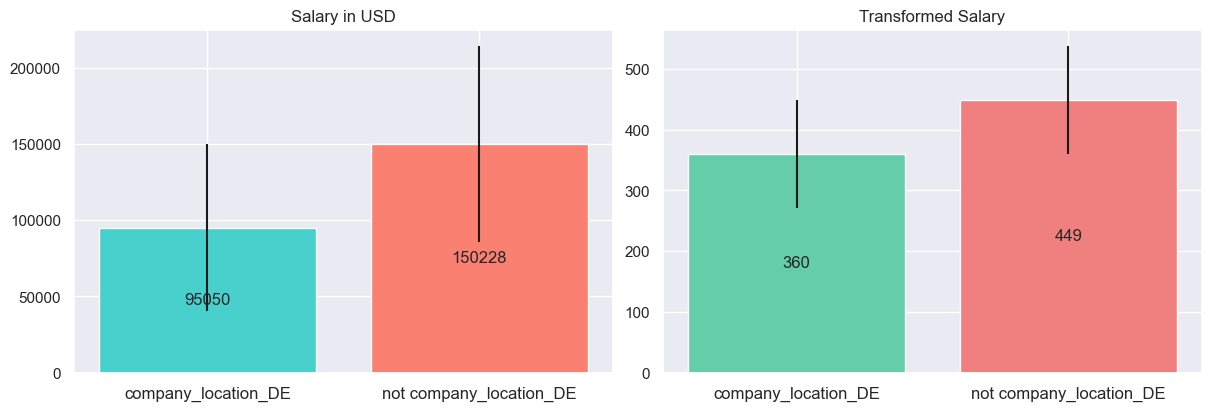

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_EE                                                   
0                          149954  64366  14265                448  89
1                           43941   8749     11                263  23

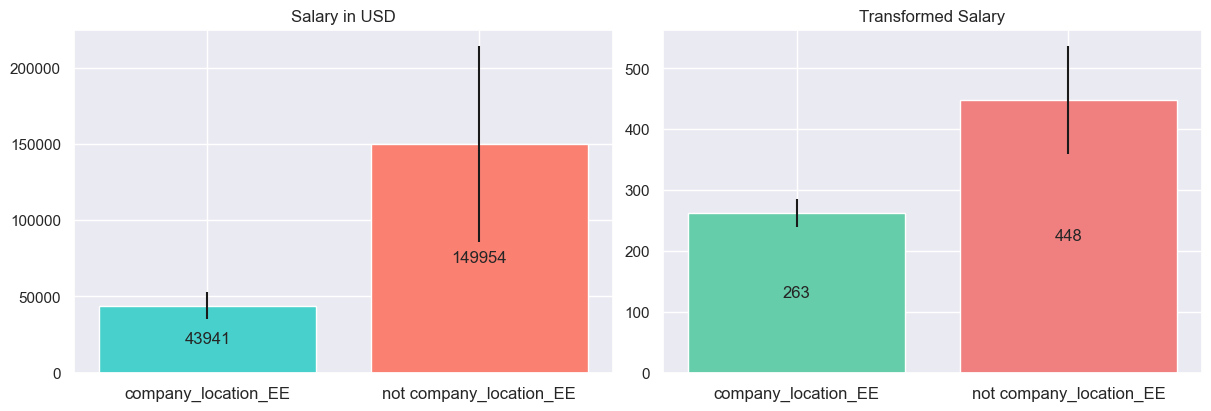

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
company_location_EG                                                    
0                          149881  64405  14263                448   89
1                          140869  70642     13                431  110

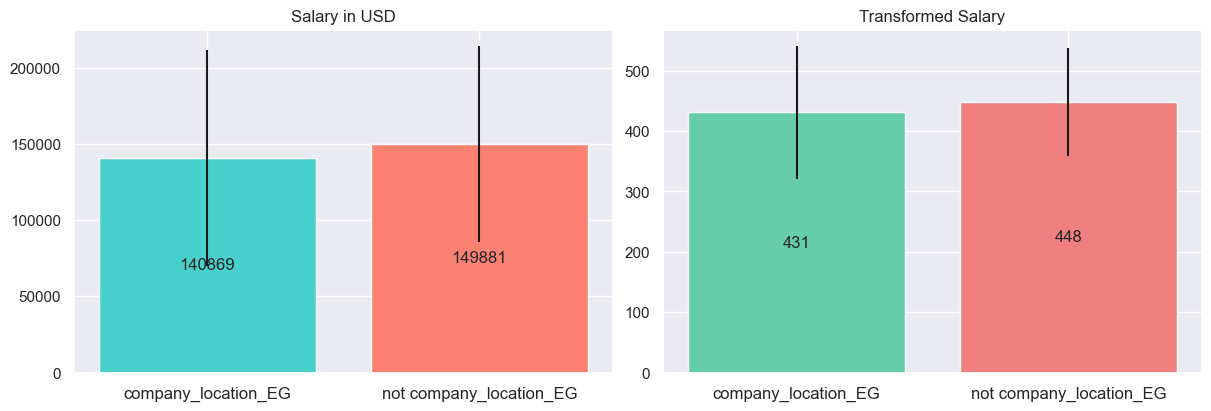

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_ES                                                   
0                          150700  64010  14150                449  88
1                           56932  34523    126                288  61

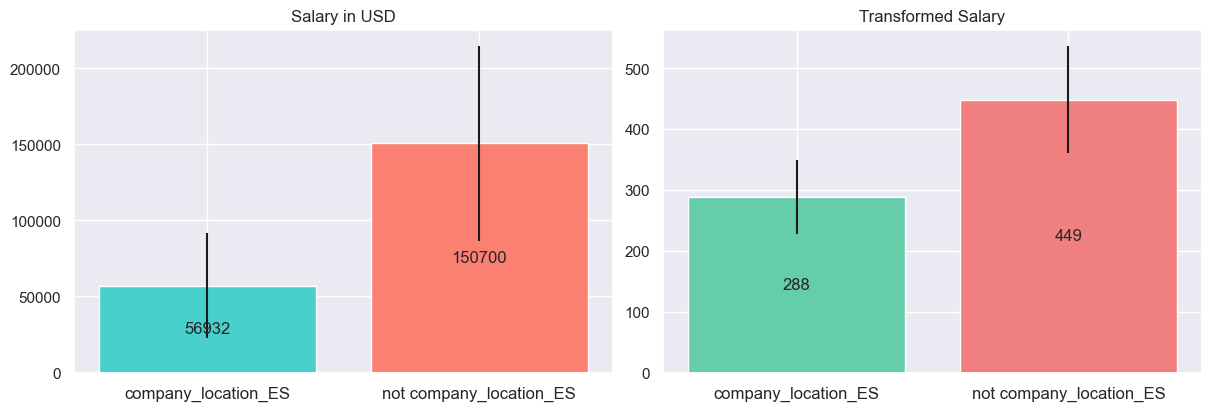

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_FR                                                   
0                          150140  64310  14217                448  89
1                           85337  55472     59                341  91

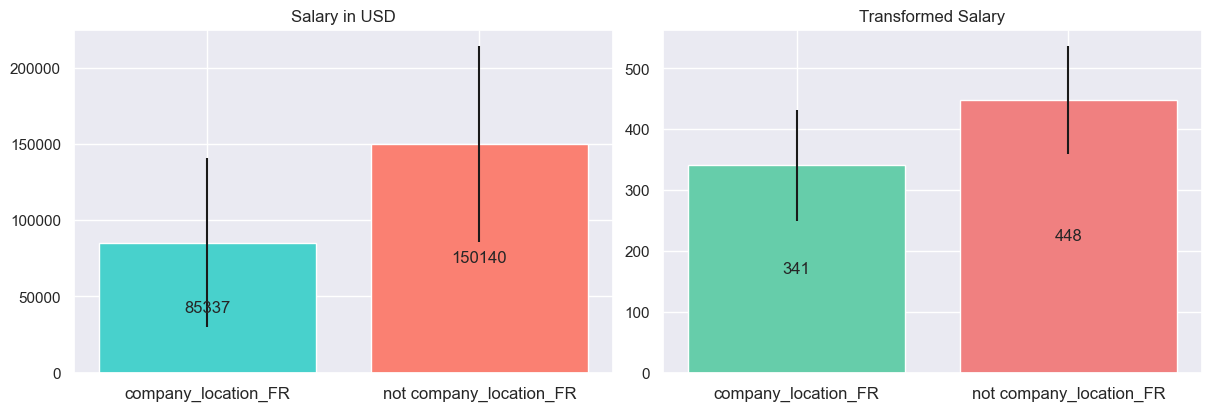

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_GB                                                   
0                          152355  63598  13648                452  87
1                           95923  58015    628                362  89

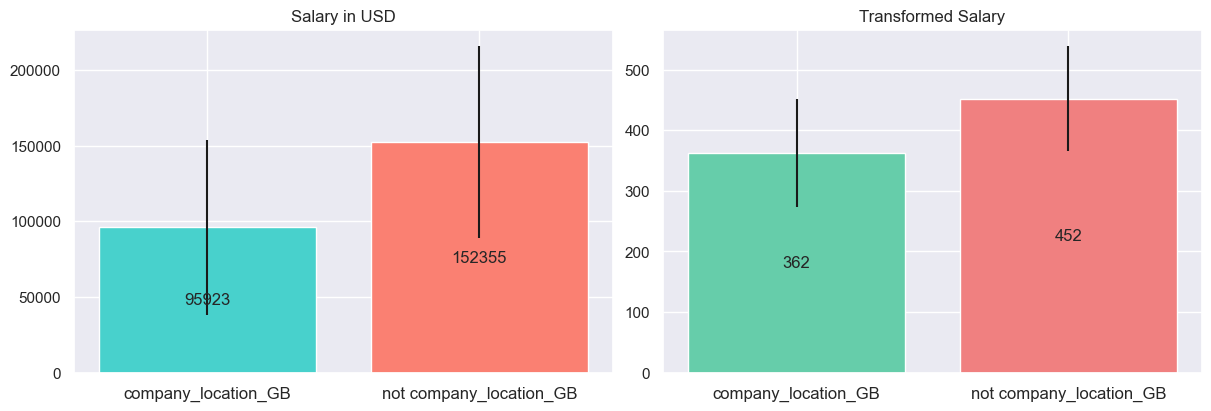

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_GR                                                   
0                          149968  64365  14262                448  89
1                           52260  21279     14                279  55

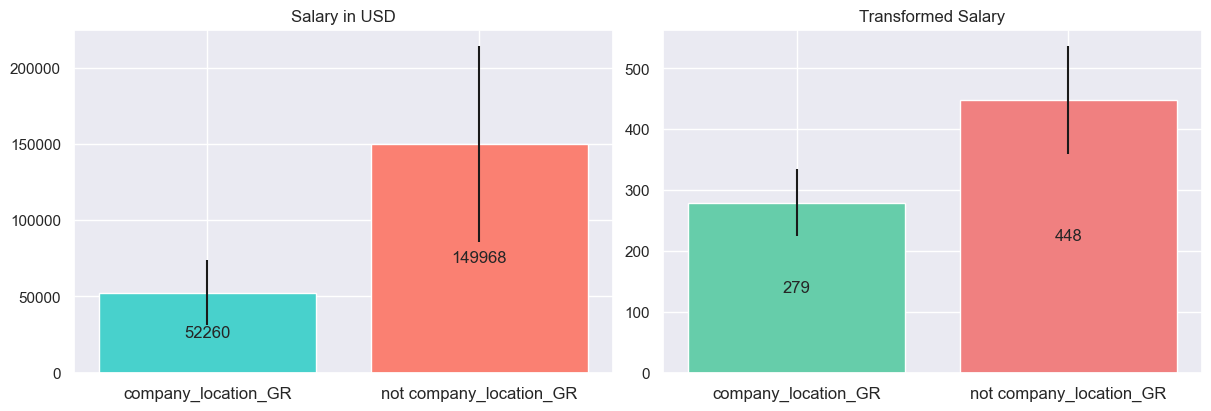

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_IE                                                   
0                          149910  64416  14264                448  89
1                          104694  33896     12                386  53

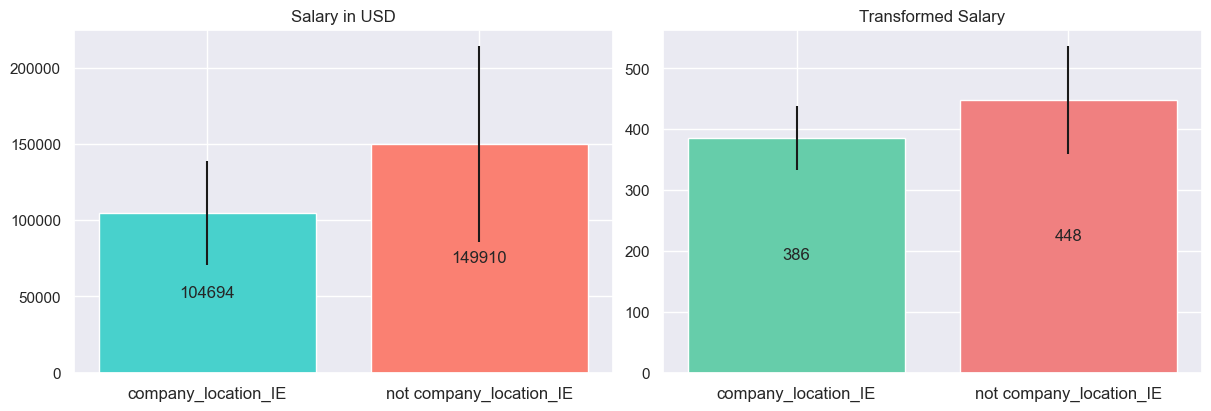

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_IN                                                   
0                          150307  64134  14219                449  88
1                           41360  34229     57                242  78

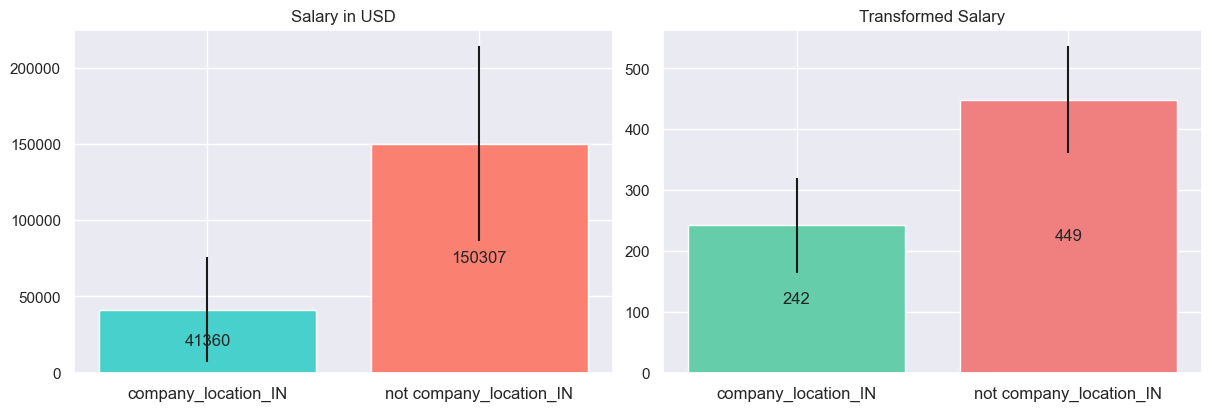

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_IT                                                   
0                          149971  64362  14262                448  89
1                           49600  18169     14                274  49

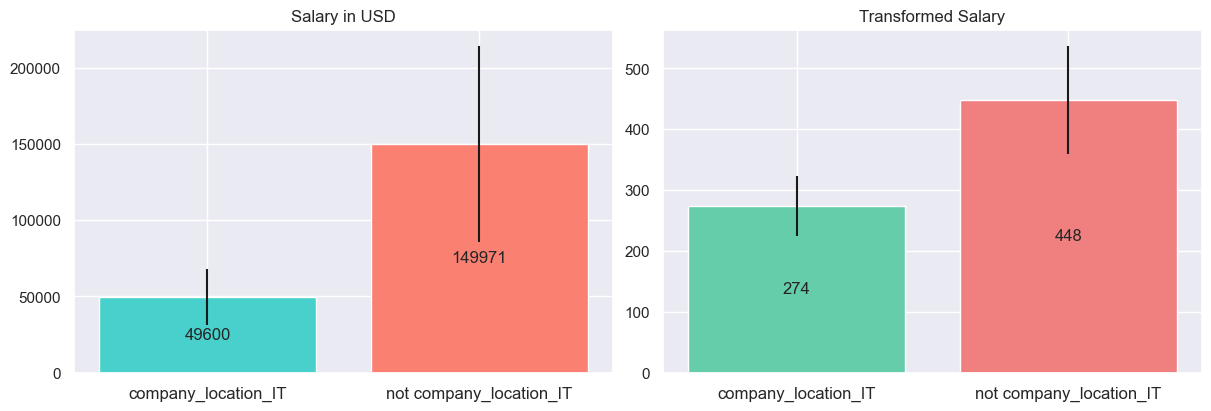

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_LT                                                   
0                          149964  64381  14260                448  89
1                           68553  29287     16                316  60

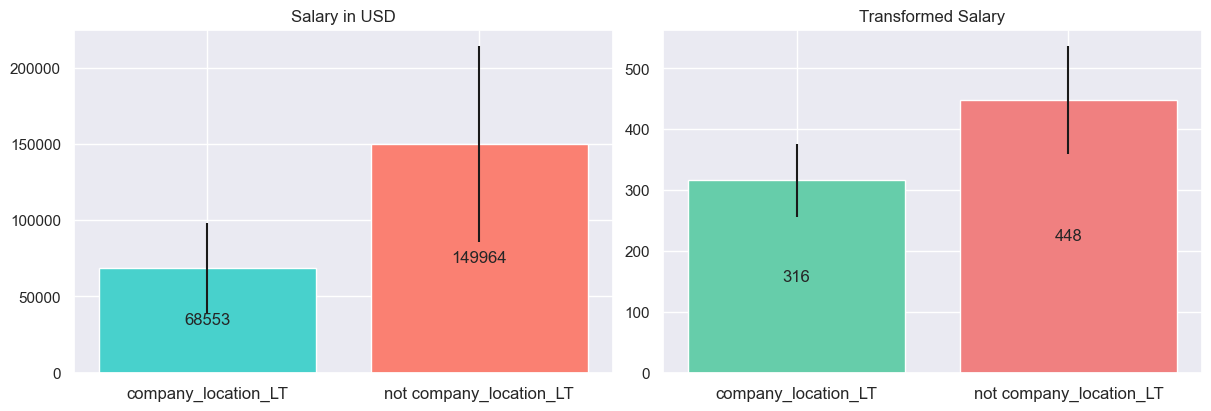

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_LV                                                   
0                          149966  64369  14262                448  89
1                           54734  19875     14                287  46

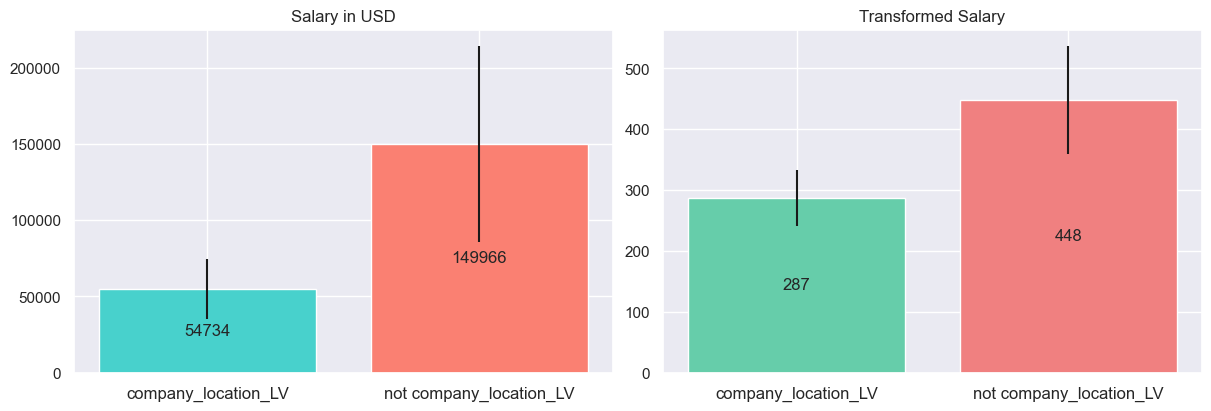

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
company_location_MX                                                    
0                          149930  64378  14263                448   89
1                           87007  70236     13                334  123

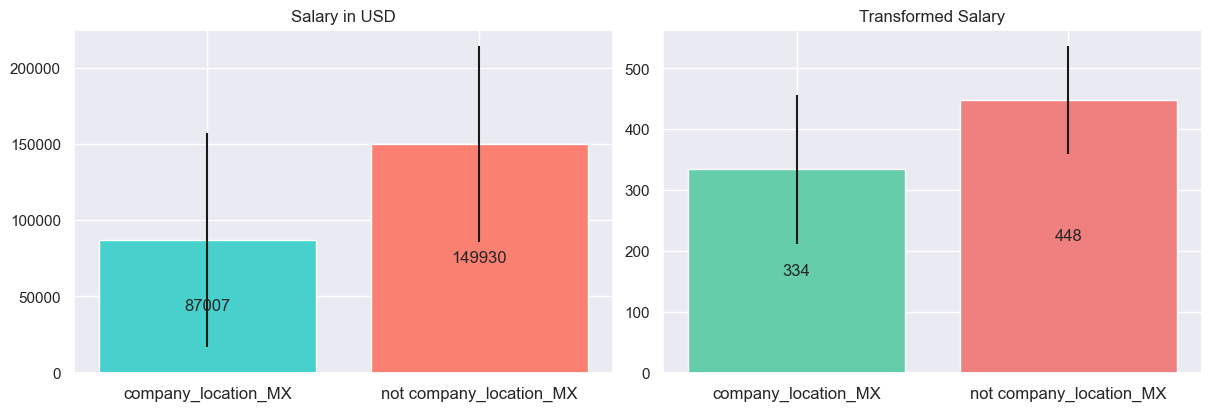

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_NG                                                   
0                          149929  64377  14267                448  89
1                           60444  54127      9                287  97

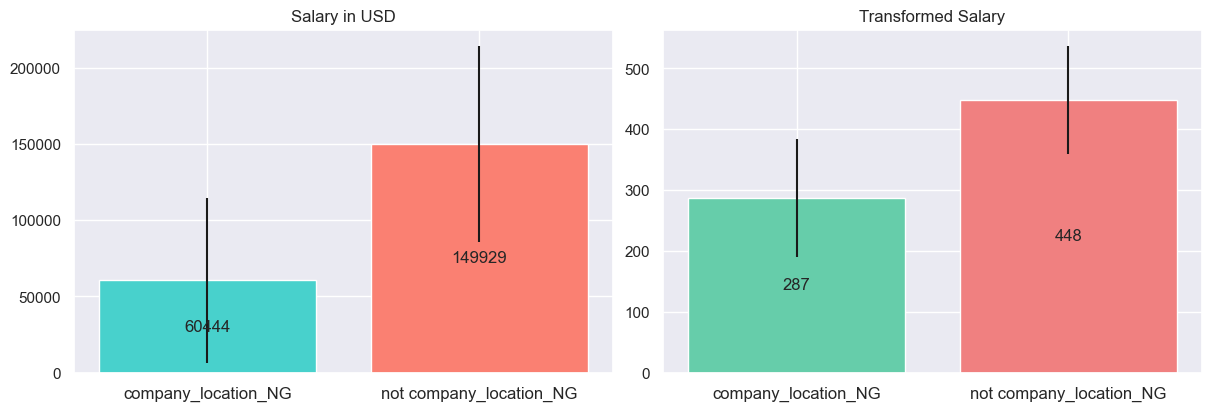

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_NL                                                   
0                          150017  64376  14248                448  89
1                           76171  30171     28                332  61

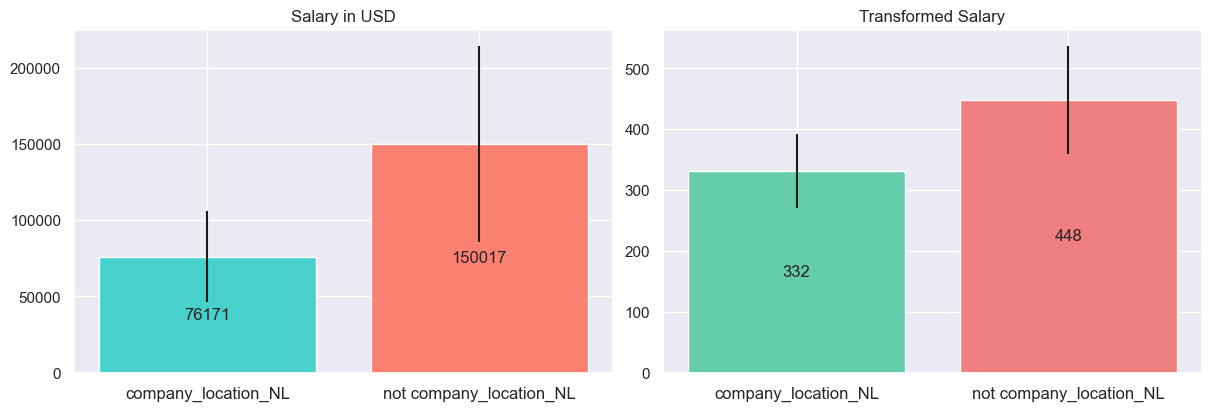

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_NZ                                                   
0                          149872  64418  14271                448  89
1                          152218  35137      5                460  46

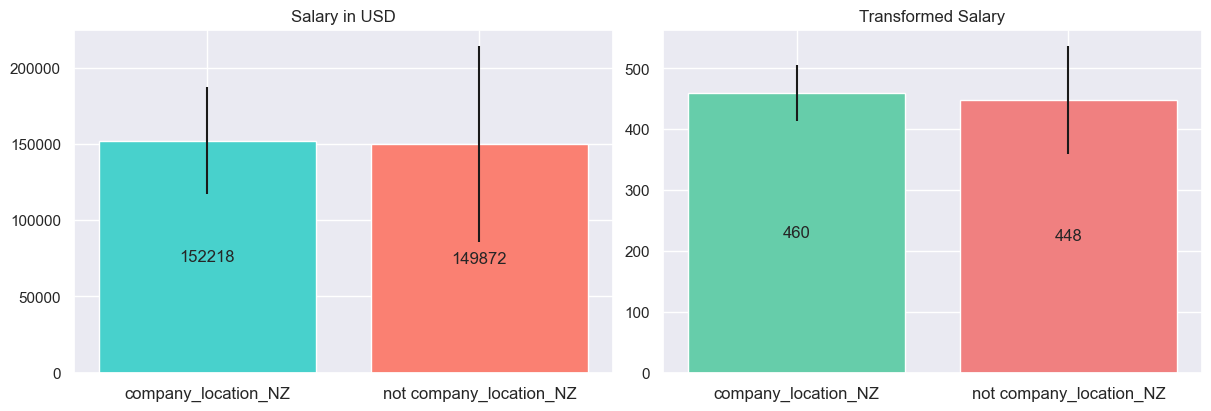

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_PH                                                   
0                          149905  64395  14271                448  89
1                           55720  27981      5                286  68

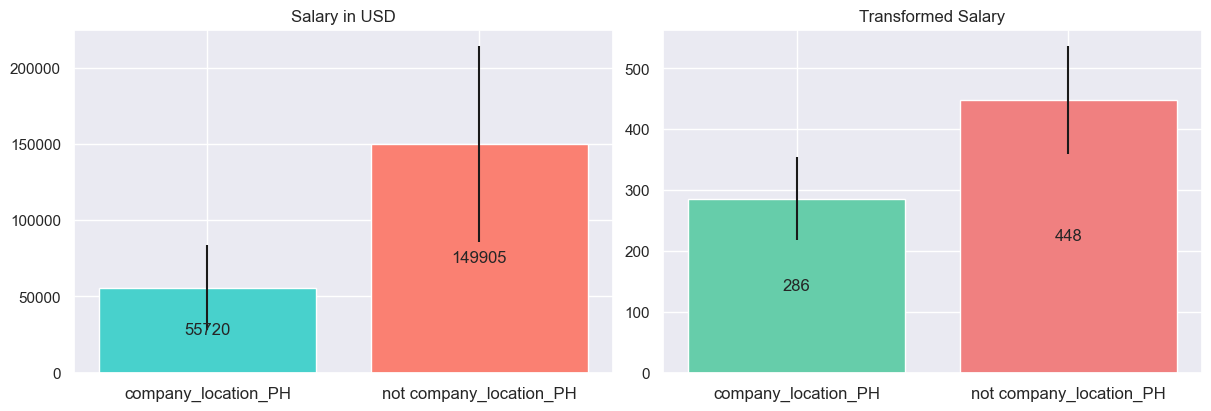

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
company_location_PL                                                    
0                          149930  64389  14263                448   89
1                           86787  56866     13                342  101

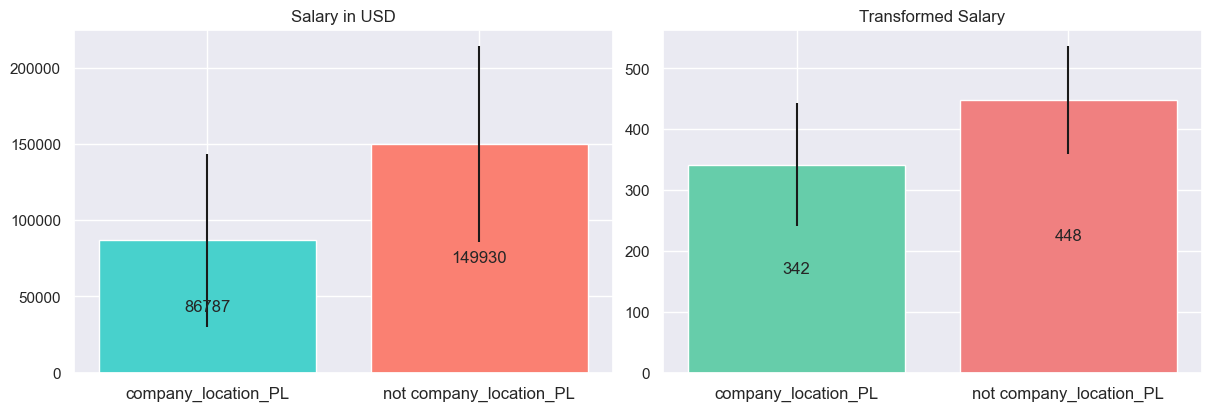

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_PT                                                   
0                          150060  64319  14249                448  89
1                           51115  22826     27                276  57

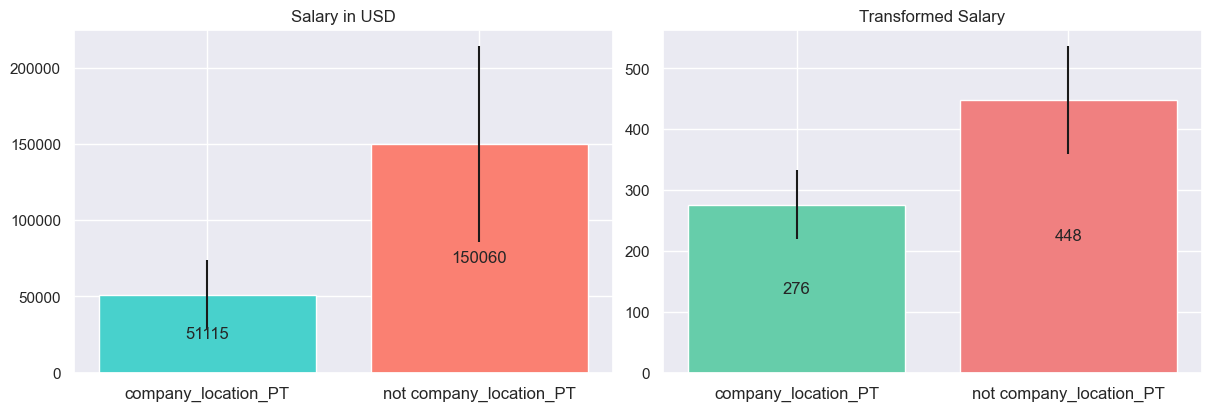

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_SI                                                   
0                          149912  64392  14270                448  89
1                           56186  28245      6                287  65

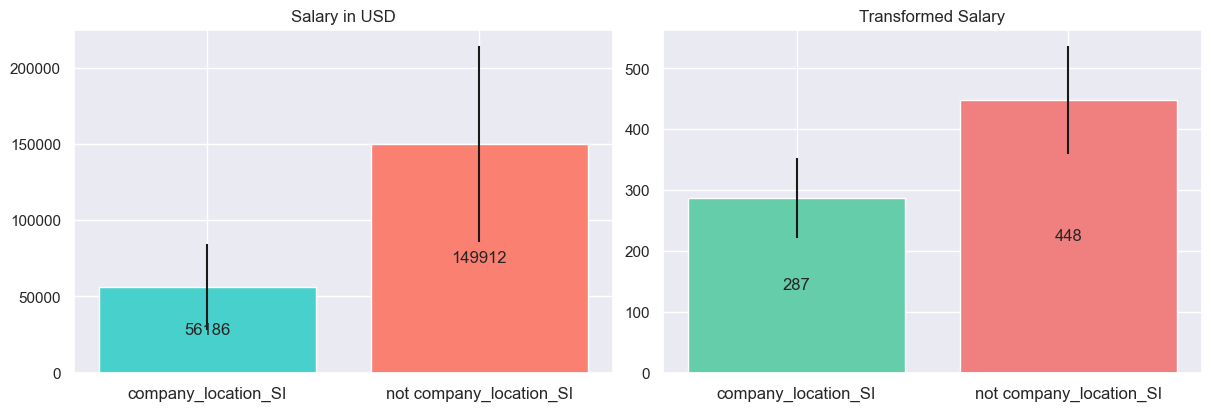

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
company_location_UA                                                    
0                          149904  64397  14266                448   89
1                          105600  70596     10                375  108

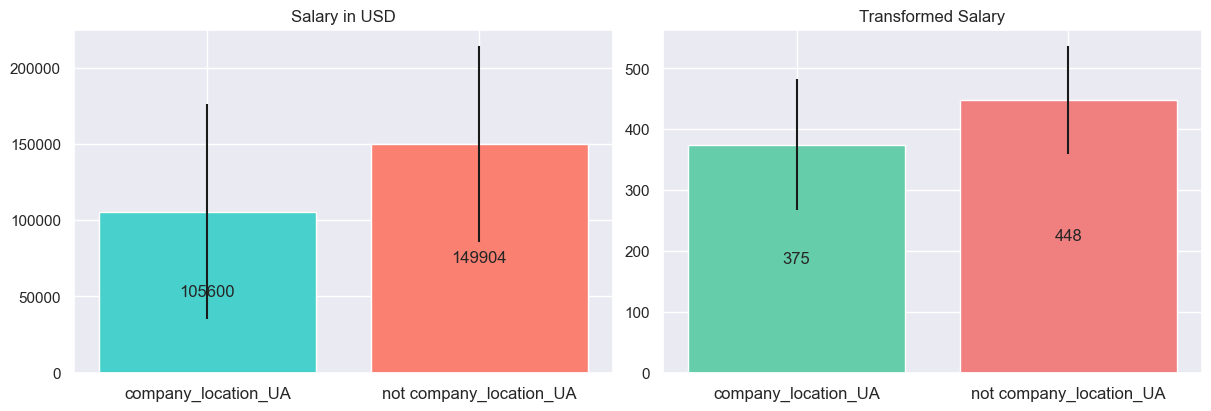

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_US                                                   
0                           99010  61761   1664                364  99
1                          156583  61697  12612                459  81

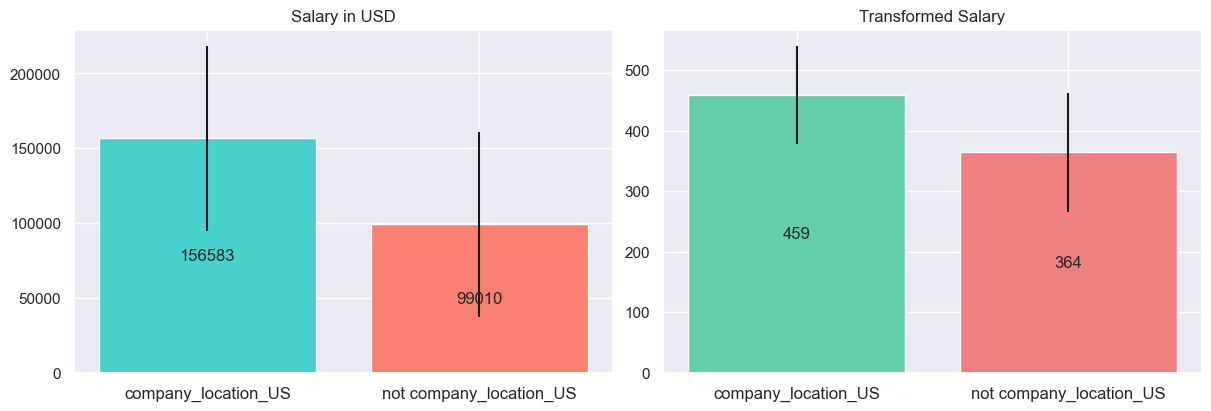

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_ZA                                                   
0                          149963  64371  14262                448  89
1                           57308  24142     14                292  51

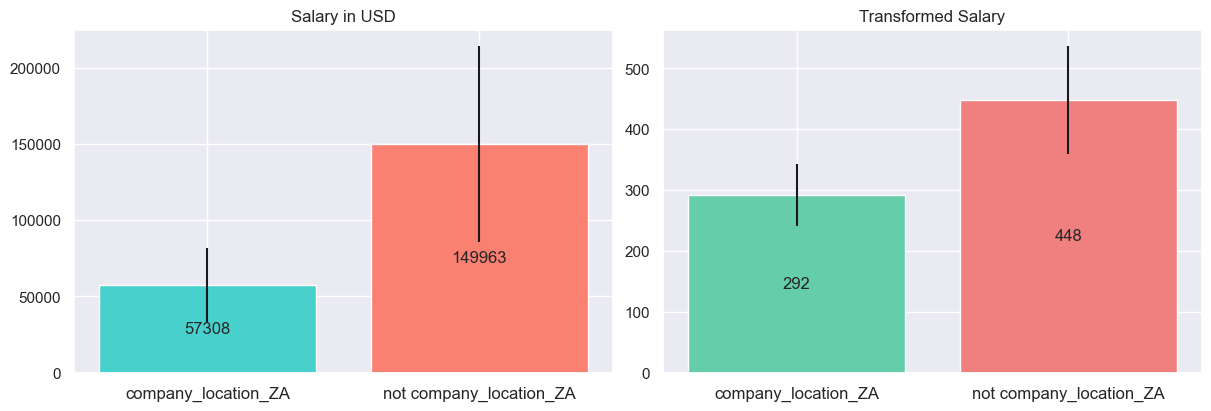

salary_in_usd               transformed_salary     
                        mean    std  count               mean  std
company_size_L                                                    
0                     150305  63815  13367                449   87
1                     143506  72321    909                434  107

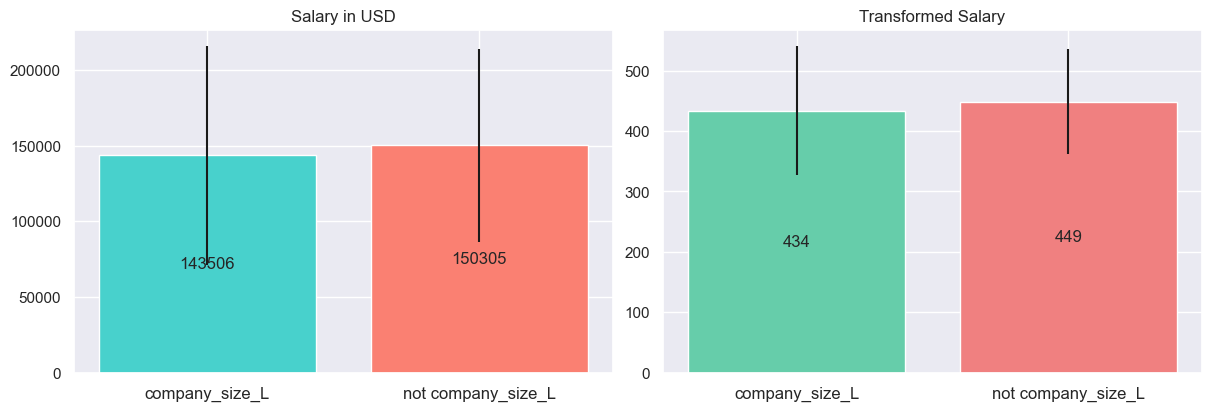

salary_in_usd               transformed_salary     
                        mean    std  count               mean  std
company_size_M                                                    
0                     137244  72988   1037                424  110
1                     150862  63586  13239                450   87

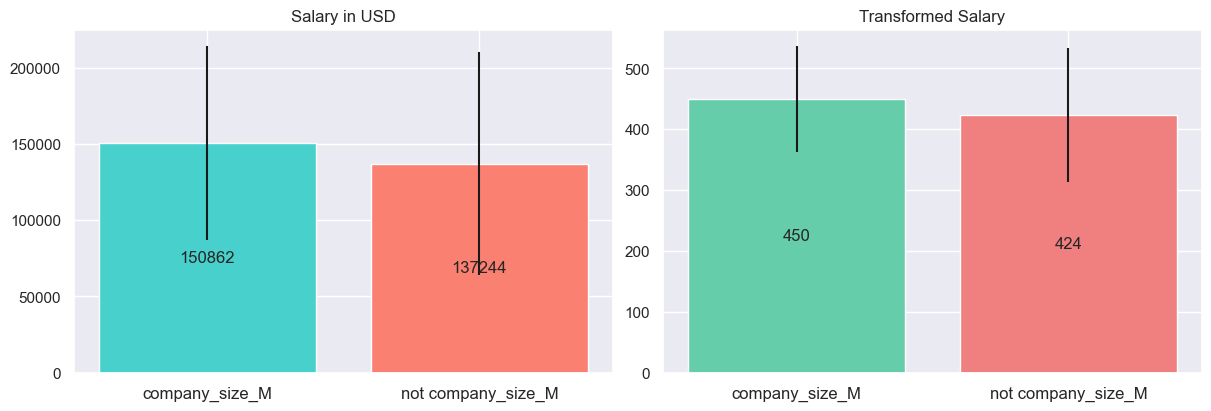

salary_in_usd               transformed_salary     
                        mean    std  count               mean  std
company_size_S                                                    
0                     150389  64205  14148                449   88
1                      92776  61553    128                352  102

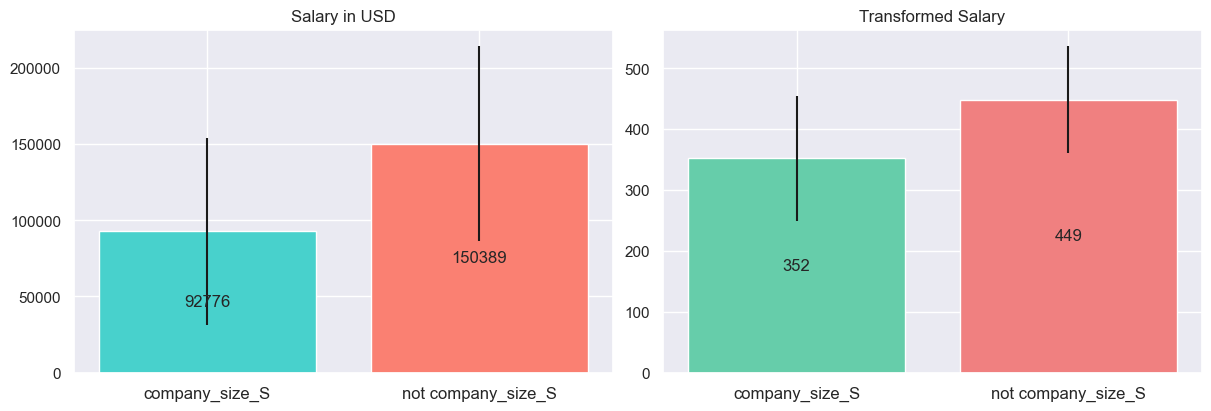

In [35]:
diffs = {}
z_scores = {}

aux = new_X.groupby('work_year')[['salary_in_usd', 'transformed_salary']].agg(['mean', 'std', 'count']).iloc[:,:5].astype(int)
display(aux)
for year in aux.index:
    diffs['work_year_' + str(year)] = aux.loc[year,('transformed_salary', 'mean')] - avg
    z_scores['work_year_' + str(year)] = abs(diffs['work_year_' + str(year)])/aux.loc[year,('transformed_salary', 'std')]

for var in new_X.columns[1:-2]:
    aux = new_X.groupby(var)[['salary_in_usd', 'transformed_salary']].agg(['mean', 'std', 'count']).iloc[:,:5].astype(int)
    display(aux)
    diffs[var] = aux.loc[1,('transformed_salary', 'mean')] - avg
    z_scores[var] = abs(diffs[var])/aux.loc[1,('transformed_salary', 'std')]
    plotting(var)

In [36]:
print('Differences to the mean for every transformed salary, sorted by largest to smallest\n',
     'These are intended to evaluate what looks more significant.')
dict(sorted(diffs.items(), key=lambda item: item[1], reverse=True))

Differences to the mean for every transformed salary, sorted by largest to smallest
 These are intended to evaluate what looks more significant.


{'job_name_Director': 83.50835068064436,
 'job_name_Head': 79.50835068064436,
 'experience_level_EX': 57.508350680644355,
 'job_name_Applied': 49.508350680644355,
 'job_name_Machine': 48.508350680644355,
 'job_name_Prompt': 39.508350680644355,
 'job_name_Infrastructure': 38.508350680644355,
 'job_name_Deep': 37.508350680644355,
 'job_name_Research': 33.508350680644355,
 'job_name_Software': 32.508350680644355,
 'job_name_Decision': 29.508350680644355,
 'job_name_Architect': 26.508350680644355,
 'job_name_Vision': 26.508350680644355,
 'job_name_Principal': 23.508350680644355,
 'job_name_Robotics': 22.508350680644355,
 'experience_level_SE': 20.508350680644355,
 'job_name_AI': 19.508350680644355,
 'job_name_Scientist': 17.508350680644355,
 'job_name_Engineer': 15.508350680644355,
 'employee_residence_NZ': 11.508350680644355,
 'company_location_NZ': 11.508350680644355,
 'employee_residence_US': 10.508350680644355,
 'company_location_US': 10.508350680644355,
 'job_name_Cloud': 9.5083506806

In [37]:
print('Absolute Z scores against the mean for every transformed salary, sorted by largest to smallest\n',
     'These are intended to evaluate what variables are most stably different from the mean.')
dict(sorted(z_scores.items(), key=lambda item: item[1], reverse=True))

Absolute Z scores against the mean for every transformed salary, sorted by largest to smallest
 These are intended to evaluate what variables are most stably different from the mean.


{'job_name_Insight': 9.394297332597665,
 'employee_residence_EE': 8.064854318232854,
 'company_location_EE': 8.064854318232854,
 'salary_currency_PLN': 5.661936468090693,
 'salary_currency_INR': 4.1790877230067105,
 'job_name_Associate': 4.077864041229864,
 'employee_residence_AT': 4.015364041229864,
 'company_location_AT': 3.984114041229864,
 'company_location_IT': 3.561054067741952,
 'employee_residence_LV': 3.5106880286816446,
 'company_location_LV': 3.5106880286816446,
 'company_location_AR': 3.4186932248474498,
 'employee_residence_AR': 3.3926583171275153,
 'employee_residence_GR': 3.0998481694428297,
 'company_location_GR': 3.0816663512610116,
 'employee_residence_ZA': 3.0684637121442284,
 'company_location_ZA': 3.0684637121442284,
 'company_location_PT': 3.026169286304485,
 'employee_residence_PH': 2.9066381240568755,
 'employment_type_FL': 2.7767946049131638,
 'company_location_IN': 2.6473288374276365,
 'company_location_ES': 2.6310106445796007,
 'employee_residence_PT': 2.6170

In [41]:
devs = pd.DataFrame(diffs, index=['differences']).transpose().join(pd.DataFrame(z_scores, index=['abs_z_score']).transpose())
devs.sort_values('abs_z_score', ascending=False).head(30)

differences  abs_z_score
job_name_Insight       -178.491649     9.394297
employee_residence_EE  -185.491649     8.064854
company_location_EE    -185.491649     8.064854
salary_currency_PLN    -209.491649     5.661936
salary_currency_INR    -221.491649     4.179088
job_name_Associate     -130.491649     4.077864
employee_residence_AT  -128.491649     4.015364
company_location_AT    -127.491649     3.984114
company_location_IT    -174.491649     3.561054
employee_residence_LV  -161.491649     3.510688
company_location_LV    -161.491649     3.510688
company_location_AR    -126.491649     3.418693
employee_residence_AR  -142.491649     3.392658
employee_residence_GR  -170.491649     3.099848
company_location_GR    -169.491649     3.081666
company_location_ZA    -156.491649     3.068464
employee_residence_ZA  -156.491649     3.068464
company_location_PT    -172.491649     3.026169
employee_residence_PH  -171.491649     2.906638
employment_type_FL     -180.491649     2.776795
company_location_IN    -206.491649     2.647329
company_location_ES    -160.491649     2.631011
employee_residence_PT  -167.491649     2.617057
company_location_BR    -134.491649     2.537578
employee_residence_IT  -166.491649     2.484950
employee_residence_SI  -161.491649     2.484487
company_location_SI    -161.491649     2.484487
company_location_PH    -162.491649     2.389583
employee_residence_ES  -157.491649     2.386237
salary_currency_EUR    -143.491649     2.277645

In [48]:
display(devs[devs.differences > 0].sort_values('abs_z_score', ascending=False))

differences  abs_z_score
job_name_Director          83.508351     1.018395
job_name_Head              79.508351     0.764503
job_name_Decision          29.508351     0.719716
experience_level_EX        57.508351     0.676569
job_name_Applied           49.508351     0.642966
job_name_Machine           48.508351     0.584438
job_name_Prompt            39.508351     0.500106
job_name_Infrastructure    38.508351     0.469614
job_name_Architect         26.508351     0.335549
job_name_Research          33.508351     0.328513
job_name_Software          32.508351     0.295530
job_name_Deep              37.508351     0.290762
job_name_Robotics          22.508351     0.281354
experience_level_SE        20.508351     0.256354
company_location_NZ        11.508351     0.250182
employee_residence_NZ      11.508351     0.250182
job_name_Principal         23.508351     0.230474
job_name_Vision            26.508351     0.220903
job_name_Scientist         17.508351     0.203585
job_name_Engineer          15.508351     0.180330
job_name_AI                19.508351     0.172640
job_name_Cloud              9.508351     0.141916
employee_residence_US      10.508351     0.129733
company_location_US        10.508351     0.129733
salary_currency_USD         9.508351     0.115955
job_name_Analytics          5.508351     0.073445
work_year_2023              5.508351     0.064051
remote_ratio_On_Site        4.508351     0.050656
job_name_Product            3.508351     0.046778
company_size_M              1.508351     0.017337
job_name_Lead               0.508351     0.004382